In [ ]:
# ADD SOFTMAX at the end
# rerun the testing but with the probabilities with softmax, maybe it will be better, also proba to get
# kinda description after

In [9]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_from_disk
from tqdm.auto import tqdm
import gc
from PIL import Image
import torch.nn.functional as F
import torchvision.models as models
import itertools
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import time
import json

In [10]:
dataset_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/data/remapped_dataset"
dataset = load_from_disk(dataset_path)
print("Remapped dataset loaded from disk")
print(f"Dataset size: {len(dataset)} images.")

split_ds = dataset.train_test_split(test_size=0.2, seed=42)
test_dataset = split_ds["test"]
train_val_dataset = split_ds["train"]
split_remaining = train_val_dataset.train_test_split(test_size=0.125, seed=42)
train_dataset = split_remaining["train"]
val_dataset = split_remaining["test"]

print(f"Train dataset size: {len(train_dataset)} images")
print(f"Validation dataset size: {len(val_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def process_image(image):
    """Applies the transformation and ensures the output is 224x224."""
    img_tensor = train_transforms(image)
    if img_tensor.shape[-2:] != (224, 224):
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
    return img_tensor

def custom_collate_fn(batch):
    """Custom collate: transforms images and converts labels to tensors."""
    images = [process_image(item["image"]) for item in batch]
    genres = torch.tensor([item["genre"] for item in batch])
    styles = torch.tensor([item["style"] for item in batch])
    return {"image": torch.stack(images), "genre": genres, "style": styles}
    

Remapped dataset loaded from disk
Dataset size: 17061 images.
Train dataset size: 11942 images
Validation dataset size: 1706 images
Test dataset size: 3413 images


In [11]:
class ResNet50FineTuneMultiHead(nn.Module):
    def __init__(self, num_genres, num_styles, dropout_rate=0.0):
        super(ResNet50FineTuneMultiHead, self).__init__()
        # Load pretrained ResNet50
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        # Freeze all layers first
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Unfreeze the last 4 children modules
        children = list(self.resnet.children())
        for child in children[-4:]:
            for param in child.parameters():
                param.requires_grad = True
        
        # Replace the final fully connected layer with an identity to extract features
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        
        # Define new classifier heads with dropout for multi-task learning
        self.genre_classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_genres) # RAW LOGITS
        )
        self.style_classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_styles)
        )
        
    def forward(self, x):
        features = self.resnet(x)
        genre_logits = self.genre_classifier(features)
        style_logits = self.style_classifier(features)
        return genre_logits, style_logits

num_genres = len(set(dataset["genre"]))
num_styles = len(set(dataset["style"]))
print(f"Number of genre classes: {num_genres}")
print(f"Number of style classes: {num_styles}")


Number of genre classes: 11
Number of style classes: 11


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hp_grid = {
    "learning_rate": [1e-4, 5e-5],
    "batch_size": [32, 64],
    "num_epochs": [20],
    "weight_decay": [0, 1e-4],
    "dropout_rate": [0, 0.3]
}

# Create list of hyperparameter configurations
configs = list(itertools.product(*hp_grid.values()))
print("Hyperparameter configurations to try:", configs)

best_global_joint_acc = -1.0
best_global_style_acc = -1.0
best_config = None
best_model_state = None
best_history = None

model_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50_finetune/best_resnet50_finetune_multihhead.pth"
config_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50_finetune/best_config.json"

def compute_metrics(genre_logits, style_logits, genre_labels, style_labels):
    """Compute genre, style, and joint accuracy."""
    pred_genre = torch.argmax(genre_logits, dim=1)
    pred_style = torch.argmax(style_logits, dim=1)
    acc_genre = (pred_genre == genre_labels).float().mean().item()
    acc_style = (pred_style == style_labels).float().mean().item()
    joint_acc = ((pred_genre == genre_labels) & (pred_style == style_labels)).float().mean().item()
    return acc_genre, acc_style, joint_acc

Hyperparameter configurations to try: [(0.0001, 32, 20, 0, 0), (0.0001, 32, 20, 0, 0.3), (0.0001, 32, 20, 0.0001, 0), (0.0001, 32, 20, 0.0001, 0.3), (0.0001, 64, 20, 0, 0), (0.0001, 64, 20, 0, 0.3), (0.0001, 64, 20, 0.0001, 0), (0.0001, 64, 20, 0.0001, 0.3), (5e-05, 32, 20, 0, 0), (5e-05, 32, 20, 0, 0.3), (5e-05, 32, 20, 0.0001, 0), (5e-05, 32, 20, 0.0001, 0.3), (5e-05, 64, 20, 0, 0), (5e-05, 64, 20, 0, 0.3), (5e-05, 64, 20, 0.0001, 0), (5e-05, 64, 20, 0.0001, 0.3)]


In [ ]:
BLOCK!

In [5]:
start_time = time.time()

for config in configs:
    # Unpack configuration
    lr, batch_size, num_epochs, wd, dropout_rate = config
    print(f"\nTraining with config: lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}, weight_decay={wd}, dropout_rate={dropout_rate}")
    
    # Create DataLoaders with current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    val_check_interval = max(1, len(train_loader) // 5)
    print(f"Validation will be checked every {val_check_interval} batches\n")
    
    # Initialize model, criterion, optimizer, scheduler
    model = ResNet50FineTuneMultiHead(num_genres, num_styles, dropout_rate=dropout_rate).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    # History for this configuration
    history = {
        "config": {"learning_rate": lr, "batch_size": batch_size, "num_epochs": num_epochs, "weight_decay": wd, "dropout_rate": dropout_rate},
        "train_loss": [],
        "train_genre_acc": [],
        "train_style_acc": [],
        "train_joint_acc": [],
        "val_loss": [],
        "val_genre_acc": [],
        "val_style_acc": [],
        "val_joint_acc": [],
        "val_check_metrics": []
    }
    
    best_val_joint_acc_config = -1.0
    best_val_style_acc_config = -1.0
    best_model_state_config = None
    batch_count = 0
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        train_genre_acc = 0.0
        train_style_acc = 0.0
        train_joint_acc = 0.0
        total_train = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            batch_count += 1
            images = batch["image"].to(device)
            genre_labels = batch["genre"].to(device)
            style_labels = batch["style"].to(device)
            
            optimizer.zero_grad()
            genre_logits, style_logits = model(images)
            loss = criterion(genre_logits, genre_labels) + criterion(style_logits, style_labels)
            loss.backward()
            optimizer.step()
            
            bsize = images.size(0)
            train_loss += loss.item() * bsize
            acc_genre, acc_style, joint = compute_metrics(genre_logits, style_logits, genre_labels, style_labels)
            train_genre_acc += acc_genre * bsize
            train_style_acc += acc_style * bsize
            train_joint_acc += joint * bsize
            total_train += bsize
            
            # Check validation at intervals
            if batch_count % val_check_interval == 0:
                model.eval()
                val_loss = 0.0
                val_genre_acc = 0.0
                val_style_acc = 0.0
                val_joint_acc = 0.0
                total_val = 0
                with torch.no_grad():
                    for vbatch in val_loader:
                        vimages = vbatch["image"].to(device)
                        vgenre_labels = vbatch["genre"].to(device)
                        vstyle_labels = vbatch["style"].to(device)
                        v_genre_logits, v_style_logits = model(vimages)
                        vloss = criterion(v_genre_logits, vgenre_labels) + criterion(v_style_logits, vstyle_labels)
                        vbsize = vimages.size(0)
                        val_loss += vloss.item() * vbsize
                        vg, vs, vjoint = compute_metrics(v_genre_logits, v_style_logits, vgenre_labels, vstyle_labels)
                        val_genre_acc += vg * vbsize
                        val_style_acc += vs * vbsize
                        val_joint_acc += vjoint * vbsize
                        total_val += vbsize
                avg_val_loss_interval = val_loss / total_val
                avg_val_genre_acc_interval = val_genre_acc / total_val
                avg_val_style_acc_interval = val_style_acc / total_val
                avg_val_joint_acc_interval = val_joint_acc / total_val
                print(f"Epoch {epoch+1}, Batch {batch_count} Val: Loss={avg_val_loss_interval:.4f}, "
                      f"Genre Acc={avg_val_genre_acc_interval:.4f}, Style Acc={avg_val_style_acc_interval:.4f}, "
                      f"Joint Acc={avg_val_joint_acc_interval:.4f}")

                history["val_check_metrics"].append({
                    "epoch": epoch+1,
                    "batch_count": batch_count,
                    "val_loss": avg_val_loss_interval,
                    "val_genre_acc": avg_val_genre_acc_interval,
                    "val_style_acc": avg_val_style_acc_interval,
                    "val_joint_acc": avg_val_joint_acc_interval
                })
                
                # Update best model
                if (avg_val_joint_acc_interval > best_val_joint_acc_config) or \
                   (avg_val_joint_acc_interval == best_val_joint_acc_config and avg_val_style_acc_interval > best_val_style_acc_config):
                    best_val_joint_acc_config = avg_val_joint_acc_interval
                    best_val_style_acc_config = avg_val_style_acc_interval
                    best_model_state_config = model.state_dict()
                    print(f"[!] New best model at batch {batch_count}: Val Joint Acc={avg_val_joint_acc_interval:.4f}, Val Style Acc={avg_val_style_acc_interval:.4f}")
                model.train()
        
        # End-of-epoch summary
        avg_train_loss = train_loss / total_train
        avg_train_genre_acc = train_genre_acc / total_train
        avg_train_style_acc = train_style_acc / total_train
        avg_train_joint_acc = train_joint_acc / total_train
        print(f"Epoch {epoch+1} Train: Loss={avg_train_loss:.4f}, Genre Acc={avg_train_genre_acc:.4f}, "
              f"Style Acc={avg_train_style_acc:.4f}, Joint Acc={avg_train_joint_acc:.4f}")
        
        # Full validation at epoch end
        model.eval()
        val_loss = 0.0
        val_genre_acc = 0.0
        val_style_acc = 0.0
        val_joint_acc = 0.0
        total_val = 0
        with torch.no_grad():
            for vbatch in val_loader:
                vimages = vbatch["image"].to(device)
                vgenre_labels = vbatch["genre"].to(device)
                vstyle_labels = vbatch["style"].to(device)
                v_genre_logits, v_style_logits = model(vimages)
                vloss = criterion(v_genre_logits, vgenre_labels) + criterion(v_style_logits, vstyle_labels)
                vbsize = vimages.size(0)
                val_loss += vloss.item() * vbsize
                vg, vs, vjoint = compute_metrics(v_genre_logits, v_style_logits, vgenre_labels, vstyle_labels)
                val_genre_acc += vg * vbsize
                val_style_acc += vs * vbsize
                val_joint_acc += vjoint * vbsize
                total_val += vbsize
        avg_val_loss = val_loss / total_val
        avg_val_genre_acc = val_genre_acc / total_val
        avg_val_style_acc = val_style_acc / total_val
        avg_val_joint_acc = val_joint_acc / total_val
        history["val_loss"].append(avg_val_loss)
        history["val_genre_acc"].append(avg_val_genre_acc)
        history["val_style_acc"].append(avg_val_style_acc)
        history["val_joint_acc"].append(avg_val_joint_acc)

        print(f"Epoch {epoch+1} Val: Loss={avg_val_loss:.4f}, Genre Acc={avg_val_genre_acc:.4f}, "
              f"Style Acc={avg_val_style_acc:.4f}, Joint Acc={avg_val_joint_acc:.4f}\n")
        scheduler.step(avg_val_loss)

        # Update best model
        if (avg_val_joint_acc > best_val_joint_acc_config) or \
           (avg_val_joint_acc == best_val_joint_acc_config and avg_val_style_acc > best_val_style_acc_config):
            best_val_joint_acc_config = avg_val_joint_acc
            best_val_style_acc_config = avg_val_style_acc
            best_model_state_config = model.state_dict()
            print(f"[!] New best model at end of epoch {epoch+1}: Val Joint Acc={avg_val_joint_acc:.4f}, Val Style Acc={avg_val_style_acc:.4f}\n")
    
    # Update best GLOBAL model
    if (best_val_joint_acc_config > best_global_joint_acc) or \
       (best_val_joint_acc_config == best_global_joint_acc and best_val_style_acc_config > best_global_style_acc):
        best_global_joint_acc = best_val_joint_acc_config
        best_global_style_acc = best_val_style_acc_config
        best_config = {"learning_rate": lr, "batch_size": batch_size, "num_epochs": num_epochs,
                       "weight_decay": wd, "dropout_rate": dropout_rate}
        with open(config_path, "w") as f:
            json.dump(best_config, f)
        best_model_state = best_model_state_config
        best_history = history
        print(f"[!] New best overall config: {best_config} with Val Joint Acc={best_val_joint_acc_config:.4f} and Val Style Acc={best_val_style_acc_config:.4f}\n")
        torch.save(best_model_state, model_path)
        print("[*] Best model saved!\n")

end_time = time.time()
elapsed_time = end_time - start_time

print("\nHyperparameter tuning complete")
print("Best overall configuration:", best_config)
print(f"\nFull training lasted {elapsed_time/3600:.2f} hours ({elapsed_time/60:.2f} minutes).\n")



Training with config: lr=0.0001, batch_size=32, num_epochs=20, weight_decay=0, dropout_rate=0
Validation will be checked every 74 batches



Training Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 1, Batch 74 Val: Loss=3.3621, Genre Acc=0.5322, Style Acc=0.4039, Joint Acc=0.2708
[!] New best model at batch 74: Val Joint Acc=0.2708, Val Style Acc=0.4039
Epoch 1, Batch 148 Val: Loss=2.9108, Genre Acc=0.5522, Style Acc=0.4513, Joint Acc=0.3142
[!] New best model at batch 148: Val Joint Acc=0.3142, Val Style Acc=0.4513
Epoch 1, Batch 222 Val: Loss=2.6978, Genre Acc=0.6032, Style Acc=0.5152, Joint Acc=0.3728
[!] New best model at batch 222: Val Joint Acc=0.3728, Val Style Acc=0.5152
Epoch 1, Batch 296 Val: Loss=2.5562, Genre Acc=0.6014, Style Acc=0.5217, Joint Acc=0.3810
[!] New best model at batch 296: Val Joint Acc=0.3810, Val Style Acc=0.5217
Epoch 1, Batch 370 Val: Loss=2.4944, Genre Acc=0.6184, Style Acc=0.5487, Joint Acc=0.4050
[!] New best model at batch 370: Val Joint Acc=0.4050, Val Style Acc=0.5487
Epoch 1 Train: Loss=3.1357, Genre Acc=0.5219, Style Acc=0.4240, Joint Acc=0.2881
Epoch 1 Val: Loss=2.4635, Genre Acc=0.6149, Style Acc=0.5463, Joint Acc=0.4056

[!] New bes

Training Epoch 2:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 2, Batch 444 Val: Loss=2.3932, Genre Acc=0.6166, Style Acc=0.5645, Joint Acc=0.4121
[!] New best model at batch 444: Val Joint Acc=0.4121, Val Style Acc=0.5645
Epoch 2, Batch 518 Val: Loss=2.3396, Genre Acc=0.6278, Style Acc=0.5762, Joint Acc=0.4273
[!] New best model at batch 518: Val Joint Acc=0.4273, Val Style Acc=0.5762
Epoch 2, Batch 592 Val: Loss=2.3316, Genre Acc=0.6307, Style Acc=0.5785, Joint Acc=0.4179
Epoch 2, Batch 666 Val: Loss=2.3290, Genre Acc=0.6348, Style Acc=0.5750, Joint Acc=0.4308
[!] New best model at batch 666: Val Joint Acc=0.4308, Val Style Acc=0.5750
Epoch 2, Batch 740 Val: Loss=2.2780, Genre Acc=0.6372, Style Acc=0.5868, Joint Acc=0.4420
[!] New best model at batch 740: Val Joint Acc=0.4420, Val Style Acc=0.5868
Epoch 2 Train: Loss=2.3603, Genre Acc=0.6280, Style Acc=0.5656, Joint Acc=0.4132
Epoch 2 Val: Loss=2.2296, Genre Acc=0.6559, Style Acc=0.6032, Joint Acc=0.4549

[!] New best model at end of epoch 2: Val Joint Acc=0.4549, Val Style Acc=0.6032



Training Epoch 3:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 3, Batch 814 Val: Loss=2.2508, Genre Acc=0.6424, Style Acc=0.5967, Joint Acc=0.4443
Epoch 3, Batch 888 Val: Loss=2.2517, Genre Acc=0.6442, Style Acc=0.6026, Joint Acc=0.4519
Epoch 3, Batch 962 Val: Loss=2.1889, Genre Acc=0.6465, Style Acc=0.6084, Joint Acc=0.4560
[!] New best model at batch 962: Val Joint Acc=0.4560, Val Style Acc=0.6084
Epoch 3, Batch 1036 Val: Loss=2.1670, Genre Acc=0.6618, Style Acc=0.6084, Joint Acc=0.4683
[!] New best model at batch 1036: Val Joint Acc=0.4683, Val Style Acc=0.6084
Epoch 3, Batch 1110 Val: Loss=2.1716, Genre Acc=0.6559, Style Acc=0.6260, Joint Acc=0.4760
[!] New best model at batch 1110: Val Joint Acc=0.4760, Val Style Acc=0.6260
Epoch 3 Train: Loss=2.1074, Genre Acc=0.6589, Style Acc=0.6198, Joint Acc=0.4648
Epoch 3 Val: Loss=2.2074, Genre Acc=0.6442, Style Acc=0.6102, Joint Acc=0.4596



Training Epoch 4:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 4, Batch 1184 Val: Loss=2.0990, Genre Acc=0.6583, Style Acc=0.6424, Joint Acc=0.4930
[!] New best model at batch 1184: Val Joint Acc=0.4930, Val Style Acc=0.6424
Epoch 4, Batch 1258 Val: Loss=2.1079, Genre Acc=0.6782, Style Acc=0.6249, Joint Acc=0.4900
Epoch 4, Batch 1332 Val: Loss=2.1403, Genre Acc=0.6471, Style Acc=0.6325, Joint Acc=0.4818
Epoch 4, Batch 1406 Val: Loss=2.0564, Genre Acc=0.6635, Style Acc=0.6419, Joint Acc=0.4959
[!] New best model at batch 1406: Val Joint Acc=0.4959, Val Style Acc=0.6419
Epoch 4, Batch 1480 Val: Loss=2.0920, Genre Acc=0.6565, Style Acc=0.6237, Joint Acc=0.4748
Epoch 4 Train: Loss=1.9237, Genre Acc=0.6861, Style Acc=0.6516, Joint Acc=0.4992
Epoch 4 Val: Loss=2.1433, Genre Acc=0.6600, Style Acc=0.6208, Joint Acc=0.4707



Training Epoch 5:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 5, Batch 1554 Val: Loss=2.1243, Genre Acc=0.6594, Style Acc=0.6260, Joint Acc=0.4789
Epoch 5, Batch 1628 Val: Loss=2.1465, Genre Acc=0.6448, Style Acc=0.6237, Joint Acc=0.4742
Epoch 5, Batch 1702 Val: Loss=2.0936, Genre Acc=0.6794, Style Acc=0.6307, Joint Acc=0.4977
[!] New best model at batch 1702: Val Joint Acc=0.4977, Val Style Acc=0.6307
Epoch 5, Batch 1776 Val: Loss=1.9713, Genre Acc=0.6823, Style Acc=0.6319, Joint Acc=0.5029
[!] New best model at batch 1776: Val Joint Acc=0.5029, Val Style Acc=0.6319
Epoch 5, Batch 1850 Val: Loss=2.0570, Genre Acc=0.6688, Style Acc=0.6413, Joint Acc=0.4918
Epoch 5 Train: Loss=1.8138, Genre Acc=0.7070, Style Acc=0.6723, Joint Acc=0.5269
Epoch 5 Val: Loss=2.0349, Genre Acc=0.6612, Style Acc=0.6325, Joint Acc=0.4754



Training Epoch 6:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 6, Batch 1924 Val: Loss=2.0227, Genre Acc=0.6694, Style Acc=0.6454, Joint Acc=0.4941
Epoch 6, Batch 1998 Val: Loss=2.0991, Genre Acc=0.6747, Style Acc=0.6430, Joint Acc=0.4977
Epoch 6, Batch 2072 Val: Loss=2.1282, Genre Acc=0.6688, Style Acc=0.6424, Joint Acc=0.4965
Epoch 6, Batch 2146 Val: Loss=2.0425, Genre Acc=0.6805, Style Acc=0.6495, Joint Acc=0.4977
Epoch 6, Batch 2220 Val: Loss=2.0721, Genre Acc=0.6717, Style Acc=0.6395, Joint Acc=0.4853
Epoch 6 Train: Loss=1.6919, Genre Acc=0.7218, Style Acc=0.6986, Joint Acc=0.5516
Epoch 6 Val: Loss=2.0027, Genre Acc=0.6723, Style Acc=0.6419, Joint Acc=0.4941



Training Epoch 7:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 7, Batch 2294 Val: Loss=2.0468, Genre Acc=0.6682, Style Acc=0.6354, Joint Acc=0.4818
Epoch 7, Batch 2368 Val: Loss=2.0843, Genre Acc=0.6688, Style Acc=0.6460, Joint Acc=0.4982
Epoch 7, Batch 2442 Val: Loss=2.1505, Genre Acc=0.6653, Style Acc=0.6137, Joint Acc=0.4807
Epoch 7, Batch 2516 Val: Loss=1.9769, Genre Acc=0.6923, Style Acc=0.6413, Joint Acc=0.5029
[!] New best model at batch 2516: Val Joint Acc=0.5029, Val Style Acc=0.6413
Epoch 7, Batch 2590 Val: Loss=2.0783, Genre Acc=0.6747, Style Acc=0.6401, Joint Acc=0.4971
Epoch 7 Train: Loss=1.6063, Genre Acc=0.7366, Style Acc=0.7114, Joint Acc=0.5749
Epoch 7 Val: Loss=2.0592, Genre Acc=0.6835, Style Acc=0.6401, Joint Acc=0.5047

[!] New best model at end of epoch 7: Val Joint Acc=0.5047, Val Style Acc=0.6401



Training Epoch 8:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 8, Batch 2664 Val: Loss=2.1118, Genre Acc=0.6706, Style Acc=0.6465, Joint Acc=0.4941
Epoch 8, Batch 2738 Val: Loss=2.0530, Genre Acc=0.6782, Style Acc=0.6424, Joint Acc=0.4977
Epoch 8, Batch 2812 Val: Loss=1.9860, Genre Acc=0.6846, Style Acc=0.6571, Joint Acc=0.5082
[!] New best model at batch 2812: Val Joint Acc=0.5082, Val Style Acc=0.6571
Epoch 8, Batch 2886 Val: Loss=2.0630, Genre Acc=0.6630, Style Acc=0.6348, Joint Acc=0.4918
Epoch 8, Batch 2960 Val: Loss=2.0514, Genre Acc=0.6876, Style Acc=0.6460, Joint Acc=0.5100
[!] New best model at batch 2960: Val Joint Acc=0.5100, Val Style Acc=0.6460
Epoch 8 Train: Loss=1.5170, Genre Acc=0.7494, Style Acc=0.7316, Joint Acc=0.5935
Epoch 8 Val: Loss=2.0323, Genre Acc=0.6700, Style Acc=0.6536, Joint Acc=0.5059



Training Epoch 9:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 9, Batch 3034 Val: Loss=2.0089, Genre Acc=0.6934, Style Acc=0.6577, Joint Acc=0.5199
[!] New best model at batch 3034: Val Joint Acc=0.5199, Val Style Acc=0.6577
Epoch 9, Batch 3108 Val: Loss=2.0734, Genre Acc=0.6530, Style Acc=0.6524, Joint Acc=0.4842
Epoch 9, Batch 3182 Val: Loss=2.0551, Genre Acc=0.6764, Style Acc=0.6413, Joint Acc=0.4977
Epoch 9, Batch 3256 Val: Loss=2.0385, Genre Acc=0.6753, Style Acc=0.6577, Joint Acc=0.5082
Epoch 9, Batch 3330 Val: Loss=2.0492, Genre Acc=0.6770, Style Acc=0.6460, Joint Acc=0.5082
Epoch 9 Train: Loss=1.4575, Genre Acc=0.7577, Style Acc=0.7428, Joint Acc=0.6110
Epoch 9 Val: Loss=2.0583, Genre Acc=0.6800, Style Acc=0.6465, Joint Acc=0.5082



Training Epoch 10:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 10, Batch 3404 Val: Loss=1.9721, Genre Acc=0.6852, Style Acc=0.6589, Joint Acc=0.5164
Epoch 10, Batch 3478 Val: Loss=2.0157, Genre Acc=0.6864, Style Acc=0.6653, Joint Acc=0.5182
Epoch 10, Batch 3552 Val: Loss=1.9721, Genre Acc=0.6911, Style Acc=0.6553, Joint Acc=0.5217
[!] New best model at batch 3552: Val Joint Acc=0.5217, Val Style Acc=0.6553
Epoch 10, Batch 3626 Val: Loss=2.0410, Genre Acc=0.6782, Style Acc=0.6571, Joint Acc=0.5123
Epoch 10, Batch 3700 Val: Loss=1.9816, Genre Acc=0.6882, Style Acc=0.6659, Joint Acc=0.5229
[!] New best model at batch 3700: Val Joint Acc=0.5229, Val Style Acc=0.6659
Epoch 10 Train: Loss=1.3075, Genre Acc=0.7836, Style Acc=0.7715, Joint Acc=0.6506
Epoch 10 Val: Loss=2.0158, Genre Acc=0.6893, Style Acc=0.6524, Joint Acc=0.5106



Training Epoch 11:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 11, Batch 3774 Val: Loss=2.0090, Genre Acc=0.6870, Style Acc=0.6589, Joint Acc=0.5164
Epoch 11, Batch 3848 Val: Loss=2.0456, Genre Acc=0.6852, Style Acc=0.6635, Joint Acc=0.5246
[!] New best model at batch 3848: Val Joint Acc=0.5246, Val Style Acc=0.6635
Epoch 11, Batch 3922 Val: Loss=1.9516, Genre Acc=0.6946, Style Acc=0.6700, Joint Acc=0.5240
Epoch 11, Batch 3996 Val: Loss=2.0166, Genre Acc=0.6911, Style Acc=0.6641, Joint Acc=0.5246
Epoch 11, Batch 4070 Val: Loss=1.9330, Genre Acc=0.6952, Style Acc=0.6758, Joint Acc=0.5393
[!] New best model at batch 4070: Val Joint Acc=0.5393, Val Style Acc=0.6758
Epoch 11 Train: Loss=1.2130, Genre Acc=0.7984, Style Acc=0.7845, Joint Acc=0.6655
Epoch 11 Val: Loss=1.8668, Genre Acc=0.7016, Style Acc=0.6776, Joint Acc=0.5393

[!] New best model at end of epoch 11: Val Joint Acc=0.5393, Val Style Acc=0.6776



Training Epoch 12:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 12, Batch 4144 Val: Loss=1.9424, Genre Acc=0.7069, Style Acc=0.6764, Joint Acc=0.5369
Epoch 12, Batch 4218 Val: Loss=2.0682, Genre Acc=0.6952, Style Acc=0.6547, Joint Acc=0.5199
Epoch 12, Batch 4292 Val: Loss=2.0213, Genre Acc=0.6811, Style Acc=0.6565, Joint Acc=0.5029
Epoch 12, Batch 4366 Val: Loss=2.0241, Genre Acc=0.6917, Style Acc=0.6682, Joint Acc=0.5176
Epoch 12, Batch 4440 Val: Loss=2.0353, Genre Acc=0.6946, Style Acc=0.6723, Joint Acc=0.5246
Epoch 12 Train: Loss=1.1622, Genre Acc=0.8079, Style Acc=0.7999, Joint Acc=0.6863
Epoch 12 Val: Loss=2.0083, Genre Acc=0.6987, Style Acc=0.6624, Joint Acc=0.5270



Training Epoch 13:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 13, Batch 4514 Val: Loss=1.9740, Genre Acc=0.7028, Style Acc=0.6624, Joint Acc=0.5199
Epoch 13, Batch 4588 Val: Loss=2.0466, Genre Acc=0.6946, Style Acc=0.6700, Joint Acc=0.5217
Epoch 13, Batch 4662 Val: Loss=2.1011, Genre Acc=0.6934, Style Acc=0.6565, Joint Acc=0.5223
Epoch 13, Batch 4736 Val: Loss=2.0185, Genre Acc=0.6970, Style Acc=0.6682, Joint Acc=0.5240
Epoch 13, Batch 4810 Val: Loss=1.9351, Genre Acc=0.7069, Style Acc=0.6624, Joint Acc=0.5188
Epoch 13 Train: Loss=1.1120, Genre Acc=0.8096, Style Acc=0.8055, Joint Acc=0.6881
Epoch 13 Val: Loss=2.0096, Genre Acc=0.6893, Style Acc=0.6618, Joint Acc=0.5111



Training Epoch 14:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 14, Batch 4884 Val: Loss=2.0215, Genre Acc=0.6882, Style Acc=0.6805, Joint Acc=0.5334
Epoch 14, Batch 4958 Val: Loss=2.0094, Genre Acc=0.6852, Style Acc=0.6612, Joint Acc=0.5100
Epoch 14, Batch 5032 Val: Loss=1.9929, Genre Acc=0.6923, Style Acc=0.6811, Joint Acc=0.5381
Epoch 14, Batch 5106 Val: Loss=1.9479, Genre Acc=0.6975, Style Acc=0.6823, Joint Acc=0.5369
Epoch 14, Batch 5180 Val: Loss=1.9750, Genre Acc=0.6893, Style Acc=0.6782, Joint Acc=0.5299
Epoch 14 Train: Loss=1.0768, Genre Acc=0.8170, Style Acc=0.8156, Joint Acc=0.7016
Epoch 14 Val: Loss=2.0455, Genre Acc=0.6899, Style Acc=0.6676, Joint Acc=0.5182



Training Epoch 15:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 15, Batch 5254 Val: Loss=1.9914, Genre Acc=0.6958, Style Acc=0.6794, Joint Acc=0.5363
Epoch 15, Batch 5328 Val: Loss=1.9568, Genre Acc=0.7069, Style Acc=0.6741, Joint Acc=0.5352
Epoch 15, Batch 5402 Val: Loss=2.0163, Genre Acc=0.6876, Style Acc=0.6876, Joint Acc=0.5270
Epoch 15, Batch 5476 Val: Loss=1.9055, Genre Acc=0.7198, Style Acc=0.6841, Joint Acc=0.5533
[!] New best model at batch 5476: Val Joint Acc=0.5533, Val Style Acc=0.6841
Epoch 15, Batch 5550 Val: Loss=1.9299, Genre Acc=0.7011, Style Acc=0.6835, Joint Acc=0.5363
Epoch 15 Train: Loss=0.9914, Genre Acc=0.8347, Style Acc=0.8260, Joint Acc=0.7258
Epoch 15 Val: Loss=2.0063, Genre Acc=0.6928, Style Acc=0.6788, Joint Acc=0.5328



Training Epoch 16:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 16, Batch 5624 Val: Loss=2.0039, Genre Acc=0.6981, Style Acc=0.6764, Joint Acc=0.5358
Epoch 16, Batch 5698 Val: Loss=2.0261, Genre Acc=0.6946, Style Acc=0.6823, Joint Acc=0.5322
Epoch 16, Batch 5772 Val: Loss=2.0615, Genre Acc=0.6975, Style Acc=0.6911, Joint Acc=0.5404
Epoch 16, Batch 5846 Val: Loss=2.0303, Genre Acc=0.7011, Style Acc=0.6741, Joint Acc=0.5457
Epoch 16, Batch 5920 Val: Loss=1.9877, Genre Acc=0.6923, Style Acc=0.6770, Joint Acc=0.5281
Epoch 16 Train: Loss=0.9478, Genre Acc=0.8342, Style Acc=0.8359, Joint Acc=0.7306
Epoch 16 Val: Loss=2.0484, Genre Acc=0.6923, Style Acc=0.6717, Joint Acc=0.5293



Training Epoch 17:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 17, Batch 5994 Val: Loss=2.0308, Genre Acc=0.7011, Style Acc=0.6753, Joint Acc=0.5404
Epoch 17, Batch 6068 Val: Loss=2.0550, Genre Acc=0.6934, Style Acc=0.6635, Joint Acc=0.5270
Epoch 17, Batch 6142 Val: Loss=1.9818, Genre Acc=0.6999, Style Acc=0.6846, Joint Acc=0.5340
Epoch 17, Batch 6216 Val: Loss=2.1054, Genre Acc=0.7028, Style Acc=0.6606, Joint Acc=0.5275
Epoch 17, Batch 6290 Val: Loss=2.0713, Genre Acc=0.7011, Style Acc=0.6747, Joint Acc=0.5381
Epoch 17 Train: Loss=0.9204, Genre Acc=0.8484, Style Acc=0.8421, Joint Acc=0.7470
Epoch 17 Val: Loss=2.0491, Genre Acc=0.6964, Style Acc=0.6706, Joint Acc=0.5270



Training Epoch 18:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 18, Batch 6364 Val: Loss=2.0000, Genre Acc=0.6964, Style Acc=0.6747, Joint Acc=0.5258
Epoch 18, Batch 6438 Val: Loss=2.0241, Genre Acc=0.6952, Style Acc=0.6829, Joint Acc=0.5334
Epoch 18, Batch 6512 Val: Loss=1.9604, Genre Acc=0.7104, Style Acc=0.6776, Joint Acc=0.5387
Epoch 18, Batch 6586 Val: Loss=2.0518, Genre Acc=0.6981, Style Acc=0.6776, Joint Acc=0.5299
Epoch 18, Batch 6660 Val: Loss=1.9993, Genre Acc=0.7016, Style Acc=0.6952, Joint Acc=0.5533
[!] New best model at batch 6660: Val Joint Acc=0.5533, Val Style Acc=0.6952
Epoch 18 Train: Loss=0.8998, Genre Acc=0.8475, Style Acc=0.8457, Joint Acc=0.7523
Epoch 18 Val: Loss=2.0289, Genre Acc=0.7075, Style Acc=0.6776, Joint Acc=0.5422



Training Epoch 19:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 19, Batch 6734 Val: Loss=1.9697, Genre Acc=0.7034, Style Acc=0.6870, Joint Acc=0.5369
Epoch 19, Batch 6808 Val: Loss=1.9731, Genre Acc=0.7046, Style Acc=0.6682, Joint Acc=0.5340
Epoch 19, Batch 6882 Val: Loss=2.0490, Genre Acc=0.7057, Style Acc=0.6835, Joint Acc=0.5451
Epoch 19, Batch 6956 Val: Loss=2.0517, Genre Acc=0.6946, Style Acc=0.6811, Joint Acc=0.5422
Epoch 19, Batch 7030 Val: Loss=2.0222, Genre Acc=0.7063, Style Acc=0.6794, Joint Acc=0.5363
Epoch 19, Batch 7104 Val: Loss=1.9961, Genre Acc=0.6981, Style Acc=0.6758, Joint Acc=0.5322
Epoch 19 Train: Loss=0.8765, Genre Acc=0.8546, Style Acc=0.8485, Joint Acc=0.7600
Epoch 19 Val: Loss=1.9906, Genre Acc=0.7040, Style Acc=0.6835, Joint Acc=0.5399



Training Epoch 20:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 20, Batch 7178 Val: Loss=2.0559, Genre Acc=0.7081, Style Acc=0.6671, Joint Acc=0.5369
Epoch 20, Batch 7252 Val: Loss=2.0445, Genre Acc=0.7034, Style Acc=0.6747, Joint Acc=0.5352
Epoch 20, Batch 7326 Val: Loss=2.0424, Genre Acc=0.6882, Style Acc=0.6712, Joint Acc=0.5188
Epoch 20, Batch 7400 Val: Loss=2.0041, Genre Acc=0.6940, Style Acc=0.6794, Joint Acc=0.5358
Epoch 20, Batch 7474 Val: Loss=2.0124, Genre Acc=0.7069, Style Acc=0.6747, Joint Acc=0.5393
Epoch 20 Train: Loss=0.8696, Genre Acc=0.8500, Style Acc=0.8507, Joint Acc=0.7549
Epoch 20 Val: Loss=2.0637, Genre Acc=0.6952, Style Acc=0.6782, Joint Acc=0.5422

[!] New best overall config: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 20, 'weight_decay': 0, 'dropout_rate': 0} with Val Joint Acc=0.5533 and Val Style Acc=0.6952

[*] Best model saved!


Training with config: lr=0.0001, batch_size=32, num_epochs=20, weight_decay=0, dropout_rate=0.3
Validation will be checked every 74 batches



Training Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 1, Batch 74 Val: Loss=3.5621, Genre Acc=0.4725, Style Acc=0.3470, Joint Acc=0.2110
[!] New best model at batch 74: Val Joint Acc=0.2110, Val Style Acc=0.3470
Epoch 1, Batch 148 Val: Loss=2.9867, Genre Acc=0.5627, Style Acc=0.4455, Joint Acc=0.3083
[!] New best model at batch 148: Val Joint Acc=0.3083, Val Style Acc=0.4455
Epoch 1, Batch 222 Val: Loss=2.7326, Genre Acc=0.6038, Style Acc=0.4971, Joint Acc=0.3535
[!] New best model at batch 222: Val Joint Acc=0.3535, Val Style Acc=0.4971
Epoch 1, Batch 296 Val: Loss=2.6295, Genre Acc=0.6002, Style Acc=0.5399, Joint Acc=0.3875
[!] New best model at batch 296: Val Joint Acc=0.3875, Val Style Acc=0.5399
Epoch 1, Batch 370 Val: Loss=2.5204, Genre Acc=0.6073, Style Acc=0.5358, Joint Acc=0.3869
Epoch 1 Train: Loss=3.2502, Genre Acc=0.5068, Style Acc=0.4048, Joint Acc=0.2658
Epoch 1 Val: Loss=2.5085, Genre Acc=0.6049, Style Acc=0.5317, Joint Acc=0.3769



Training Epoch 2:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 2, Batch 444 Val: Loss=2.4658, Genre Acc=0.6319, Style Acc=0.5569, Joint Acc=0.4244
[!] New best model at batch 444: Val Joint Acc=0.4244, Val Style Acc=0.5569
Epoch 2, Batch 518 Val: Loss=2.4410, Genre Acc=0.6125, Style Acc=0.5662, Joint Acc=0.4150
Epoch 2, Batch 592 Val: Loss=2.3760, Genre Acc=0.6266, Style Acc=0.5739, Joint Acc=0.4144
Epoch 2, Batch 666 Val: Loss=2.3345, Genre Acc=0.6254, Style Acc=0.5826, Joint Acc=0.4244
Epoch 2, Batch 740 Val: Loss=2.2414, Genre Acc=0.6448, Style Acc=0.5873, Joint Acc=0.4414
[!] New best model at batch 740: Val Joint Acc=0.4414, Val Style Acc=0.5873
Epoch 2 Train: Loss=2.4356, Genre Acc=0.6166, Style Acc=0.5561, Joint Acc=0.3981
Epoch 2 Val: Loss=2.2461, Genre Acc=0.6395, Style Acc=0.5996, Joint Acc=0.4461

[!] New best model at end of epoch 2: Val Joint Acc=0.4461, Val Style Acc=0.5996



Training Epoch 3:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 3, Batch 814 Val: Loss=2.2250, Genre Acc=0.6430, Style Acc=0.5950, Joint Acc=0.4525
[!] New best model at batch 814: Val Joint Acc=0.4525, Val Style Acc=0.5950
Epoch 3, Batch 888 Val: Loss=2.2148, Genre Acc=0.6430, Style Acc=0.6137, Joint Acc=0.4584
[!] New best model at batch 888: Val Joint Acc=0.4584, Val Style Acc=0.6137
Epoch 3, Batch 962 Val: Loss=2.1882, Genre Acc=0.6460, Style Acc=0.6032, Joint Acc=0.4584
[!] New best model at batch 962: Val Joint Acc=0.4584, Val Style Acc=0.6032
Epoch 3, Batch 1036 Val: Loss=2.1767, Genre Acc=0.6688, Style Acc=0.6172, Joint Acc=0.4859
[!] New best model at batch 1036: Val Joint Acc=0.4859, Val Style Acc=0.6172
Epoch 3, Batch 1110 Val: Loss=2.2443, Genre Acc=0.6436, Style Acc=0.6049, Joint Acc=0.4502
Epoch 3 Train: Loss=2.1876, Genre Acc=0.6560, Style Acc=0.6084, Joint Acc=0.4563
Epoch 3 Val: Loss=2.1741, Genre Acc=0.6571, Style Acc=0.6196, Joint Acc=0.4596



Training Epoch 4:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 4, Batch 1184 Val: Loss=2.1912, Genre Acc=0.6501, Style Acc=0.6079, Joint Acc=0.4625
Epoch 4, Batch 1258 Val: Loss=2.1452, Genre Acc=0.6506, Style Acc=0.6401, Joint Acc=0.4912
[!] New best model at batch 1258: Val Joint Acc=0.4912, Val Style Acc=0.6401
Epoch 4, Batch 1332 Val: Loss=2.1103, Genre Acc=0.6589, Style Acc=0.6243, Joint Acc=0.4771
Epoch 4, Batch 1406 Val: Loss=2.0989, Genre Acc=0.6653, Style Acc=0.6272, Joint Acc=0.4853
Epoch 4, Batch 1480 Val: Loss=2.0594, Genre Acc=0.6671, Style Acc=0.6295, Joint Acc=0.4818
Epoch 4 Train: Loss=2.0298, Genre Acc=0.6790, Style Acc=0.6328, Joint Acc=0.4833
Epoch 4 Val: Loss=2.1130, Genre Acc=0.6741, Style Acc=0.6266, Joint Acc=0.4941

[!] New best model at end of epoch 4: Val Joint Acc=0.4941, Val Style Acc=0.6266



Training Epoch 5:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 5, Batch 1554 Val: Loss=2.1206, Genre Acc=0.6688, Style Acc=0.6172, Joint Acc=0.4748
Epoch 5, Batch 1628 Val: Loss=2.1295, Genre Acc=0.6536, Style Acc=0.6231, Joint Acc=0.4748
Epoch 5, Batch 1702 Val: Loss=2.0745, Genre Acc=0.6747, Style Acc=0.6331, Joint Acc=0.4924
Epoch 5, Batch 1776 Val: Loss=2.0785, Genre Acc=0.6700, Style Acc=0.6319, Joint Acc=0.4947
[!] New best model at batch 1776: Val Joint Acc=0.4947, Val Style Acc=0.6319
Epoch 5, Batch 1850 Val: Loss=2.0057, Genre Acc=0.6794, Style Acc=0.6506, Joint Acc=0.5029
[!] New best model at batch 1850: Val Joint Acc=0.5029, Val Style Acc=0.6506
Epoch 5 Train: Loss=1.8964, Genre Acc=0.6940, Style Acc=0.6571, Joint Acc=0.5071
Epoch 5 Val: Loss=2.0125, Genre Acc=0.6747, Style Acc=0.6465, Joint Acc=0.4988



Training Epoch 6:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 6, Batch 1924 Val: Loss=2.0887, Genre Acc=0.6630, Style Acc=0.6360, Joint Acc=0.4830
Epoch 6, Batch 1998 Val: Loss=2.0782, Genre Acc=0.6717, Style Acc=0.6448, Joint Acc=0.4953
Epoch 6, Batch 2072 Val: Loss=2.0334, Genre Acc=0.6829, Style Acc=0.6571, Joint Acc=0.5193
[!] New best model at batch 2072: Val Joint Acc=0.5193, Val Style Acc=0.6571
Epoch 6, Batch 2146 Val: Loss=2.0607, Genre Acc=0.6776, Style Acc=0.6483, Joint Acc=0.5123
Epoch 6, Batch 2220 Val: Loss=2.0112, Genre Acc=0.6635, Style Acc=0.6354, Joint Acc=0.4894
Epoch 6 Train: Loss=1.7900, Genre Acc=0.7136, Style Acc=0.6820, Joint Acc=0.5381
Epoch 6 Val: Loss=2.0036, Genre Acc=0.6882, Style Acc=0.6600, Joint Acc=0.5164



Training Epoch 7:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 7, Batch 2294 Val: Loss=2.0131, Genre Acc=0.6899, Style Acc=0.6512, Joint Acc=0.5141
Epoch 7, Batch 2368 Val: Loss=2.1007, Genre Acc=0.6811, Style Acc=0.6354, Joint Acc=0.4994
Epoch 7, Batch 2442 Val: Loss=2.0203, Genre Acc=0.6788, Style Acc=0.6454, Joint Acc=0.4906
Epoch 7, Batch 2516 Val: Loss=1.9867, Genre Acc=0.6729, Style Acc=0.6571, Joint Acc=0.5100
Epoch 7, Batch 2590 Val: Loss=1.9750, Genre Acc=0.6882, Style Acc=0.6465, Joint Acc=0.5106
Epoch 7 Train: Loss=1.7048, Genre Acc=0.7236, Style Acc=0.6975, Joint Acc=0.5538
Epoch 7 Val: Loss=1.9760, Genre Acc=0.6841, Style Acc=0.6600, Joint Acc=0.5152



Training Epoch 8:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 8, Batch 2664 Val: Loss=2.0644, Genre Acc=0.6776, Style Acc=0.6202, Joint Acc=0.4877
Epoch 8, Batch 2738 Val: Loss=2.0188, Genre Acc=0.6940, Style Acc=0.6553, Joint Acc=0.5182
Epoch 8, Batch 2812 Val: Loss=1.9873, Genre Acc=0.6618, Style Acc=0.6559, Joint Acc=0.4988
Epoch 8, Batch 2886 Val: Loss=2.0660, Genre Acc=0.6688, Style Acc=0.6471, Joint Acc=0.4930
Epoch 8, Batch 2960 Val: Loss=1.9624, Genre Acc=0.6899, Style Acc=0.6612, Joint Acc=0.5270
[!] New best model at batch 2960: Val Joint Acc=0.5270, Val Style Acc=0.6612
Epoch 8 Train: Loss=1.6194, Genre Acc=0.7321, Style Acc=0.7147, Joint Acc=0.5701
Epoch 8 Val: Loss=2.0070, Genre Acc=0.6911, Style Acc=0.6565, Joint Acc=0.5264



Training Epoch 9:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 9, Batch 3034 Val: Loss=1.9808, Genre Acc=0.6841, Style Acc=0.6571, Joint Acc=0.5117
Epoch 9, Batch 3108 Val: Loss=2.0803, Genre Acc=0.6817, Style Acc=0.6518, Joint Acc=0.5117
Epoch 9, Batch 3182 Val: Loss=1.9717, Genre Acc=0.6852, Style Acc=0.6659, Joint Acc=0.5258
Epoch 9, Batch 3256 Val: Loss=2.0196, Genre Acc=0.6858, Style Acc=0.6506, Joint Acc=0.5129
Epoch 9, Batch 3330 Val: Loss=1.9765, Genre Acc=0.6864, Style Acc=0.6665, Joint Acc=0.5217
Epoch 9 Train: Loss=1.5477, Genre Acc=0.7470, Style Acc=0.7227, Joint Acc=0.5877
Epoch 9 Val: Loss=2.0182, Genre Acc=0.6887, Style Acc=0.6506, Joint Acc=0.5111



Training Epoch 10:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 10, Batch 3404 Val: Loss=2.0246, Genre Acc=0.6841, Style Acc=0.6436, Joint Acc=0.5041
Epoch 10, Batch 3478 Val: Loss=1.9810, Genre Acc=0.6882, Style Acc=0.6565, Joint Acc=0.5111
Epoch 10, Batch 3552 Val: Loss=2.0648, Genre Acc=0.6800, Style Acc=0.6424, Joint Acc=0.5064
Epoch 10, Batch 3626 Val: Loss=2.0150, Genre Acc=0.6805, Style Acc=0.6565, Joint Acc=0.5141
Epoch 10, Batch 3700 Val: Loss=1.9748, Genre Acc=0.6911, Style Acc=0.6606, Joint Acc=0.5264
Epoch 10 Train: Loss=1.4787, Genre Acc=0.7578, Style Acc=0.7383, Joint Acc=0.6052
Epoch 10 Val: Loss=1.9885, Genre Acc=0.6882, Style Acc=0.6770, Joint Acc=0.5317

[!] New best model at end of epoch 10: Val Joint Acc=0.5317, Val Style Acc=0.6770



Training Epoch 11:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 11, Batch 3774 Val: Loss=2.0464, Genre Acc=0.6846, Style Acc=0.6600, Joint Acc=0.5229
Epoch 11, Batch 3848 Val: Loss=1.9002, Genre Acc=0.7052, Style Acc=0.6717, Joint Acc=0.5322
[!] New best model at batch 3848: Val Joint Acc=0.5322, Val Style Acc=0.6717
Epoch 11, Batch 3922 Val: Loss=1.9104, Genre Acc=0.7098, Style Acc=0.6800, Joint Acc=0.5492
[!] New best model at batch 3922: Val Joint Acc=0.5492, Val Style Acc=0.6800
Epoch 11, Batch 3996 Val: Loss=1.9133, Genre Acc=0.7063, Style Acc=0.6852, Joint Acc=0.5428
Epoch 11, Batch 4070 Val: Loss=2.0162, Genre Acc=0.6758, Style Acc=0.6506, Joint Acc=0.5041
Epoch 11 Train: Loss=1.3318, Genre Acc=0.7864, Style Acc=0.7639, Joint Acc=0.6415
Epoch 11 Val: Loss=1.9396, Genre Acc=0.7005, Style Acc=0.6706, Joint Acc=0.5363



Training Epoch 12:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 12, Batch 4144 Val: Loss=1.9578, Genre Acc=0.6987, Style Acc=0.6741, Joint Acc=0.5322
Epoch 12, Batch 4218 Val: Loss=2.0693, Genre Acc=0.6876, Style Acc=0.6653, Joint Acc=0.5223
Epoch 12, Batch 4292 Val: Loss=1.9969, Genre Acc=0.6981, Style Acc=0.6594, Joint Acc=0.5311
Epoch 12, Batch 4366 Val: Loss=1.9986, Genre Acc=0.6846, Style Acc=0.6706, Joint Acc=0.5322
Epoch 12, Batch 4440 Val: Loss=1.9818, Genre Acc=0.6946, Style Acc=0.6706, Joint Acc=0.5281
Epoch 12 Train: Loss=1.2324, Genre Acc=0.7949, Style Acc=0.7837, Joint Acc=0.6614
Epoch 12 Val: Loss=1.9664, Genre Acc=0.6911, Style Acc=0.6635, Joint Acc=0.5258



Training Epoch 13:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 13, Batch 4514 Val: Loss=2.0140, Genre Acc=0.6952, Style Acc=0.6659, Joint Acc=0.5293
Epoch 13, Batch 4588 Val: Loss=1.9465, Genre Acc=0.7022, Style Acc=0.6717, Joint Acc=0.5451
Epoch 13, Batch 4662 Val: Loss=1.9885, Genre Acc=0.6788, Style Acc=0.6659, Joint Acc=0.5188
Epoch 13, Batch 4736 Val: Loss=1.9541, Genre Acc=0.7075, Style Acc=0.6964, Joint Acc=0.5533
[!] New best model at batch 4736: Val Joint Acc=0.5533, Val Style Acc=0.6964
Epoch 13, Batch 4810 Val: Loss=1.9650, Genre Acc=0.6999, Style Acc=0.6747, Joint Acc=0.5281
Epoch 13 Train: Loss=1.1865, Genre Acc=0.8041, Style Acc=0.7902, Joint Acc=0.6735
Epoch 13 Val: Loss=1.9913, Genre Acc=0.6911, Style Acc=0.6694, Joint Acc=0.5311



Training Epoch 14:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 14, Batch 4884 Val: Loss=2.0094, Genre Acc=0.6964, Style Acc=0.6846, Joint Acc=0.5375
Epoch 14, Batch 4958 Val: Loss=2.0714, Genre Acc=0.6870, Style Acc=0.6612, Joint Acc=0.5252
Epoch 14, Batch 5032 Val: Loss=2.0588, Genre Acc=0.6864, Style Acc=0.6665, Joint Acc=0.5217
Epoch 14, Batch 5106 Val: Loss=2.0213, Genre Acc=0.7093, Style Acc=0.6682, Joint Acc=0.5434
Epoch 14, Batch 5180 Val: Loss=2.0337, Genre Acc=0.7110, Style Acc=0.6735, Joint Acc=0.5416
Epoch 14 Train: Loss=1.1502, Genre Acc=0.8042, Style Acc=0.8005, Joint Acc=0.6820
Epoch 14 Val: Loss=2.0451, Genre Acc=0.7028, Style Acc=0.6694, Joint Acc=0.5463



Training Epoch 15:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 15, Batch 5254 Val: Loss=1.9775, Genre Acc=0.7011, Style Acc=0.6876, Joint Acc=0.5428
Epoch 15, Batch 5328 Val: Loss=1.9787, Genre Acc=0.7040, Style Acc=0.6841, Joint Acc=0.5434
Epoch 15, Batch 5402 Val: Loss=1.9799, Genre Acc=0.7028, Style Acc=0.6876, Joint Acc=0.5440
Epoch 15, Batch 5476 Val: Loss=1.9373, Genre Acc=0.7057, Style Acc=0.6817, Joint Acc=0.5440
Epoch 15, Batch 5550 Val: Loss=1.9366, Genre Acc=0.7169, Style Acc=0.6876, Joint Acc=0.5492
Epoch 15 Train: Loss=1.0667, Genre Acc=0.8221, Style Acc=0.8141, Joint Acc=0.7023
Epoch 15 Val: Loss=2.0027, Genre Acc=0.7028, Style Acc=0.6676, Joint Acc=0.5363



Training Epoch 16:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 16, Batch 5624 Val: Loss=1.9281, Genre Acc=0.6934, Style Acc=0.6817, Joint Acc=0.5399
Epoch 16, Batch 5698 Val: Loss=1.8753, Genre Acc=0.7063, Style Acc=0.6899, Joint Acc=0.5469
Epoch 16, Batch 5772 Val: Loss=1.9604, Genre Acc=0.7116, Style Acc=0.6712, Joint Acc=0.5440
Epoch 16, Batch 5846 Val: Loss=1.9908, Genre Acc=0.7016, Style Acc=0.6624, Joint Acc=0.5275
Epoch 16, Batch 5920 Val: Loss=2.0144, Genre Acc=0.6970, Style Acc=0.6712, Joint Acc=0.5346
Epoch 16 Train: Loss=1.0313, Genre Acc=0.8251, Style Acc=0.8224, Joint Acc=0.7137
Epoch 16 Val: Loss=1.9925, Genre Acc=0.6958, Style Acc=0.6753, Joint Acc=0.5275



Training Epoch 17:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 17, Batch 5994 Val: Loss=2.0293, Genre Acc=0.6928, Style Acc=0.6823, Joint Acc=0.5346
Epoch 17, Batch 6068 Val: Loss=1.9792, Genre Acc=0.7052, Style Acc=0.6788, Joint Acc=0.5322
Epoch 17, Batch 6142 Val: Loss=2.0092, Genre Acc=0.7046, Style Acc=0.6770, Joint Acc=0.5434
Epoch 17, Batch 6216 Val: Loss=1.9462, Genre Acc=0.7145, Style Acc=0.6829, Joint Acc=0.5504
Epoch 17, Batch 6290 Val: Loss=1.9600, Genre Acc=0.6975, Style Acc=0.6946, Joint Acc=0.5498
Epoch 17 Train: Loss=1.0107, Genre Acc=0.8312, Style Acc=0.8219, Joint Acc=0.7195
Epoch 17 Val: Loss=1.9142, Genre Acc=0.7034, Style Acc=0.6952, Joint Acc=0.5463



Training Epoch 18:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 18, Batch 6364 Val: Loss=1.9868, Genre Acc=0.6987, Style Acc=0.6823, Joint Acc=0.5422
Epoch 18, Batch 6438 Val: Loss=2.0213, Genre Acc=0.7028, Style Acc=0.6858, Joint Acc=0.5440
Epoch 18, Batch 6512 Val: Loss=1.9886, Genre Acc=0.7028, Style Acc=0.6712, Joint Acc=0.5358
Epoch 18, Batch 6586 Val: Loss=2.0218, Genre Acc=0.6946, Style Acc=0.6805, Joint Acc=0.5375
Epoch 18, Batch 6660 Val: Loss=2.0102, Genre Acc=0.6928, Style Acc=0.6794, Joint Acc=0.5381
Epoch 18 Train: Loss=0.9558, Genre Acc=0.8412, Style Acc=0.8363, Joint Acc=0.7334
Epoch 18 Val: Loss=2.0094, Genre Acc=0.7081, Style Acc=0.6682, Joint Acc=0.5352



Training Epoch 19:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 19, Batch 6734 Val: Loss=2.0569, Genre Acc=0.7028, Style Acc=0.6735, Joint Acc=0.5358
Epoch 19, Batch 6808 Val: Loss=2.0524, Genre Acc=0.6905, Style Acc=0.6841, Joint Acc=0.5416
Epoch 19, Batch 6882 Val: Loss=1.9943, Genre Acc=0.6999, Style Acc=0.6870, Joint Acc=0.5469
Epoch 19, Batch 6956 Val: Loss=2.0756, Genre Acc=0.6923, Style Acc=0.6712, Joint Acc=0.5264
Epoch 19, Batch 7030 Val: Loss=2.0078, Genre Acc=0.7028, Style Acc=0.6858, Joint Acc=0.5487
Epoch 19, Batch 7104 Val: Loss=1.9807, Genre Acc=0.7052, Style Acc=0.6905, Joint Acc=0.5504
Epoch 19 Train: Loss=0.9670, Genre Acc=0.8334, Style Acc=0.8403, Joint Acc=0.7341
Epoch 19 Val: Loss=2.0309, Genre Acc=0.6981, Style Acc=0.6682, Joint Acc=0.5293



Training Epoch 20:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 20, Batch 7178 Val: Loss=1.9483, Genre Acc=0.6940, Style Acc=0.6905, Joint Acc=0.5399
Epoch 20, Batch 7252 Val: Loss=1.9465, Genre Acc=0.7116, Style Acc=0.6811, Joint Acc=0.5481
Epoch 20, Batch 7326 Val: Loss=2.0018, Genre Acc=0.7040, Style Acc=0.6800, Joint Acc=0.5410
Epoch 20, Batch 7400 Val: Loss=1.9816, Genre Acc=0.7157, Style Acc=0.6876, Joint Acc=0.5563
[!] New best model at batch 7400: Val Joint Acc=0.5563, Val Style Acc=0.6876
Epoch 20, Batch 7474 Val: Loss=2.0565, Genre Acc=0.7011, Style Acc=0.6800, Joint Acc=0.5317
Epoch 20 Train: Loss=0.9538, Genre Acc=0.8393, Style Acc=0.8392, Joint Acc=0.7353
Epoch 20 Val: Loss=2.0755, Genre Acc=0.6975, Style Acc=0.6811, Joint Acc=0.5346

[!] New best overall config: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 20, 'weight_decay': 0, 'dropout_rate': 0.3} with Val Joint Acc=0.5563 and Val Style Acc=0.6876

[*] Best model saved!


Training with config: lr=0.0001, batch_size=32, num_epochs=20, weight_decay=0.0001, dropout_r

Training Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 1, Batch 74 Val: Loss=3.3294, Genre Acc=0.5170, Style Acc=0.3769, Joint Acc=0.2503
[!] New best model at batch 74: Val Joint Acc=0.2503, Val Style Acc=0.3769
Epoch 1, Batch 148 Val: Loss=2.9248, Genre Acc=0.5569, Style Acc=0.4490, Joint Acc=0.3007
[!] New best model at batch 148: Val Joint Acc=0.3007, Val Style Acc=0.4490
Epoch 1, Batch 222 Val: Loss=2.6810, Genre Acc=0.5850, Style Acc=0.4971, Joint Acc=0.3605
[!] New best model at batch 222: Val Joint Acc=0.3605, Val Style Acc=0.4971
Epoch 1, Batch 296 Val: Loss=2.5415, Genre Acc=0.6090, Style Acc=0.5358, Joint Acc=0.3763
[!] New best model at batch 296: Val Joint Acc=0.3763, Val Style Acc=0.5358
Epoch 1, Batch 370 Val: Loss=2.5253, Genre Acc=0.6043, Style Acc=0.5440, Joint Acc=0.3927
[!] New best model at batch 370: Val Joint Acc=0.3927, Val Style Acc=0.5440
Epoch 1 Train: Loss=3.1254, Genre Acc=0.5254, Style Acc=0.4343, Joint Acc=0.2907
Epoch 1 Val: Loss=2.5637, Genre Acc=0.6014, Style Acc=0.5369, Joint Acc=0.3886



Training Epoch 2:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 2, Batch 444 Val: Loss=2.3886, Genre Acc=0.6243, Style Acc=0.5645, Joint Acc=0.4086
[!] New best model at batch 444: Val Joint Acc=0.4086, Val Style Acc=0.5645
Epoch 2, Batch 518 Val: Loss=2.3071, Genre Acc=0.6284, Style Acc=0.5780, Joint Acc=0.4244
[!] New best model at batch 518: Val Joint Acc=0.4244, Val Style Acc=0.5780
Epoch 2, Batch 592 Val: Loss=2.2537, Genre Acc=0.6383, Style Acc=0.5832, Joint Acc=0.4379
[!] New best model at batch 592: Val Joint Acc=0.4379, Val Style Acc=0.5832
Epoch 2, Batch 666 Val: Loss=2.2953, Genre Acc=0.6336, Style Acc=0.5873, Joint Acc=0.4285
Epoch 2, Batch 740 Val: Loss=2.2255, Genre Acc=0.6436, Style Acc=0.5914, Joint Acc=0.4449
[!] New best model at batch 740: Val Joint Acc=0.4449, Val Style Acc=0.5914
Epoch 2 Train: Loss=2.3312, Genre Acc=0.6331, Style Acc=0.5752, Joint Acc=0.4242
Epoch 2 Val: Loss=2.2392, Genre Acc=0.6501, Style Acc=0.5944, Joint Acc=0.4484

[!] New best model at end of epoch 2: Val Joint Acc=0.4484, Val Style Acc=0.5944



Training Epoch 3:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 3, Batch 814 Val: Loss=2.1329, Genre Acc=0.6506, Style Acc=0.6131, Joint Acc=0.4631
[!] New best model at batch 814: Val Joint Acc=0.4631, Val Style Acc=0.6131
Epoch 3, Batch 888 Val: Loss=2.1870, Genre Acc=0.6471, Style Acc=0.6090, Joint Acc=0.4578
Epoch 3, Batch 962 Val: Loss=2.2335, Genre Acc=0.6366, Style Acc=0.5979, Joint Acc=0.4396
Epoch 3, Batch 1036 Val: Loss=2.1369, Genre Acc=0.6717, Style Acc=0.6284, Joint Acc=0.4877
[!] New best model at batch 1036: Val Joint Acc=0.4877, Val Style Acc=0.6284
Epoch 3, Batch 1110 Val: Loss=2.1309, Genre Acc=0.6501, Style Acc=0.6372, Joint Acc=0.4812
Epoch 3 Train: Loss=2.0892, Genre Acc=0.6661, Style Acc=0.6179, Joint Acc=0.4691
Epoch 3 Val: Loss=2.1717, Genre Acc=0.6430, Style Acc=0.6196, Joint Acc=0.4642



Training Epoch 4:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 4, Batch 1184 Val: Loss=2.1435, Genre Acc=0.6606, Style Acc=0.6237, Joint Acc=0.4748
Epoch 4, Batch 1258 Val: Loss=2.1410, Genre Acc=0.6594, Style Acc=0.6225, Joint Acc=0.4719
Epoch 4, Batch 1332 Val: Loss=2.1104, Genre Acc=0.6600, Style Acc=0.6336, Joint Acc=0.4865
Epoch 4, Batch 1406 Val: Loss=2.0783, Genre Acc=0.6717, Style Acc=0.6319, Joint Acc=0.4871
Epoch 4, Batch 1480 Val: Loss=2.0493, Genre Acc=0.6782, Style Acc=0.6290, Joint Acc=0.5023
[!] New best model at batch 1480: Val Joint Acc=0.5023, Val Style Acc=0.6290
Epoch 4 Train: Loss=1.9376, Genre Acc=0.6823, Style Acc=0.6522, Joint Acc=0.4982
Epoch 4 Val: Loss=2.0816, Genre Acc=0.6624, Style Acc=0.6407, Joint Acc=0.4912



Training Epoch 5:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 5, Batch 1554 Val: Loss=2.0283, Genre Acc=0.6682, Style Acc=0.6465, Joint Acc=0.5012
Epoch 5, Batch 1628 Val: Loss=2.1301, Genre Acc=0.6671, Style Acc=0.6254, Joint Acc=0.4865
Epoch 5, Batch 1702 Val: Loss=2.0701, Genre Acc=0.6700, Style Acc=0.6372, Joint Acc=0.4941
Epoch 5, Batch 1776 Val: Loss=2.1112, Genre Acc=0.6641, Style Acc=0.6348, Joint Acc=0.4859
Epoch 5, Batch 1850 Val: Loss=2.0427, Genre Acc=0.6776, Style Acc=0.6342, Joint Acc=0.4930
Epoch 5 Train: Loss=1.8223, Genre Acc=0.7030, Style Acc=0.6761, Joint Acc=0.5281
Epoch 5 Val: Loss=2.0925, Genre Acc=0.6594, Style Acc=0.6354, Joint Acc=0.4894



Training Epoch 6:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 6, Batch 1924 Val: Loss=2.0718, Genre Acc=0.6671, Style Acc=0.6336, Joint Acc=0.4889
Epoch 6, Batch 1998 Val: Loss=2.0208, Genre Acc=0.6735, Style Acc=0.6512, Joint Acc=0.5076
[!] New best model at batch 1998: Val Joint Acc=0.5076, Val Style Acc=0.6512
Epoch 6, Batch 2072 Val: Loss=2.0350, Genre Acc=0.6676, Style Acc=0.6442, Joint Acc=0.4994
Epoch 6, Batch 2146 Val: Loss=1.9411, Genre Acc=0.6829, Style Acc=0.6688, Joint Acc=0.5217
[!] New best model at batch 2146: Val Joint Acc=0.5217, Val Style Acc=0.6688
Epoch 6, Batch 2220 Val: Loss=1.9998, Genre Acc=0.6911, Style Acc=0.6530, Joint Acc=0.5141
Epoch 6 Train: Loss=1.6976, Genre Acc=0.7228, Style Acc=0.7026, Joint Acc=0.5582
Epoch 6 Val: Loss=2.0461, Genre Acc=0.6600, Style Acc=0.6542, Joint Acc=0.5023



Training Epoch 7:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 7, Batch 2294 Val: Loss=2.0229, Genre Acc=0.6829, Style Acc=0.6460, Joint Acc=0.5123
Epoch 7, Batch 2368 Val: Loss=2.1051, Genre Acc=0.6706, Style Acc=0.6313, Joint Acc=0.4824
Epoch 7, Batch 2442 Val: Loss=1.9794, Genre Acc=0.6770, Style Acc=0.6565, Joint Acc=0.5018
Epoch 7, Batch 2516 Val: Loss=2.0697, Genre Acc=0.6729, Style Acc=0.6354, Joint Acc=0.4894
Epoch 7, Batch 2590 Val: Loss=2.0230, Genre Acc=0.6753, Style Acc=0.6448, Joint Acc=0.5076
Epoch 7 Train: Loss=1.5993, Genre Acc=0.7409, Style Acc=0.7122, Joint Acc=0.5734
Epoch 7 Val: Loss=2.0508, Genre Acc=0.6700, Style Acc=0.6342, Joint Acc=0.4971



Training Epoch 8:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 8, Batch 2664 Val: Loss=1.9698, Genre Acc=0.6928, Style Acc=0.6630, Joint Acc=0.5258
[!] New best model at batch 2664: Val Joint Acc=0.5258, Val Style Acc=0.6630
Epoch 8, Batch 2738 Val: Loss=1.9840, Genre Acc=0.6794, Style Acc=0.6577, Joint Acc=0.5082
Epoch 8, Batch 2812 Val: Loss=1.9920, Genre Acc=0.6794, Style Acc=0.6630, Joint Acc=0.5176
Epoch 8, Batch 2886 Val: Loss=2.0436, Genre Acc=0.6706, Style Acc=0.6489, Joint Acc=0.4994
Epoch 8, Batch 2960 Val: Loss=1.9885, Genre Acc=0.6923, Style Acc=0.6577, Joint Acc=0.5217
Epoch 8 Train: Loss=1.5449, Genre Acc=0.7447, Style Acc=0.7289, Joint Acc=0.5907
Epoch 8 Val: Loss=2.0261, Genre Acc=0.6723, Style Acc=0.6565, Joint Acc=0.5199



Training Epoch 9:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 9, Batch 3034 Val: Loss=2.0095, Genre Acc=0.6805, Style Acc=0.6559, Joint Acc=0.5064
Epoch 9, Batch 3108 Val: Loss=2.0520, Genre Acc=0.6764, Style Acc=0.6436, Joint Acc=0.5000
Epoch 9, Batch 3182 Val: Loss=2.0521, Genre Acc=0.6729, Style Acc=0.6430, Joint Acc=0.4965
Epoch 9, Batch 3256 Val: Loss=2.0423, Genre Acc=0.6823, Style Acc=0.6536, Joint Acc=0.5176
Epoch 9, Batch 3330 Val: Loss=1.9908, Genre Acc=0.6764, Style Acc=0.6594, Joint Acc=0.5100
Epoch 9 Train: Loss=1.4252, Genre Acc=0.7680, Style Acc=0.7479, Joint Acc=0.6189
Epoch 9 Val: Loss=2.0235, Genre Acc=0.6829, Style Acc=0.6659, Joint Acc=0.5252



Training Epoch 10:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 10, Batch 3404 Val: Loss=2.0667, Genre Acc=0.6735, Style Acc=0.6647, Joint Acc=0.5117
Epoch 10, Batch 3478 Val: Loss=2.0126, Genre Acc=0.6876, Style Acc=0.6489, Joint Acc=0.5082
Epoch 10, Batch 3552 Val: Loss=2.0189, Genre Acc=0.6841, Style Acc=0.6676, Joint Acc=0.5188
Epoch 10, Batch 3626 Val: Loss=2.0518, Genre Acc=0.6858, Style Acc=0.6635, Joint Acc=0.5246
Epoch 10, Batch 3700 Val: Loss=2.0818, Genre Acc=0.6653, Style Acc=0.6454, Joint Acc=0.4918
Epoch 10 Train: Loss=1.4116, Genre Acc=0.7658, Style Acc=0.7515, Joint Acc=0.6218
Epoch 10 Val: Loss=2.0511, Genre Acc=0.6917, Style Acc=0.6419, Joint Acc=0.5082



Training Epoch 11:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 11, Batch 3774 Val: Loss=2.1179, Genre Acc=0.6747, Style Acc=0.6518, Joint Acc=0.5141
Epoch 11, Batch 3848 Val: Loss=2.0603, Genre Acc=0.6706, Style Acc=0.6653, Joint Acc=0.5141
Epoch 11, Batch 3922 Val: Loss=2.0462, Genre Acc=0.6788, Style Acc=0.6577, Joint Acc=0.5064
Epoch 11, Batch 3996 Val: Loss=2.0376, Genre Acc=0.6776, Style Acc=0.6659, Joint Acc=0.5117
Epoch 11, Batch 4070 Val: Loss=1.9872, Genre Acc=0.6882, Style Acc=0.6747, Joint Acc=0.5270
[!] New best model at batch 4070: Val Joint Acc=0.5270, Val Style Acc=0.6747
Epoch 11 Train: Loss=1.3068, Genre Acc=0.7814, Style Acc=0.7733, Joint Acc=0.6466
Epoch 11 Val: Loss=2.0632, Genre Acc=0.6800, Style Acc=0.6465, Joint Acc=0.4918



Training Epoch 12:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 12, Batch 4144 Val: Loss=2.0174, Genre Acc=0.6964, Style Acc=0.6618, Joint Acc=0.5240
Epoch 12, Batch 4218 Val: Loss=2.1214, Genre Acc=0.6747, Style Acc=0.6665, Joint Acc=0.5152
Epoch 12, Batch 4292 Val: Loss=2.1597, Genre Acc=0.6682, Style Acc=0.6383, Joint Acc=0.4994
Epoch 12, Batch 4366 Val: Loss=2.0839, Genre Acc=0.6817, Style Acc=0.6600, Joint Acc=0.5029
Epoch 12, Batch 4440 Val: Loss=2.0770, Genre Acc=0.6741, Style Acc=0.6606, Joint Acc=0.5170
Epoch 12 Train: Loss=1.2817, Genre Acc=0.7833, Style Acc=0.7727, Joint Acc=0.6470
Epoch 12 Val: Loss=2.1335, Genre Acc=0.6841, Style Acc=0.6518, Joint Acc=0.5129



Training Epoch 13:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 13, Batch 4514 Val: Loss=2.0143, Genre Acc=0.6770, Style Acc=0.6659, Joint Acc=0.5176
Epoch 13, Batch 4588 Val: Loss=2.0073, Genre Acc=0.6829, Style Acc=0.6635, Joint Acc=0.5129
Epoch 13, Batch 4662 Val: Loss=2.0163, Genre Acc=0.6887, Style Acc=0.6618, Joint Acc=0.5264
Epoch 13, Batch 4736 Val: Loss=2.0740, Genre Acc=0.6911, Style Acc=0.6589, Joint Acc=0.5217
Epoch 13, Batch 4810 Val: Loss=2.0606, Genre Acc=0.6946, Style Acc=0.6682, Joint Acc=0.5275
[!] New best model at batch 4810: Val Joint Acc=0.5275, Val Style Acc=0.6682
Epoch 13 Train: Loss=1.1197, Genre Acc=0.8117, Style Acc=0.8036, Joint Acc=0.6930
Epoch 13 Val: Loss=2.0491, Genre Acc=0.6870, Style Acc=0.6583, Joint Acc=0.5205



Training Epoch 14:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 14, Batch 4884 Val: Loss=2.0254, Genre Acc=0.6893, Style Acc=0.6676, Joint Acc=0.5223
Epoch 14, Batch 4958 Val: Loss=2.0374, Genre Acc=0.6911, Style Acc=0.6671, Joint Acc=0.5281
[!] New best model at batch 4958: Val Joint Acc=0.5281, Val Style Acc=0.6671
Epoch 14, Batch 5032 Val: Loss=2.0299, Genre Acc=0.7034, Style Acc=0.6682, Joint Acc=0.5317
[!] New best model at batch 5032: Val Joint Acc=0.5317, Val Style Acc=0.6682
Epoch 14, Batch 5106 Val: Loss=1.9797, Genre Acc=0.7034, Style Acc=0.6887, Joint Acc=0.5504
[!] New best model at batch 5106: Val Joint Acc=0.5504, Val Style Acc=0.6887
Epoch 14, Batch 5180 Val: Loss=2.0384, Genre Acc=0.6899, Style Acc=0.6764, Joint Acc=0.5299
Epoch 14 Train: Loss=1.0436, Genre Acc=0.8264, Style Acc=0.8183, Joint Acc=0.7116
Epoch 14 Val: Loss=2.0729, Genre Acc=0.6946, Style Acc=0.6618, Joint Acc=0.5258



Training Epoch 15:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 15, Batch 5254 Val: Loss=2.0387, Genre Acc=0.6846, Style Acc=0.6665, Joint Acc=0.5246
Epoch 15, Batch 5328 Val: Loss=2.0473, Genre Acc=0.7005, Style Acc=0.6665, Joint Acc=0.5287
Epoch 15, Batch 5402 Val: Loss=2.0421, Genre Acc=0.6958, Style Acc=0.6776, Joint Acc=0.5270
Epoch 15, Batch 5476 Val: Loss=2.1229, Genre Acc=0.6823, Style Acc=0.6682, Joint Acc=0.5258
Epoch 15, Batch 5550 Val: Loss=2.0491, Genre Acc=0.6940, Style Acc=0.6841, Joint Acc=0.5381
Epoch 15 Train: Loss=0.9830, Genre Acc=0.8335, Style Acc=0.8317, Joint Acc=0.7293
Epoch 15 Val: Loss=2.1019, Genre Acc=0.6964, Style Acc=0.6671, Joint Acc=0.5358



Training Epoch 16:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 16, Batch 5624 Val: Loss=2.0926, Genre Acc=0.6964, Style Acc=0.6635, Joint Acc=0.5275
Epoch 16, Batch 5698 Val: Loss=2.0726, Genre Acc=0.6911, Style Acc=0.6782, Joint Acc=0.5275
Epoch 16, Batch 5772 Val: Loss=2.0667, Genre Acc=0.6940, Style Acc=0.6782, Joint Acc=0.5317
Epoch 16, Batch 5846 Val: Loss=1.9957, Genre Acc=0.7069, Style Acc=0.6870, Joint Acc=0.5481
Epoch 16, Batch 5920 Val: Loss=1.9991, Genre Acc=0.7128, Style Acc=0.6846, Joint Acc=0.5510
[!] New best model at batch 5920: Val Joint Acc=0.5510, Val Style Acc=0.6846
Epoch 16 Train: Loss=0.9172, Genre Acc=0.8450, Style Acc=0.8440, Joint Acc=0.7488
Epoch 16 Val: Loss=2.0347, Genre Acc=0.7034, Style Acc=0.6665, Joint Acc=0.5234



Training Epoch 17:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 17, Batch 5994 Val: Loss=2.0453, Genre Acc=0.7093, Style Acc=0.6717, Joint Acc=0.5399
Epoch 17, Batch 6068 Val: Loss=1.9948, Genre Acc=0.6975, Style Acc=0.6923, Joint Acc=0.5422
Epoch 17, Batch 6142 Val: Loss=2.0517, Genre Acc=0.6940, Style Acc=0.6870, Joint Acc=0.5416
Epoch 17, Batch 6216 Val: Loss=2.1064, Genre Acc=0.6981, Style Acc=0.6776, Joint Acc=0.5334
Epoch 17, Batch 6290 Val: Loss=1.9967, Genre Acc=0.7022, Style Acc=0.6946, Joint Acc=0.5457
Epoch 17 Train: Loss=0.8974, Genre Acc=0.8521, Style Acc=0.8462, Joint Acc=0.7547
Epoch 17 Val: Loss=1.9915, Genre Acc=0.7151, Style Acc=0.6788, Joint Acc=0.5481



Training Epoch 18:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 18, Batch 6364 Val: Loss=1.9678, Genre Acc=0.7192, Style Acc=0.7011, Joint Acc=0.5639
[!] New best model at batch 6364: Val Joint Acc=0.5639, Val Style Acc=0.7011
Epoch 18, Batch 6438 Val: Loss=1.9897, Genre Acc=0.7057, Style Acc=0.6928, Joint Acc=0.5445
Epoch 18, Batch 6512 Val: Loss=2.0708, Genre Acc=0.7011, Style Acc=0.6665, Joint Acc=0.5317
Epoch 18, Batch 6586 Val: Loss=2.0586, Genre Acc=0.6981, Style Acc=0.6817, Joint Acc=0.5352
Epoch 18, Batch 6660 Val: Loss=2.1259, Genre Acc=0.6876, Style Acc=0.6764, Joint Acc=0.5399
Epoch 18 Train: Loss=0.8601, Genre Acc=0.8551, Style Acc=0.8521, Joint Acc=0.7645
Epoch 18 Val: Loss=2.1235, Genre Acc=0.6993, Style Acc=0.6753, Joint Acc=0.5305



Training Epoch 19:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 19, Batch 6734 Val: Loss=2.0668, Genre Acc=0.7110, Style Acc=0.6735, Joint Acc=0.5387
Epoch 19, Batch 6808 Val: Loss=2.0985, Genre Acc=0.6999, Style Acc=0.6723, Joint Acc=0.5340
Epoch 19, Batch 6882 Val: Loss=2.0324, Genre Acc=0.7046, Style Acc=0.6887, Joint Acc=0.5528
Epoch 19, Batch 6956 Val: Loss=2.1485, Genre Acc=0.7011, Style Acc=0.6659, Joint Acc=0.5305
Epoch 19, Batch 7030 Val: Loss=2.0873, Genre Acc=0.6952, Style Acc=0.6958, Joint Acc=0.5475
Epoch 19, Batch 7104 Val: Loss=2.0309, Genre Acc=0.7063, Style Acc=0.6846, Joint Acc=0.5481
Epoch 19 Train: Loss=0.8312, Genre Acc=0.8610, Style Acc=0.8584, Joint Acc=0.7699
Epoch 19 Val: Loss=2.1237, Genre Acc=0.6928, Style Acc=0.6770, Joint Acc=0.5346



Training Epoch 20:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 20, Batch 7178 Val: Loss=2.0876, Genre Acc=0.7063, Style Acc=0.6770, Joint Acc=0.5358
Epoch 20, Batch 7252 Val: Loss=2.0594, Genre Acc=0.6946, Style Acc=0.6817, Joint Acc=0.5363
Epoch 20, Batch 7326 Val: Loss=2.0906, Genre Acc=0.7016, Style Acc=0.6864, Joint Acc=0.5381
Epoch 20, Batch 7400 Val: Loss=2.0588, Genre Acc=0.6999, Style Acc=0.6805, Joint Acc=0.5481
Epoch 20, Batch 7474 Val: Loss=2.0964, Genre Acc=0.6964, Style Acc=0.6712, Joint Acc=0.5311
Epoch 20 Train: Loss=0.8290, Genre Acc=0.8589, Style Acc=0.8611, Joint Acc=0.7707
Epoch 20 Val: Loss=2.1276, Genre Acc=0.6987, Style Acc=0.6782, Joint Acc=0.5334

[!] New best overall config: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 20, 'weight_decay': 0.0001, 'dropout_rate': 0} with Val Joint Acc=0.5639 and Val Style Acc=0.7011

[*] Best model saved!


Training with config: lr=0.0001, batch_size=32, num_epochs=20, weight_decay=0.0001, dropout_rate=0.3
Validation will be checked every 74 batches



Training Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 1, Batch 74 Val: Loss=3.4979, Genre Acc=0.5141, Style Acc=0.3470, Joint Acc=0.2227
[!] New best model at batch 74: Val Joint Acc=0.2227, Val Style Acc=0.3470
Epoch 1, Batch 148 Val: Loss=2.9271, Genre Acc=0.5727, Style Acc=0.4513, Joint Acc=0.3118
[!] New best model at batch 148: Val Joint Acc=0.3118, Val Style Acc=0.4513
Epoch 1, Batch 222 Val: Loss=2.7047, Genre Acc=0.6026, Style Acc=0.4848, Joint Acc=0.3628
[!] New best model at batch 222: Val Joint Acc=0.3628, Val Style Acc=0.4848
Epoch 1, Batch 296 Val: Loss=2.5572, Genre Acc=0.6260, Style Acc=0.5281, Joint Acc=0.3962
[!] New best model at batch 296: Val Joint Acc=0.3962, Val Style Acc=0.5281
Epoch 1, Batch 370 Val: Loss=2.5215, Genre Acc=0.6184, Style Acc=0.5252, Joint Acc=0.3804
Epoch 1 Train: Loss=3.2350, Genre Acc=0.5143, Style Acc=0.4091, Joint Acc=0.2708
Epoch 1 Val: Loss=2.5546, Genre Acc=0.5967, Style Acc=0.5317, Joint Acc=0.3828



Training Epoch 2:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 2, Batch 444 Val: Loss=2.4271, Genre Acc=0.6319, Style Acc=0.5369, Joint Acc=0.4121
[!] New best model at batch 444: Val Joint Acc=0.4121, Val Style Acc=0.5369
Epoch 2, Batch 518 Val: Loss=2.3310, Genre Acc=0.6342, Style Acc=0.5598, Joint Acc=0.4086
Epoch 2, Batch 592 Val: Loss=2.3504, Genre Acc=0.6254, Style Acc=0.5909, Joint Acc=0.4279
[!] New best model at batch 592: Val Joint Acc=0.4279, Val Style Acc=0.5909
Epoch 2, Batch 666 Val: Loss=2.2692, Genre Acc=0.6424, Style Acc=0.5850, Joint Acc=0.4467
[!] New best model at batch 666: Val Joint Acc=0.4467, Val Style Acc=0.5850
Epoch 2, Batch 740 Val: Loss=2.3299, Genre Acc=0.6360, Style Acc=0.5727, Joint Acc=0.4285
Epoch 2 Train: Loss=2.4302, Genre Acc=0.6186, Style Acc=0.5590, Joint Acc=0.4051
Epoch 2 Val: Loss=2.3089, Genre Acc=0.6325, Style Acc=0.5791, Joint Acc=0.4279



Training Epoch 3:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 3, Batch 814 Val: Loss=2.2513, Genre Acc=0.6272, Style Acc=0.5879, Joint Acc=0.4302
Epoch 3, Batch 888 Val: Loss=2.2605, Genre Acc=0.6501, Style Acc=0.5985, Joint Acc=0.4572
[!] New best model at batch 888: Val Joint Acc=0.4572, Val Style Acc=0.5985
Epoch 3, Batch 962 Val: Loss=2.1635, Genre Acc=0.6688, Style Acc=0.6043, Joint Acc=0.4654
[!] New best model at batch 962: Val Joint Acc=0.4654, Val Style Acc=0.6043
Epoch 3, Batch 1036 Val: Loss=2.1974, Genre Acc=0.6553, Style Acc=0.5967, Joint Acc=0.4537
Epoch 3, Batch 1110 Val: Loss=2.1308, Genre Acc=0.6512, Style Acc=0.6166, Joint Acc=0.4678
[!] New best model at batch 1110: Val Joint Acc=0.4678, Val Style Acc=0.6166
Epoch 3 Train: Loss=2.1820, Genre Acc=0.6572, Style Acc=0.6080, Joint Acc=0.4558
Epoch 3 Val: Loss=2.1599, Genre Acc=0.6366, Style Acc=0.6155, Joint Acc=0.4607



Training Epoch 4:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 4, Batch 1184 Val: Loss=2.1804, Genre Acc=0.6612, Style Acc=0.6108, Joint Acc=0.4648
Epoch 4, Batch 1258 Val: Loss=2.1200, Genre Acc=0.6594, Style Acc=0.6307, Joint Acc=0.4818
[!] New best model at batch 1258: Val Joint Acc=0.4818, Val Style Acc=0.6307
Epoch 4, Batch 1332 Val: Loss=2.0981, Genre Acc=0.6594, Style Acc=0.6413, Joint Acc=0.4842
[!] New best model at batch 1332: Val Joint Acc=0.4842, Val Style Acc=0.6413
Epoch 4, Batch 1406 Val: Loss=2.1119, Genre Acc=0.6653, Style Acc=0.6202, Joint Acc=0.4730
Epoch 4, Batch 1480 Val: Loss=2.1332, Genre Acc=0.6630, Style Acc=0.6231, Joint Acc=0.4812
Epoch 4 Train: Loss=1.9951, Genre Acc=0.6772, Style Acc=0.6477, Joint Acc=0.4898
Epoch 4 Val: Loss=2.0687, Genre Acc=0.6712, Style Acc=0.6225, Joint Acc=0.4771



Training Epoch 5:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 5, Batch 1554 Val: Loss=2.1667, Genre Acc=0.6419, Style Acc=0.6155, Joint Acc=0.4678
Epoch 5, Batch 1628 Val: Loss=2.0634, Genre Acc=0.6653, Style Acc=0.6436, Joint Acc=0.4853
[!] New best model at batch 1628: Val Joint Acc=0.4853, Val Style Acc=0.6436
Epoch 5, Batch 1702 Val: Loss=2.1671, Genre Acc=0.6501, Style Acc=0.6266, Joint Acc=0.4725
Epoch 5, Batch 1776 Val: Loss=2.0685, Genre Acc=0.6688, Style Acc=0.6454, Joint Acc=0.4912
[!] New best model at batch 1776: Val Joint Acc=0.4912, Val Style Acc=0.6454
Epoch 5, Batch 1850 Val: Loss=2.0696, Genre Acc=0.6630, Style Acc=0.6307, Joint Acc=0.4877
Epoch 5 Train: Loss=1.8879, Genre Acc=0.6946, Style Acc=0.6606, Joint Acc=0.5114
Epoch 5 Val: Loss=2.0421, Genre Acc=0.6682, Style Acc=0.6354, Joint Acc=0.4771



Training Epoch 6:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 6, Batch 1924 Val: Loss=2.0530, Genre Acc=0.6729, Style Acc=0.6512, Joint Acc=0.4959
[!] New best model at batch 1924: Val Joint Acc=0.4959, Val Style Acc=0.6512
Epoch 6, Batch 1998 Val: Loss=2.1462, Genre Acc=0.6647, Style Acc=0.6260, Joint Acc=0.4801
Epoch 6, Batch 2072 Val: Loss=2.0880, Genre Acc=0.6747, Style Acc=0.6336, Joint Acc=0.4848
Epoch 6, Batch 2146 Val: Loss=2.0889, Genre Acc=0.6565, Style Acc=0.6272, Joint Acc=0.4678
Epoch 6, Batch 2220 Val: Loss=2.0796, Genre Acc=0.6630, Style Acc=0.6436, Joint Acc=0.4918
Epoch 6 Train: Loss=1.7676, Genre Acc=0.7133, Style Acc=0.6827, Joint Acc=0.5356
Epoch 6 Val: Loss=2.0188, Genre Acc=0.6764, Style Acc=0.6436, Joint Acc=0.4894



Training Epoch 7:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 7, Batch 2294 Val: Loss=2.0183, Genre Acc=0.6741, Style Acc=0.6483, Joint Acc=0.4977
[!] New best model at batch 2294: Val Joint Acc=0.4977, Val Style Acc=0.6483
Epoch 7, Batch 2368 Val: Loss=1.9749, Genre Acc=0.6770, Style Acc=0.6635, Joint Acc=0.5176
[!] New best model at batch 2368: Val Joint Acc=0.5176, Val Style Acc=0.6635
Epoch 7, Batch 2442 Val: Loss=1.9908, Genre Acc=0.6905, Style Acc=0.6536, Joint Acc=0.5082
Epoch 7, Batch 2516 Val: Loss=2.0583, Genre Acc=0.6729, Style Acc=0.6465, Joint Acc=0.4982
Epoch 7, Batch 2590 Val: Loss=2.0030, Genre Acc=0.6794, Style Acc=0.6524, Joint Acc=0.5059
Epoch 7 Train: Loss=1.6812, Genre Acc=0.7295, Style Acc=0.7008, Joint Acc=0.5565
Epoch 7 Val: Loss=2.0439, Genre Acc=0.6594, Style Acc=0.6372, Joint Acc=0.4824



Training Epoch 8:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 8, Batch 2664 Val: Loss=2.0690, Genre Acc=0.6712, Style Acc=0.6354, Joint Acc=0.4824
Epoch 8, Batch 2738 Val: Loss=2.0864, Genre Acc=0.6706, Style Acc=0.6401, Joint Acc=0.4930
Epoch 8, Batch 2812 Val: Loss=2.0135, Genre Acc=0.6800, Style Acc=0.6489, Joint Acc=0.5023
Epoch 8, Batch 2886 Val: Loss=1.9638, Genre Acc=0.6852, Style Acc=0.6583, Joint Acc=0.5158
Epoch 8, Batch 2960 Val: Loss=2.0689, Genre Acc=0.6776, Style Acc=0.6624, Joint Acc=0.5158
Epoch 8 Train: Loss=1.5996, Genre Acc=0.7428, Style Acc=0.7165, Joint Acc=0.5781
Epoch 8 Val: Loss=1.9934, Genre Acc=0.6688, Style Acc=0.6653, Joint Acc=0.5088



Training Epoch 9:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 9, Batch 3034 Val: Loss=2.0075, Genre Acc=0.6776, Style Acc=0.6600, Joint Acc=0.5182
[!] New best model at batch 3034: Val Joint Acc=0.5182, Val Style Acc=0.6600
Epoch 9, Batch 3108 Val: Loss=2.0200, Genre Acc=0.6876, Style Acc=0.6624, Joint Acc=0.5264
[!] New best model at batch 3108: Val Joint Acc=0.5264, Val Style Acc=0.6624
Epoch 9, Batch 3182 Val: Loss=2.0450, Genre Acc=0.6630, Style Acc=0.6436, Joint Acc=0.4900
Epoch 9, Batch 3256 Val: Loss=2.0017, Genre Acc=0.6823, Style Acc=0.6665, Joint Acc=0.5141
Epoch 9, Batch 3330 Val: Loss=1.9614, Genre Acc=0.6829, Style Acc=0.6606, Joint Acc=0.5035
Epoch 9 Train: Loss=1.5199, Genre Acc=0.7525, Style Acc=0.7358, Joint Acc=0.6025
Epoch 9 Val: Loss=1.9540, Genre Acc=0.6876, Style Acc=0.6694, Joint Acc=0.5164



Training Epoch 10:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 10, Batch 3404 Val: Loss=1.9879, Genre Acc=0.6876, Style Acc=0.6577, Joint Acc=0.5199
Epoch 10, Batch 3478 Val: Loss=2.0355, Genre Acc=0.6811, Style Acc=0.6653, Joint Acc=0.5158
Epoch 10, Batch 3552 Val: Loss=2.0644, Genre Acc=0.6823, Style Acc=0.6495, Joint Acc=0.5018
Epoch 10, Batch 3626 Val: Loss=2.1477, Genre Acc=0.6612, Style Acc=0.6512, Joint Acc=0.4959
Epoch 10, Batch 3700 Val: Loss=1.9479, Genre Acc=0.6923, Style Acc=0.6776, Joint Acc=0.5399
[!] New best model at batch 3700: Val Joint Acc=0.5399, Val Style Acc=0.6776
Epoch 10 Train: Loss=1.4936, Genre Acc=0.7563, Style Acc=0.7341, Joint Acc=0.6024
Epoch 10 Val: Loss=1.9480, Genre Acc=0.6975, Style Acc=0.6682, Joint Acc=0.5246



Training Epoch 11:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 11, Batch 3774 Val: Loss=1.9965, Genre Acc=0.6917, Style Acc=0.6682, Joint Acc=0.5270
Epoch 11, Batch 3848 Val: Loss=2.0170, Genre Acc=0.6817, Style Acc=0.6524, Joint Acc=0.5111
Epoch 11, Batch 3922 Val: Loss=2.1020, Genre Acc=0.6829, Style Acc=0.6407, Joint Acc=0.5006
Epoch 11, Batch 3996 Val: Loss=2.0412, Genre Acc=0.6923, Style Acc=0.6360, Joint Acc=0.5029
Epoch 11, Batch 4070 Val: Loss=2.0740, Genre Acc=0.6788, Style Acc=0.6635, Joint Acc=0.5106
Epoch 11 Train: Loss=1.3894, Genre Acc=0.7716, Style Acc=0.7513, Joint Acc=0.6233
Epoch 11 Val: Loss=1.9886, Genre Acc=0.6911, Style Acc=0.6653, Joint Acc=0.5205



Training Epoch 12:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 12, Batch 4144 Val: Loss=2.0541, Genre Acc=0.6934, Style Acc=0.6559, Joint Acc=0.5164
Epoch 12, Batch 4218 Val: Loss=2.0309, Genre Acc=0.6858, Style Acc=0.6571, Joint Acc=0.5100
Epoch 12, Batch 4292 Val: Loss=2.0760, Genre Acc=0.6858, Style Acc=0.6589, Joint Acc=0.5164
Epoch 12, Batch 4366 Val: Loss=2.0135, Genre Acc=0.6770, Style Acc=0.6630, Joint Acc=0.5088
Epoch 12, Batch 4440 Val: Loss=2.0161, Genre Acc=0.6917, Style Acc=0.6717, Joint Acc=0.5334
Epoch 12 Train: Loss=1.3476, Genre Acc=0.7740, Style Acc=0.7665, Joint Acc=0.6348
Epoch 12 Val: Loss=2.0613, Genre Acc=0.6858, Style Acc=0.6612, Joint Acc=0.5188



Training Epoch 13:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 13, Batch 4514 Val: Loss=2.0200, Genre Acc=0.6747, Style Acc=0.6770, Joint Acc=0.5147
Epoch 13, Batch 4588 Val: Loss=2.0655, Genre Acc=0.6893, Style Acc=0.6612, Joint Acc=0.5252
Epoch 13, Batch 4662 Val: Loss=2.1044, Genre Acc=0.6864, Style Acc=0.6360, Joint Acc=0.4977
Epoch 13, Batch 4736 Val: Loss=1.9812, Genre Acc=0.7022, Style Acc=0.6758, Joint Acc=0.5299
Epoch 13, Batch 4810 Val: Loss=2.0145, Genre Acc=0.6864, Style Acc=0.6583, Joint Acc=0.5117
Epoch 13 Train: Loss=1.3020, Genre Acc=0.7873, Style Acc=0.7706, Joint Acc=0.6473
Epoch 13 Val: Loss=2.0433, Genre Acc=0.6723, Style Acc=0.6465, Joint Acc=0.4947



Training Epoch 14:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 14, Batch 4884 Val: Loss=2.0339, Genre Acc=0.6770, Style Acc=0.6624, Joint Acc=0.5117
Epoch 14, Batch 4958 Val: Loss=1.9914, Genre Acc=0.7034, Style Acc=0.6717, Joint Acc=0.5311
Epoch 14, Batch 5032 Val: Loss=1.9478, Genre Acc=0.7122, Style Acc=0.6846, Joint Acc=0.5404
[!] New best model at batch 5032: Val Joint Acc=0.5404, Val Style Acc=0.6846
Epoch 14, Batch 5106 Val: Loss=2.0603, Genre Acc=0.6917, Style Acc=0.6635, Joint Acc=0.5211
Epoch 14, Batch 5180 Val: Loss=1.9905, Genre Acc=0.7081, Style Acc=0.6823, Joint Acc=0.5469
[!] New best model at batch 5180: Val Joint Acc=0.5469, Val Style Acc=0.6823
Epoch 14 Train: Loss=1.1322, Genre Acc=0.8155, Style Acc=0.8001, Joint Acc=0.6910
Epoch 14 Val: Loss=2.0243, Genre Acc=0.7022, Style Acc=0.6753, Joint Acc=0.5352



Training Epoch 15:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 15, Batch 5254 Val: Loss=1.9148, Genre Acc=0.6952, Style Acc=0.6852, Joint Acc=0.5311
Epoch 15, Batch 5328 Val: Loss=1.9780, Genre Acc=0.7046, Style Acc=0.6923, Joint Acc=0.5504
[!] New best model at batch 5328: Val Joint Acc=0.5504, Val Style Acc=0.6923
Epoch 15, Batch 5402 Val: Loss=2.0641, Genre Acc=0.6805, Style Acc=0.6700, Joint Acc=0.5223
Epoch 15, Batch 5476 Val: Loss=1.9710, Genre Acc=0.7034, Style Acc=0.6788, Joint Acc=0.5363
Epoch 15, Batch 5550 Val: Loss=1.9455, Genre Acc=0.7016, Style Acc=0.6876, Joint Acc=0.5410
Epoch 15 Train: Loss=1.0919, Genre Acc=0.8208, Style Acc=0.8082, Joint Acc=0.7017
Epoch 15 Val: Loss=2.0140, Genre Acc=0.6858, Style Acc=0.6770, Joint Acc=0.5252



Training Epoch 16:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 16, Batch 5624 Val: Loss=2.0501, Genre Acc=0.6882, Style Acc=0.6700, Joint Acc=0.5299
Epoch 16, Batch 5698 Val: Loss=1.9877, Genre Acc=0.6946, Style Acc=0.6717, Joint Acc=0.5182
Epoch 16, Batch 5772 Val: Loss=1.9922, Genre Acc=0.7016, Style Acc=0.6800, Joint Acc=0.5399
Epoch 16, Batch 5846 Val: Loss=2.0506, Genre Acc=0.7046, Style Acc=0.6811, Joint Acc=0.5393
Epoch 16, Batch 5920 Val: Loss=2.0683, Genre Acc=0.6928, Style Acc=0.6753, Joint Acc=0.5346
Epoch 16 Train: Loss=1.0592, Genre Acc=0.8227, Style Acc=0.8170, Joint Acc=0.7060
Epoch 16 Val: Loss=2.1016, Genre Acc=0.7011, Style Acc=0.6671, Joint Acc=0.5246



Training Epoch 17:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 17, Batch 5994 Val: Loss=2.0636, Genre Acc=0.6893, Style Acc=0.6682, Joint Acc=0.5223
Epoch 17, Batch 6068 Val: Loss=1.9976, Genre Acc=0.7028, Style Acc=0.6764, Joint Acc=0.5375
Epoch 17, Batch 6142 Val: Loss=2.0554, Genre Acc=0.6958, Style Acc=0.6706, Joint Acc=0.5270
Epoch 17, Batch 6216 Val: Loss=2.0265, Genre Acc=0.6952, Style Acc=0.6805, Joint Acc=0.5358
Epoch 17, Batch 6290 Val: Loss=2.0615, Genre Acc=0.6999, Style Acc=0.6747, Joint Acc=0.5334
Epoch 17 Train: Loss=0.9622, Genre Acc=0.8416, Style Acc=0.8341, Joint Acc=0.7348
Epoch 17 Val: Loss=1.9689, Genre Acc=0.7069, Style Acc=0.6928, Joint Acc=0.5428



Training Epoch 18:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 18, Batch 6364 Val: Loss=2.0179, Genre Acc=0.7022, Style Acc=0.6823, Joint Acc=0.5434
Epoch 18, Batch 6438 Val: Loss=1.9818, Genre Acc=0.6958, Style Acc=0.6858, Joint Acc=0.5410
Epoch 18, Batch 6512 Val: Loss=2.0754, Genre Acc=0.6970, Style Acc=0.6782, Joint Acc=0.5322
Epoch 18, Batch 6586 Val: Loss=2.0515, Genre Acc=0.6987, Style Acc=0.6887, Joint Acc=0.5475
Epoch 18, Batch 6660 Val: Loss=2.0500, Genre Acc=0.7028, Style Acc=0.6841, Joint Acc=0.5440
Epoch 18 Train: Loss=0.9015, Genre Acc=0.8478, Style Acc=0.8484, Joint Acc=0.7507
Epoch 18 Val: Loss=2.0521, Genre Acc=0.6940, Style Acc=0.6829, Joint Acc=0.5311



Training Epoch 19:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 19, Batch 6734 Val: Loss=2.0613, Genre Acc=0.6876, Style Acc=0.6805, Joint Acc=0.5246
Epoch 19, Batch 6808 Val: Loss=2.0879, Genre Acc=0.7063, Style Acc=0.6876, Joint Acc=0.5445
Epoch 19, Batch 6882 Val: Loss=2.1034, Genre Acc=0.6970, Style Acc=0.6753, Joint Acc=0.5305
Epoch 19, Batch 6956 Val: Loss=2.0090, Genre Acc=0.6993, Style Acc=0.7057, Joint Acc=0.5551
[!] New best model at batch 6956: Val Joint Acc=0.5551, Val Style Acc=0.7057
Epoch 19, Batch 7030 Val: Loss=2.0480, Genre Acc=0.7040, Style Acc=0.6841, Joint Acc=0.5393
Epoch 19, Batch 7104 Val: Loss=2.0110, Genre Acc=0.7069, Style Acc=0.6776, Joint Acc=0.5381
Epoch 19 Train: Loss=0.9067, Genre Acc=0.8492, Style Acc=0.8473, Joint Acc=0.7500
Epoch 19 Val: Loss=2.1094, Genre Acc=0.6911, Style Acc=0.6882, Joint Acc=0.5328



Training Epoch 20:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 20, Batch 7178 Val: Loss=2.0257, Genre Acc=0.6934, Style Acc=0.6952, Joint Acc=0.5381
Epoch 20, Batch 7252 Val: Loss=2.0315, Genre Acc=0.7052, Style Acc=0.6876, Joint Acc=0.5463
Epoch 20, Batch 7326 Val: Loss=2.0091, Genre Acc=0.6975, Style Acc=0.6917, Joint Acc=0.5381
Epoch 20, Batch 7400 Val: Loss=2.1287, Genre Acc=0.6940, Style Acc=0.6794, Joint Acc=0.5410
Epoch 20, Batch 7474 Val: Loss=1.9978, Genre Acc=0.7057, Style Acc=0.6987, Joint Acc=0.5498
Epoch 20 Train: Loss=0.8518, Genre Acc=0.8580, Style Acc=0.8531, Joint Acc=0.7620
Epoch 20 Val: Loss=1.9855, Genre Acc=0.7075, Style Acc=0.6923, Joint Acc=0.5451


Training with config: lr=0.0001, batch_size=64, num_epochs=20, weight_decay=0, dropout_rate=0
Validation will be checked every 37 batches



Training Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 1, Batch 37 Val: Loss=3.7212, Genre Acc=0.5000, Style Acc=0.2995, Joint Acc=0.1882
[!] New best model at batch 37: Val Joint Acc=0.1882, Val Style Acc=0.2995
Epoch 1, Batch 74 Val: Loss=3.1478, Genre Acc=0.5164, Style Acc=0.4074, Joint Acc=0.2608
[!] New best model at batch 74: Val Joint Acc=0.2608, Val Style Acc=0.4074
Epoch 1, Batch 111 Val: Loss=2.7519, Genre Acc=0.5996, Style Acc=0.4865, Joint Acc=0.3570
[!] New best model at batch 111: Val Joint Acc=0.3570, Val Style Acc=0.4865
Epoch 1, Batch 148 Val: Loss=2.6204, Genre Acc=0.5950, Style Acc=0.5082, Joint Acc=0.3722
[!] New best model at batch 148: Val Joint Acc=0.3722, Val Style Acc=0.5082
Epoch 1, Batch 185 Val: Loss=2.4920, Genre Acc=0.6260, Style Acc=0.5469, Joint Acc=0.4097
[!] New best model at batch 185: Val Joint Acc=0.4097, Val Style Acc=0.5469
Epoch 1 Train: Loss=3.2474, Genre Acc=0.5119, Style Acc=0.4054, Joint Acc=0.2644
Epoch 1 Val: Loss=2.5119, Genre Acc=0.6219, Style Acc=0.5393, Joint Acc=0.4004



Training Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 2, Batch 222 Val: Loss=2.3939, Genre Acc=0.6278, Style Acc=0.5569, Joint Acc=0.4197
[!] New best model at batch 222: Val Joint Acc=0.4197, Val Style Acc=0.5569
Epoch 2, Batch 259 Val: Loss=2.4069, Genre Acc=0.6260, Style Acc=0.5504, Joint Acc=0.4121
Epoch 2, Batch 296 Val: Loss=2.3217, Genre Acc=0.6266, Style Acc=0.5721, Joint Acc=0.4373
[!] New best model at batch 296: Val Joint Acc=0.4373, Val Style Acc=0.5721
Epoch 2, Batch 333 Val: Loss=2.2817, Genre Acc=0.6372, Style Acc=0.5885, Joint Acc=0.4361
Epoch 2, Batch 370 Val: Loss=2.2223, Genre Acc=0.6571, Style Acc=0.5885, Joint Acc=0.4525
[!] New best model at batch 370: Val Joint Acc=0.4525, Val Style Acc=0.5885
Epoch 2 Train: Loss=2.3020, Genre Acc=0.6391, Style Acc=0.5791, Joint Acc=0.4266
Epoch 2 Val: Loss=2.2525, Genre Acc=0.6506, Style Acc=0.5768, Joint Acc=0.4373



Training Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 3, Batch 407 Val: Loss=2.3278, Genre Acc=0.6407, Style Acc=0.5891, Joint Acc=0.4449
Epoch 3, Batch 444 Val: Loss=2.1658, Genre Acc=0.6630, Style Acc=0.6055, Joint Acc=0.4683
[!] New best model at batch 444: Val Joint Acc=0.4683, Val Style Acc=0.6055
Epoch 3, Batch 481 Val: Loss=2.1737, Genre Acc=0.6465, Style Acc=0.6120, Joint Acc=0.4625
Epoch 3, Batch 518 Val: Loss=2.1525, Genre Acc=0.6506, Style Acc=0.6254, Joint Acc=0.4789
[!] New best model at batch 518: Val Joint Acc=0.4789, Val Style Acc=0.6254
Epoch 3, Batch 555 Val: Loss=2.1525, Genre Acc=0.6553, Style Acc=0.6131, Joint Acc=0.4736
Epoch 3 Train: Loss=2.0257, Genre Acc=0.6753, Style Acc=0.6338, Joint Acc=0.4823
Epoch 3 Val: Loss=2.1405, Genre Acc=0.6583, Style Acc=0.6290, Joint Acc=0.4801

[!] New best model at end of epoch 3: Val Joint Acc=0.4801, Val Style Acc=0.6290



Training Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 4, Batch 592 Val: Loss=2.1608, Genre Acc=0.6577, Style Acc=0.6079, Joint Acc=0.4625
Epoch 4, Batch 629 Val: Loss=2.1128, Genre Acc=0.6589, Style Acc=0.6360, Joint Acc=0.4848
[!] New best model at batch 629: Val Joint Acc=0.4848, Val Style Acc=0.6360
Epoch 4, Batch 666 Val: Loss=2.1044, Genre Acc=0.6729, Style Acc=0.6331, Joint Acc=0.4900
[!] New best model at batch 666: Val Joint Acc=0.4900, Val Style Acc=0.6331
Epoch 4, Batch 703 Val: Loss=2.1096, Genre Acc=0.6712, Style Acc=0.6243, Joint Acc=0.4900
Epoch 4, Batch 740 Val: Loss=2.0860, Genre Acc=0.6717, Style Acc=0.6284, Joint Acc=0.4865
Epoch 4 Train: Loss=1.8515, Genre Acc=0.6979, Style Acc=0.6702, Joint Acc=0.5192
Epoch 4 Val: Loss=2.0845, Genre Acc=0.6501, Style Acc=0.6354, Joint Acc=0.4807



Training Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 5, Batch 777 Val: Loss=2.0961, Genre Acc=0.6688, Style Acc=0.6465, Joint Acc=0.5059
[!] New best model at batch 777: Val Joint Acc=0.5059, Val Style Acc=0.6465
Epoch 5, Batch 814 Val: Loss=2.1460, Genre Acc=0.6606, Style Acc=0.6331, Joint Acc=0.4877
Epoch 5, Batch 851 Val: Loss=2.0800, Genre Acc=0.6577, Style Acc=0.6389, Joint Acc=0.4795
Epoch 5, Batch 888 Val: Loss=2.0869, Genre Acc=0.6495, Style Acc=0.6407, Joint Acc=0.4859
Epoch 5, Batch 925 Val: Loss=2.0306, Genre Acc=0.6729, Style Acc=0.6442, Joint Acc=0.4988
Epoch 5 Train: Loss=1.7269, Genre Acc=0.7165, Style Acc=0.6896, Joint Acc=0.5440
Epoch 5 Val: Loss=2.0729, Genre Acc=0.6653, Style Acc=0.6424, Joint Acc=0.4912



Training Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 6, Batch 962 Val: Loss=2.0659, Genre Acc=0.6671, Style Acc=0.6436, Joint Acc=0.4936
Epoch 6, Batch 999 Val: Loss=2.0041, Genre Acc=0.6776, Style Acc=0.6383, Joint Acc=0.4936
Epoch 6, Batch 1036 Val: Loss=2.0920, Genre Acc=0.6577, Style Acc=0.6313, Joint Acc=0.4848
Epoch 6, Batch 1073 Val: Loss=2.1086, Genre Acc=0.6583, Style Acc=0.6401, Joint Acc=0.4894
Epoch 6, Batch 1110 Val: Loss=2.0869, Genre Acc=0.6618, Style Acc=0.6377, Joint Acc=0.4742
Epoch 6 Train: Loss=1.6161, Genre Acc=0.7325, Style Acc=0.7089, Joint Acc=0.5665
Epoch 6 Val: Loss=2.0940, Genre Acc=0.6753, Style Acc=0.6542, Joint Acc=0.5106

[!] New best model at end of epoch 6: Val Joint Acc=0.5106, Val Style Acc=0.6542



Training Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 7, Batch 1147 Val: Loss=2.0794, Genre Acc=0.6653, Style Acc=0.6395, Joint Acc=0.4953
Epoch 7, Batch 1184 Val: Loss=2.0045, Genre Acc=0.6800, Style Acc=0.6512, Joint Acc=0.5035
Epoch 7, Batch 1221 Val: Loss=2.0418, Genre Acc=0.6665, Style Acc=0.6389, Joint Acc=0.4947
Epoch 7, Batch 1258 Val: Loss=2.0360, Genre Acc=0.6776, Style Acc=0.6501, Joint Acc=0.5059
Epoch 7, Batch 1295 Val: Loss=1.9582, Genre Acc=0.6829, Style Acc=0.6612, Joint Acc=0.5182
[!] New best model at batch 1295: Val Joint Acc=0.5182, Val Style Acc=0.6612
Epoch 7 Train: Loss=1.5070, Genre Acc=0.7509, Style Acc=0.7305, Joint Acc=0.5910
Epoch 7 Val: Loss=2.0395, Genre Acc=0.6735, Style Acc=0.6407, Joint Acc=0.4941



Training Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 8, Batch 1332 Val: Loss=2.0459, Genre Acc=0.6706, Style Acc=0.6419, Joint Acc=0.4900
Epoch 8, Batch 1369 Val: Loss=2.0427, Genre Acc=0.6829, Style Acc=0.6483, Joint Acc=0.5100
Epoch 8, Batch 1406 Val: Loss=2.0031, Genre Acc=0.6682, Style Acc=0.6506, Joint Acc=0.5059
Epoch 8, Batch 1443 Val: Loss=2.0529, Genre Acc=0.6729, Style Acc=0.6688, Joint Acc=0.5240
[!] New best model at batch 1443: Val Joint Acc=0.5240, Val Style Acc=0.6688
Epoch 8, Batch 1480 Val: Loss=2.0456, Genre Acc=0.6524, Style Acc=0.6501, Joint Acc=0.4912
Epoch 8 Train: Loss=1.4089, Genre Acc=0.7670, Style Acc=0.7488, Joint Acc=0.6172
Epoch 8 Val: Loss=2.0783, Genre Acc=0.6782, Style Acc=0.6635, Joint Acc=0.5170



Training Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 9, Batch 1517 Val: Loss=2.0244, Genre Acc=0.6817, Style Acc=0.6600, Joint Acc=0.5135
Epoch 9, Batch 1554 Val: Loss=2.1091, Genre Acc=0.6770, Style Acc=0.6501, Joint Acc=0.5006
Epoch 9, Batch 1591 Val: Loss=2.0402, Genre Acc=0.6700, Style Acc=0.6518, Joint Acc=0.5018
Epoch 9, Batch 1628 Val: Loss=2.1248, Genre Acc=0.6688, Style Acc=0.6319, Joint Acc=0.4965
Epoch 9, Batch 1665 Val: Loss=2.0204, Genre Acc=0.6817, Style Acc=0.6559, Joint Acc=0.5147
Epoch 9 Train: Loss=1.3449, Genre Acc=0.7804, Style Acc=0.7639, Joint Acc=0.6377
Epoch 9 Val: Loss=2.0273, Genre Acc=0.6870, Style Acc=0.6688, Joint Acc=0.5287

[!] New best model at end of epoch 9: Val Joint Acc=0.5287, Val Style Acc=0.6688



Training Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 10, Batch 1702 Val: Loss=2.0885, Genre Acc=0.6735, Style Acc=0.6407, Joint Acc=0.4994
Epoch 10, Batch 1739 Val: Loss=2.0202, Genre Acc=0.6729, Style Acc=0.6624, Joint Acc=0.5117
Epoch 10, Batch 1776 Val: Loss=2.0858, Genre Acc=0.6741, Style Acc=0.6547, Joint Acc=0.5076
Epoch 10, Batch 1813 Val: Loss=2.0815, Genre Acc=0.6729, Style Acc=0.6512, Joint Acc=0.5106
Epoch 10, Batch 1850 Val: Loss=2.0251, Genre Acc=0.6841, Style Acc=0.6419, Joint Acc=0.5059
Epoch 10 Train: Loss=1.2640, Genre Acc=0.7940, Style Acc=0.7809, Joint Acc=0.6587
Epoch 10 Val: Loss=1.9558, Genre Acc=0.6946, Style Acc=0.6477, Joint Acc=0.5053



Training Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 11, Batch 1887 Val: Loss=2.0210, Genre Acc=0.6829, Style Acc=0.6612, Joint Acc=0.5117
Epoch 11, Batch 1924 Val: Loss=2.1003, Genre Acc=0.6753, Style Acc=0.6489, Joint Acc=0.5088
Epoch 11, Batch 1961 Val: Loss=2.1137, Genre Acc=0.6747, Style Acc=0.6600, Joint Acc=0.5205
Epoch 11, Batch 1998 Val: Loss=2.0497, Genre Acc=0.6841, Style Acc=0.6571, Joint Acc=0.5147
Epoch 11, Batch 2035 Val: Loss=2.0248, Genre Acc=0.6835, Style Acc=0.6647, Joint Acc=0.5170
Epoch 11 Train: Loss=1.2009, Genre Acc=0.8000, Style Acc=0.7864, Joint Acc=0.6669
Epoch 11 Val: Loss=2.0924, Genre Acc=0.6764, Style Acc=0.6506, Joint Acc=0.5100



Training Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 12, Batch 2072 Val: Loss=2.1466, Genre Acc=0.6729, Style Acc=0.6495, Joint Acc=0.4994
Epoch 12, Batch 2109 Val: Loss=2.0271, Genre Acc=0.6858, Style Acc=0.6647, Joint Acc=0.5106
Epoch 12, Batch 2146 Val: Loss=2.0226, Genre Acc=0.6870, Style Acc=0.6717, Joint Acc=0.5217
Epoch 12, Batch 2183 Val: Loss=2.1721, Genre Acc=0.6776, Style Acc=0.6448, Joint Acc=0.4965
Epoch 12, Batch 2220 Val: Loss=2.1597, Genre Acc=0.6770, Style Acc=0.6448, Joint Acc=0.4994
Epoch 12 Train: Loss=1.1567, Genre Acc=0.8044, Style Acc=0.7979, Joint Acc=0.6786
Epoch 12 Val: Loss=2.0339, Genre Acc=0.6829, Style Acc=0.6594, Joint Acc=0.5129



Training Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 13, Batch 2257 Val: Loss=2.1398, Genre Acc=0.6594, Style Acc=0.6442, Joint Acc=0.4947
Epoch 13, Batch 2294 Val: Loss=2.1432, Genre Acc=0.6753, Style Acc=0.6647, Joint Acc=0.5053
Epoch 13, Batch 2331 Val: Loss=2.0387, Genre Acc=0.6741, Style Acc=0.6764, Joint Acc=0.5246
Epoch 13, Batch 2368 Val: Loss=2.1209, Genre Acc=0.6858, Style Acc=0.6536, Joint Acc=0.5106
Epoch 13, Batch 2405 Val: Loss=2.1185, Genre Acc=0.6823, Style Acc=0.6553, Joint Acc=0.5088
Epoch 13 Train: Loss=1.0928, Genre Acc=0.8169, Style Acc=0.8102, Joint Acc=0.6964
Epoch 13 Val: Loss=2.1194, Genre Acc=0.6811, Style Acc=0.6589, Joint Acc=0.5064



Training Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 14, Batch 2442 Val: Loss=2.0638, Genre Acc=0.6770, Style Acc=0.6794, Joint Acc=0.5293
[!] New best model at batch 2442: Val Joint Acc=0.5293, Val Style Acc=0.6794
Epoch 14, Batch 2479 Val: Loss=2.0991, Genre Acc=0.6876, Style Acc=0.6688, Joint Acc=0.5193
Epoch 14, Batch 2516 Val: Loss=2.0096, Genre Acc=0.7087, Style Acc=0.6729, Joint Acc=0.5416
[!] New best model at batch 2516: Val Joint Acc=0.5416, Val Style Acc=0.6729
Epoch 14, Batch 2553 Val: Loss=2.0721, Genre Acc=0.6923, Style Acc=0.6770, Joint Acc=0.5264
Epoch 14, Batch 2590 Val: Loss=1.9560, Genre Acc=0.7098, Style Acc=0.6829, Joint Acc=0.5463
[!] New best model at batch 2590: Val Joint Acc=0.5463, Val Style Acc=0.6829
Epoch 14 Train: Loss=0.9520, Genre Acc=0.8398, Style Acc=0.8328, Joint Acc=0.7320
Epoch 14 Val: Loss=2.1102, Genre Acc=0.6887, Style Acc=0.6612, Joint Acc=0.5111



Training Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 15, Batch 2627 Val: Loss=2.1017, Genre Acc=0.6928, Style Acc=0.6811, Joint Acc=0.5358
Epoch 15, Batch 2664 Val: Loss=2.0576, Genre Acc=0.7069, Style Acc=0.6858, Joint Acc=0.5469
[!] New best model at batch 2664: Val Joint Acc=0.5469, Val Style Acc=0.6858
Epoch 15, Batch 2701 Val: Loss=2.0882, Genre Acc=0.6993, Style Acc=0.6682, Joint Acc=0.5305
Epoch 15, Batch 2738 Val: Loss=2.0475, Genre Acc=0.6905, Style Acc=0.6700, Joint Acc=0.5287
Epoch 15, Batch 2775 Val: Loss=2.1408, Genre Acc=0.6893, Style Acc=0.6671, Joint Acc=0.5246
Epoch 15 Train: Loss=0.8950, Genre Acc=0.8450, Style Acc=0.8489, Joint Acc=0.7531
Epoch 15 Val: Loss=2.1198, Genre Acc=0.6905, Style Acc=0.6741, Joint Acc=0.5252



Training Epoch 16:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 16, Batch 2812 Val: Loss=2.1479, Genre Acc=0.6782, Style Acc=0.6559, Joint Acc=0.5064
Epoch 16, Batch 2849 Val: Loss=2.0577, Genre Acc=0.6970, Style Acc=0.6753, Joint Acc=0.5363
Epoch 16, Batch 2886 Val: Loss=2.1465, Genre Acc=0.6899, Style Acc=0.6811, Joint Acc=0.5246
Epoch 16, Batch 2923 Val: Loss=2.0618, Genre Acc=0.6964, Style Acc=0.6753, Joint Acc=0.5352
Epoch 16, Batch 2960 Val: Loss=2.0606, Genre Acc=0.6993, Style Acc=0.6794, Joint Acc=0.5334
Epoch 16 Train: Loss=0.8849, Genre Acc=0.8499, Style Acc=0.8489, Joint Acc=0.7562
Epoch 16 Val: Loss=2.0141, Genre Acc=0.6876, Style Acc=0.6823, Joint Acc=0.5340



Training Epoch 17:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 17, Batch 2997 Val: Loss=2.0971, Genre Acc=0.6917, Style Acc=0.6682, Joint Acc=0.5193
Epoch 17, Batch 3034 Val: Loss=2.0262, Genre Acc=0.7046, Style Acc=0.6764, Joint Acc=0.5399
Epoch 17, Batch 3071 Val: Loss=2.0894, Genre Acc=0.6993, Style Acc=0.6589, Joint Acc=0.5299
Epoch 17, Batch 3108 Val: Loss=2.0526, Genre Acc=0.6993, Style Acc=0.6776, Joint Acc=0.5381
Epoch 17, Batch 3145 Val: Loss=2.0787, Genre Acc=0.6911, Style Acc=0.6846, Joint Acc=0.5317
Epoch 17 Train: Loss=0.7995, Genre Acc=0.8665, Style Acc=0.8663, Joint Acc=0.7826
Epoch 17 Val: Loss=2.0635, Genre Acc=0.6952, Style Acc=0.6811, Joint Acc=0.5363



Training Epoch 18:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 18, Batch 3182 Val: Loss=2.1265, Genre Acc=0.6741, Style Acc=0.6706, Joint Acc=0.5176
Epoch 18, Batch 3219 Val: Loss=2.0572, Genre Acc=0.7052, Style Acc=0.6829, Joint Acc=0.5463
Epoch 18, Batch 3256 Val: Loss=2.0517, Genre Acc=0.7098, Style Acc=0.6829, Joint Acc=0.5481
[!] New best model at batch 3256: Val Joint Acc=0.5481, Val Style Acc=0.6829
Epoch 18, Batch 3293 Val: Loss=2.0326, Genre Acc=0.6975, Style Acc=0.6817, Joint Acc=0.5387
Epoch 18, Batch 3330 Val: Loss=2.0779, Genre Acc=0.7087, Style Acc=0.6764, Joint Acc=0.5457
Epoch 18 Train: Loss=0.8025, Genre Acc=0.8648, Style Acc=0.8685, Joint Acc=0.7815
Epoch 18 Val: Loss=2.1218, Genre Acc=0.7057, Style Acc=0.6682, Joint Acc=0.5328



Training Epoch 19:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 19, Batch 3367 Val: Loss=2.0831, Genre Acc=0.6882, Style Acc=0.6811, Joint Acc=0.5281
Epoch 19, Batch 3404 Val: Loss=2.0505, Genre Acc=0.7034, Style Acc=0.6887, Joint Acc=0.5440
Epoch 19, Batch 3441 Val: Loss=2.0871, Genre Acc=0.6899, Style Acc=0.6782, Joint Acc=0.5334
Epoch 19, Batch 3478 Val: Loss=2.1151, Genre Acc=0.6852, Style Acc=0.6788, Joint Acc=0.5240
Epoch 19, Batch 3515 Val: Loss=2.0850, Genre Acc=0.6835, Style Acc=0.6612, Joint Acc=0.5064
Epoch 19, Batch 3552 Val: Loss=2.0649, Genre Acc=0.6958, Style Acc=0.6829, Joint Acc=0.5399
Epoch 19 Train: Loss=0.7537, Genre Acc=0.8736, Style Acc=0.8751, Joint Acc=0.7949
Epoch 19 Val: Loss=2.0245, Genre Acc=0.7081, Style Acc=0.6841, Joint Acc=0.5387



Training Epoch 20:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 20, Batch 3589 Val: Loss=2.0724, Genre Acc=0.7016, Style Acc=0.6852, Joint Acc=0.5410
Epoch 20, Batch 3626 Val: Loss=2.0666, Genre Acc=0.7098, Style Acc=0.6788, Joint Acc=0.5399
Epoch 20, Batch 3663 Val: Loss=2.0421, Genre Acc=0.6923, Style Acc=0.6841, Joint Acc=0.5334
Epoch 20, Batch 3700 Val: Loss=2.0579, Genre Acc=0.7087, Style Acc=0.6893, Joint Acc=0.5551
[!] New best model at batch 3700: Val Joint Acc=0.5551, Val Style Acc=0.6893
Epoch 20, Batch 3737 Val: Loss=2.0278, Genre Acc=0.7022, Style Acc=0.6688, Joint Acc=0.5287
Epoch 20 Train: Loss=0.7373, Genre Acc=0.8770, Style Acc=0.8767, Joint Acc=0.7978
Epoch 20 Val: Loss=2.0215, Genre Acc=0.7040, Style Acc=0.6811, Joint Acc=0.5434


Training with config: lr=0.0001, batch_size=64, num_epochs=20, weight_decay=0, dropout_rate=0.3
Validation will be checked every 37 batches



Training Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 1, Batch 37 Val: Loss=3.9681, Genre Acc=0.4566, Style Acc=0.3048, Joint Acc=0.1571
[!] New best model at batch 37: Val Joint Acc=0.1571, Val Style Acc=0.3048
Epoch 1, Batch 74 Val: Loss=3.1186, Genre Acc=0.5504, Style Acc=0.4244, Joint Acc=0.2825
[!] New best model at batch 74: Val Joint Acc=0.2825, Val Style Acc=0.4244
Epoch 1, Batch 111 Val: Loss=2.9201, Genre Acc=0.5639, Style Acc=0.4625, Joint Acc=0.3259
[!] New best model at batch 111: Val Joint Acc=0.3259, Val Style Acc=0.4625
Epoch 1, Batch 148 Val: Loss=2.6522, Genre Acc=0.5926, Style Acc=0.5106, Joint Acc=0.3640
[!] New best model at batch 148: Val Joint Acc=0.3640, Val Style Acc=0.5106
Epoch 1, Batch 185 Val: Loss=2.5694, Genre Acc=0.6096, Style Acc=0.5281, Joint Acc=0.3857
[!] New best model at batch 185: Val Joint Acc=0.3857, Val Style Acc=0.5281
Epoch 1 Train: Loss=3.3681, Genre Acc=0.4997, Style Acc=0.3849, Joint Acc=0.2534
Epoch 1 Val: Loss=2.5875, Genre Acc=0.6038, Style Acc=0.5275, Joint Acc=0.3857



Training Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 2, Batch 222 Val: Loss=2.5438, Genre Acc=0.6061, Style Acc=0.5346, Joint Acc=0.3892
[!] New best model at batch 222: Val Joint Acc=0.3892, Val Style Acc=0.5346
Epoch 2, Batch 259 Val: Loss=2.4527, Genre Acc=0.6137, Style Acc=0.5463, Joint Acc=0.3945
[!] New best model at batch 259: Val Joint Acc=0.3945, Val Style Acc=0.5463
Epoch 2, Batch 296 Val: Loss=2.3777, Genre Acc=0.6184, Style Acc=0.5680, Joint Acc=0.4091
[!] New best model at batch 296: Val Joint Acc=0.4091, Val Style Acc=0.5680
Epoch 2, Batch 333 Val: Loss=2.3303, Genre Acc=0.6260, Style Acc=0.5698, Joint Acc=0.4191
[!] New best model at batch 333: Val Joint Acc=0.4191, Val Style Acc=0.5698
Epoch 2, Batch 370 Val: Loss=2.3194, Genre Acc=0.6342, Style Acc=0.5750, Joint Acc=0.4273
[!] New best model at batch 370: Val Joint Acc=0.4273, Val Style Acc=0.5750
Epoch 2 Train: Loss=2.4044, Genre Acc=0.6285, Style Acc=0.5598, Joint Acc=0.4079
Epoch 2 Val: Loss=2.2752, Genre Acc=0.6542, Style Acc=0.5903, Joint Acc=0.4519

[!] New b

Training Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 3, Batch 407 Val: Loss=2.2555, Genre Acc=0.6483, Style Acc=0.6002, Joint Acc=0.4543
[!] New best model at batch 407: Val Joint Acc=0.4543, Val Style Acc=0.6002
Epoch 3, Batch 444 Val: Loss=2.2402, Genre Acc=0.6612, Style Acc=0.6026, Joint Acc=0.4642
[!] New best model at batch 444: Val Joint Acc=0.4642, Val Style Acc=0.6026
Epoch 3, Batch 481 Val: Loss=2.1670, Genre Acc=0.6536, Style Acc=0.6038, Joint Acc=0.4572
Epoch 3, Batch 518 Val: Loss=2.1843, Genre Acc=0.6606, Style Acc=0.5909, Joint Acc=0.4519
Epoch 3, Batch 555 Val: Loss=2.1977, Genre Acc=0.6501, Style Acc=0.6196, Joint Acc=0.4695
[!] New best model at batch 555: Val Joint Acc=0.4695, Val Style Acc=0.6196
Epoch 3 Train: Loss=2.1143, Genre Acc=0.6660, Style Acc=0.6196, Joint Acc=0.4649
Epoch 3 Val: Loss=2.1869, Genre Acc=0.6612, Style Acc=0.6020, Joint Acc=0.4642



Training Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 4, Batch 592 Val: Loss=2.1408, Genre Acc=0.6723, Style Acc=0.6202, Joint Acc=0.4783
[!] New best model at batch 592: Val Joint Acc=0.4783, Val Style Acc=0.6202
Epoch 4, Batch 629 Val: Loss=2.1568, Genre Acc=0.6571, Style Acc=0.6196, Joint Acc=0.4771
Epoch 4, Batch 666 Val: Loss=2.1334, Genre Acc=0.6583, Style Acc=0.6249, Joint Acc=0.4713
Epoch 4, Batch 703 Val: Loss=2.1127, Genre Acc=0.6624, Style Acc=0.6184, Joint Acc=0.4707
Epoch 4, Batch 740 Val: Loss=2.1216, Genre Acc=0.6630, Style Acc=0.6249, Joint Acc=0.4783
[!] New best model at batch 740: Val Joint Acc=0.4783, Val Style Acc=0.6249
Epoch 4 Train: Loss=1.9586, Genre Acc=0.6894, Style Acc=0.6466, Joint Acc=0.4968
Epoch 4 Val: Loss=2.1030, Genre Acc=0.6583, Style Acc=0.6360, Joint Acc=0.4842

[!] New best model at end of epoch 4: Val Joint Acc=0.4842, Val Style Acc=0.6360



Training Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 5, Batch 777 Val: Loss=2.0921, Genre Acc=0.6577, Style Acc=0.6190, Joint Acc=0.4678
Epoch 5, Batch 814 Val: Loss=2.0606, Genre Acc=0.6671, Style Acc=0.6284, Joint Acc=0.4830
Epoch 5, Batch 851 Val: Loss=2.0749, Genre Acc=0.6717, Style Acc=0.6295, Joint Acc=0.4894
[!] New best model at batch 851: Val Joint Acc=0.4894, Val Style Acc=0.6295
Epoch 5, Batch 888 Val: Loss=2.0894, Genre Acc=0.6682, Style Acc=0.6389, Joint Acc=0.4853
Epoch 5, Batch 925 Val: Loss=2.0707, Genre Acc=0.6782, Style Acc=0.6401, Joint Acc=0.5029
[!] New best model at batch 925: Val Joint Acc=0.5029, Val Style Acc=0.6401
Epoch 5 Train: Loss=1.8139, Genre Acc=0.7030, Style Acc=0.6735, Joint Acc=0.5235
Epoch 5 Val: Loss=2.0508, Genre Acc=0.6671, Style Acc=0.6430, Joint Acc=0.5006



Training Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 6, Batch 962 Val: Loss=2.0220, Genre Acc=0.6665, Style Acc=0.6501, Joint Acc=0.4953
Epoch 6, Batch 999 Val: Loss=2.0118, Genre Acc=0.6864, Style Acc=0.6342, Joint Acc=0.4889
Epoch 6, Batch 1036 Val: Loss=2.0946, Genre Acc=0.6788, Style Acc=0.6377, Joint Acc=0.5029
Epoch 6, Batch 1073 Val: Loss=2.0522, Genre Acc=0.6770, Style Acc=0.6389, Joint Acc=0.4912
Epoch 6, Batch 1110 Val: Loss=2.0131, Genre Acc=0.6835, Style Acc=0.6501, Joint Acc=0.4988
Epoch 6 Train: Loss=1.6989, Genre Acc=0.7215, Style Acc=0.7005, Joint Acc=0.5512
Epoch 6 Val: Loss=2.0097, Genre Acc=0.6776, Style Acc=0.6530, Joint Acc=0.5076

[!] New best model at end of epoch 6: Val Joint Acc=0.5076, Val Style Acc=0.6530



Training Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 7, Batch 1147 Val: Loss=1.9953, Genre Acc=0.6858, Style Acc=0.6530, Joint Acc=0.5141
[!] New best model at batch 1147: Val Joint Acc=0.5141, Val Style Acc=0.6530
Epoch 7, Batch 1184 Val: Loss=1.9789, Genre Acc=0.6829, Style Acc=0.6465, Joint Acc=0.5059
Epoch 7, Batch 1221 Val: Loss=2.0857, Genre Acc=0.6770, Style Acc=0.6512, Joint Acc=0.5029
Epoch 7, Batch 1258 Val: Loss=2.0926, Genre Acc=0.6717, Style Acc=0.6424, Joint Acc=0.5000
Epoch 7, Batch 1295 Val: Loss=2.0403, Genre Acc=0.6835, Style Acc=0.6354, Joint Acc=0.5029
Epoch 7 Train: Loss=1.5892, Genre Acc=0.7402, Style Acc=0.7232, Joint Acc=0.5780
Epoch 7 Val: Loss=2.0279, Genre Acc=0.6776, Style Acc=0.6477, Joint Acc=0.5053



Training Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 8, Batch 1332 Val: Loss=2.0120, Genre Acc=0.6747, Style Acc=0.6477, Joint Acc=0.5041
Epoch 8, Batch 1369 Val: Loss=2.0221, Genre Acc=0.6846, Style Acc=0.6594, Joint Acc=0.5129
Epoch 8, Batch 1406 Val: Loss=2.0037, Genre Acc=0.6905, Style Acc=0.6565, Joint Acc=0.5164
[!] New best model at batch 1406: Val Joint Acc=0.5164, Val Style Acc=0.6565
Epoch 8, Batch 1443 Val: Loss=2.0204, Genre Acc=0.6717, Style Acc=0.6530, Joint Acc=0.5094
Epoch 8, Batch 1480 Val: Loss=2.0016, Genre Acc=0.6770, Style Acc=0.6465, Joint Acc=0.5053
Epoch 8 Train: Loss=1.5245, Genre Acc=0.7469, Style Acc=0.7275, Joint Acc=0.5913
Epoch 8 Val: Loss=1.9291, Genre Acc=0.6911, Style Acc=0.6630, Joint Acc=0.5193

[!] New best model at end of epoch 8: Val Joint Acc=0.5193, Val Style Acc=0.6630



Training Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 9, Batch 1517 Val: Loss=2.0292, Genre Acc=0.6729, Style Acc=0.6524, Joint Acc=0.5047
Epoch 9, Batch 1554 Val: Loss=2.1213, Genre Acc=0.6630, Style Acc=0.6454, Joint Acc=0.4953
Epoch 9, Batch 1591 Val: Loss=2.0533, Genre Acc=0.6764, Style Acc=0.6471, Joint Acc=0.5100
Epoch 9, Batch 1628 Val: Loss=2.0144, Genre Acc=0.6882, Style Acc=0.6501, Joint Acc=0.5176
Epoch 9, Batch 1665 Val: Loss=2.0250, Genre Acc=0.6835, Style Acc=0.6524, Joint Acc=0.5070
Epoch 9 Train: Loss=1.4700, Genre Acc=0.7620, Style Acc=0.7382, Joint Acc=0.6089
Epoch 9 Val: Loss=1.9881, Genre Acc=0.6852, Style Acc=0.6547, Joint Acc=0.5117



Training Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 10, Batch 1702 Val: Loss=1.9549, Genre Acc=0.6940, Style Acc=0.6665, Joint Acc=0.5246
[!] New best model at batch 1702: Val Joint Acc=0.5246, Val Style Acc=0.6665
Epoch 10, Batch 1739 Val: Loss=2.0938, Genre Acc=0.6647, Style Acc=0.6442, Joint Acc=0.4994
Epoch 10, Batch 1776 Val: Loss=1.9726, Genre Acc=0.6923, Style Acc=0.6700, Joint Acc=0.5240
Epoch 10, Batch 1813 Val: Loss=2.0236, Genre Acc=0.6747, Style Acc=0.6512, Joint Acc=0.5088
Epoch 10, Batch 1850 Val: Loss=2.0104, Genre Acc=0.6817, Style Acc=0.6589, Joint Acc=0.5094
Epoch 10 Train: Loss=1.3407, Genre Acc=0.7777, Style Acc=0.7670, Joint Acc=0.6360
Epoch 10 Val: Loss=1.9600, Genre Acc=0.6864, Style Acc=0.6630, Joint Acc=0.5217



Training Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 11, Batch 1887 Val: Loss=2.0050, Genre Acc=0.6858, Style Acc=0.6641, Joint Acc=0.5258
[!] New best model at batch 1887: Val Joint Acc=0.5258, Val Style Acc=0.6641
Epoch 11, Batch 1924 Val: Loss=2.1087, Genre Acc=0.6764, Style Acc=0.6471, Joint Acc=0.5070
Epoch 11, Batch 1961 Val: Loss=2.0442, Genre Acc=0.6665, Style Acc=0.6659, Joint Acc=0.5053
Epoch 11, Batch 1998 Val: Loss=2.0653, Genre Acc=0.6782, Style Acc=0.6624, Joint Acc=0.5170
Epoch 11, Batch 2035 Val: Loss=2.0845, Genre Acc=0.6829, Style Acc=0.6559, Joint Acc=0.5141
Epoch 11 Train: Loss=1.2889, Genre Acc=0.7854, Style Acc=0.7721, Joint Acc=0.6427
Epoch 11 Val: Loss=2.0843, Genre Acc=0.6758, Style Acc=0.6483, Joint Acc=0.5100



Training Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 12, Batch 2072 Val: Loss=2.0169, Genre Acc=0.6829, Style Acc=0.6858, Joint Acc=0.5293
[!] New best model at batch 2072: Val Joint Acc=0.5293, Val Style Acc=0.6858
Epoch 12, Batch 2109 Val: Loss=1.9594, Genre Acc=0.6923, Style Acc=0.6594, Joint Acc=0.5193
Epoch 12, Batch 2146 Val: Loss=1.9618, Genre Acc=0.6823, Style Acc=0.6882, Joint Acc=0.5340
[!] New best model at batch 2146: Val Joint Acc=0.5340, Val Style Acc=0.6882
Epoch 12, Batch 2183 Val: Loss=2.0258, Genre Acc=0.6817, Style Acc=0.6694, Joint Acc=0.5182
Epoch 12, Batch 2220 Val: Loss=1.9202, Genre Acc=0.7022, Style Acc=0.6753, Joint Acc=0.5328
Epoch 12 Train: Loss=1.1534, Genre Acc=0.8069, Style Acc=0.7987, Joint Acc=0.6844
Epoch 12 Val: Loss=2.0159, Genre Acc=0.6823, Style Acc=0.6706, Joint Acc=0.5229



Training Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 13, Batch 2257 Val: Loss=1.9658, Genre Acc=0.6940, Style Acc=0.6741, Joint Acc=0.5270
Epoch 13, Batch 2294 Val: Loss=1.9728, Genre Acc=0.6934, Style Acc=0.6717, Joint Acc=0.5223
Epoch 13, Batch 2331 Val: Loss=2.0013, Genre Acc=0.6964, Style Acc=0.6729, Joint Acc=0.5381
[!] New best model at batch 2331: Val Joint Acc=0.5381, Val Style Acc=0.6729
Epoch 13, Batch 2368 Val: Loss=2.0283, Genre Acc=0.6911, Style Acc=0.6589, Joint Acc=0.5164
Epoch 13, Batch 2405 Val: Loss=2.0000, Genre Acc=0.6975, Style Acc=0.6665, Joint Acc=0.5287
Epoch 13 Train: Loss=1.0989, Genre Acc=0.8171, Style Acc=0.8128, Joint Acc=0.6987
Epoch 13 Val: Loss=1.9798, Genre Acc=0.7104, Style Acc=0.6682, Joint Acc=0.5428

[!] New best model at end of epoch 13: Val Joint Acc=0.5428, Val Style Acc=0.6682



Training Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 14, Batch 2442 Val: Loss=1.9492, Genre Acc=0.7005, Style Acc=0.6794, Joint Acc=0.5393
Epoch 14, Batch 2479 Val: Loss=1.9171, Genre Acc=0.6952, Style Acc=0.6758, Joint Acc=0.5328
Epoch 14, Batch 2516 Val: Loss=2.0183, Genre Acc=0.6747, Style Acc=0.6706, Joint Acc=0.5229
Epoch 14, Batch 2553 Val: Loss=2.0234, Genre Acc=0.6975, Style Acc=0.6723, Joint Acc=0.5422
Epoch 14, Batch 2590 Val: Loss=1.9970, Genre Acc=0.7005, Style Acc=0.6794, Joint Acc=0.5358
Epoch 14 Train: Loss=1.0480, Genre Acc=0.8257, Style Acc=0.8201, Joint Acc=0.7104
Epoch 14 Val: Loss=1.9977, Genre Acc=0.6975, Style Acc=0.6776, Joint Acc=0.5375



Training Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 15, Batch 2627 Val: Loss=1.9838, Genre Acc=0.6846, Style Acc=0.6782, Joint Acc=0.5311
Epoch 15, Batch 2664 Val: Loss=2.0477, Genre Acc=0.6870, Style Acc=0.6682, Joint Acc=0.5275
Epoch 15, Batch 2701 Val: Loss=1.9822, Genre Acc=0.6946, Style Acc=0.6864, Joint Acc=0.5463
[!] New best model at batch 2701: Val Joint Acc=0.5463, Val Style Acc=0.6864
Epoch 15, Batch 2738 Val: Loss=2.0652, Genre Acc=0.6870, Style Acc=0.6659, Joint Acc=0.5264
Epoch 15, Batch 2775 Val: Loss=2.0003, Genre Acc=0.6923, Style Acc=0.6846, Joint Acc=0.5416
Epoch 15 Train: Loss=0.9726, Genre Acc=0.8380, Style Acc=0.8340, Joint Acc=0.7293
Epoch 15 Val: Loss=2.0080, Genre Acc=0.6882, Style Acc=0.6770, Joint Acc=0.5340



Training Epoch 16:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 16, Batch 2812 Val: Loss=2.0208, Genre Acc=0.6934, Style Acc=0.6800, Joint Acc=0.5393
Epoch 16, Batch 2849 Val: Loss=1.9798, Genre Acc=0.6958, Style Acc=0.6870, Joint Acc=0.5445
Epoch 16, Batch 2886 Val: Loss=2.0038, Genre Acc=0.7011, Style Acc=0.6858, Joint Acc=0.5410
Epoch 16, Batch 2923 Val: Loss=1.9780, Genre Acc=0.7005, Style Acc=0.6893, Joint Acc=0.5475
[!] New best model at batch 2923: Val Joint Acc=0.5475, Val Style Acc=0.6893
Epoch 16, Batch 2960 Val: Loss=1.9806, Genre Acc=0.7005, Style Acc=0.6823, Joint Acc=0.5410
Epoch 16 Train: Loss=0.9591, Genre Acc=0.8400, Style Acc=0.8406, Joint Acc=0.7369
Epoch 16 Val: Loss=2.0015, Genre Acc=0.7122, Style Acc=0.6794, Joint Acc=0.5463



Training Epoch 17:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 17, Batch 2997 Val: Loss=2.0060, Genre Acc=0.6911, Style Acc=0.6635, Joint Acc=0.5170
Epoch 17, Batch 3034 Val: Loss=2.0410, Genre Acc=0.6899, Style Acc=0.6676, Joint Acc=0.5264
Epoch 17, Batch 3071 Val: Loss=2.0074, Genre Acc=0.6958, Style Acc=0.6887, Joint Acc=0.5428
Epoch 17, Batch 3108 Val: Loss=2.0217, Genre Acc=0.7034, Style Acc=0.6682, Joint Acc=0.5311
Epoch 17, Batch 3145 Val: Loss=2.0079, Genre Acc=0.7028, Style Acc=0.6876, Joint Acc=0.5416
Epoch 17 Train: Loss=0.9427, Genre Acc=0.8431, Style Acc=0.8358, Joint Acc=0.7393
Epoch 17 Val: Loss=1.9581, Genre Acc=0.7069, Style Acc=0.6887, Joint Acc=0.5475



Training Epoch 18:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 18, Batch 3182 Val: Loss=2.0380, Genre Acc=0.6952, Style Acc=0.6776, Joint Acc=0.5375
Epoch 18, Batch 3219 Val: Loss=2.0466, Genre Acc=0.6940, Style Acc=0.6758, Joint Acc=0.5352
Epoch 18, Batch 3256 Val: Loss=2.0073, Genre Acc=0.6946, Style Acc=0.6800, Joint Acc=0.5340
Epoch 18, Batch 3293 Val: Loss=2.0087, Genre Acc=0.6917, Style Acc=0.6817, Joint Acc=0.5322
Epoch 18, Batch 3330 Val: Loss=1.9762, Genre Acc=0.7022, Style Acc=0.6776, Joint Acc=0.5387
Epoch 18 Train: Loss=0.8942, Genre Acc=0.8517, Style Acc=0.8466, Joint Acc=0.7513
Epoch 18 Val: Loss=2.0606, Genre Acc=0.6934, Style Acc=0.6700, Joint Acc=0.5234



Training Epoch 19:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 19, Batch 3367 Val: Loss=1.9957, Genre Acc=0.7093, Style Acc=0.6858, Joint Acc=0.5416
Epoch 19, Batch 3404 Val: Loss=2.0013, Genre Acc=0.7011, Style Acc=0.6846, Joint Acc=0.5399
Epoch 19, Batch 3441 Val: Loss=1.9830, Genre Acc=0.7005, Style Acc=0.6800, Joint Acc=0.5410
Epoch 19, Batch 3478 Val: Loss=1.9234, Genre Acc=0.6946, Style Acc=0.7093, Joint Acc=0.5533
[!] New best model at batch 3478: Val Joint Acc=0.5533, Val Style Acc=0.7093
Epoch 19, Batch 3515 Val: Loss=2.0080, Genre Acc=0.6917, Style Acc=0.6770, Joint Acc=0.5299
Epoch 19, Batch 3552 Val: Loss=1.9964, Genre Acc=0.7057, Style Acc=0.6800, Joint Acc=0.5440
Epoch 19 Train: Loss=0.8800, Genre Acc=0.8517, Style Acc=0.8535, Joint Acc=0.7572
Epoch 19 Val: Loss=1.9786, Genre Acc=0.6999, Style Acc=0.6952, Joint Acc=0.5522



Training Epoch 20:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 20, Batch 3589 Val: Loss=1.9673, Genre Acc=0.7040, Style Acc=0.6858, Joint Acc=0.5428
Epoch 20, Batch 3626 Val: Loss=1.9837, Genre Acc=0.7046, Style Acc=0.6829, Joint Acc=0.5422
Epoch 20, Batch 3663 Val: Loss=1.9830, Genre Acc=0.7046, Style Acc=0.6770, Joint Acc=0.5375
Epoch 20, Batch 3700 Val: Loss=2.0376, Genre Acc=0.7040, Style Acc=0.6776, Joint Acc=0.5387
Epoch 20, Batch 3737 Val: Loss=1.9797, Genre Acc=0.7022, Style Acc=0.6928, Joint Acc=0.5387
Epoch 20 Train: Loss=0.8928, Genre Acc=0.8507, Style Acc=0.8510, Joint Acc=0.7550
Epoch 20 Val: Loss=2.0547, Genre Acc=0.6934, Style Acc=0.6776, Joint Acc=0.5375


Training with config: lr=0.0001, batch_size=64, num_epochs=20, weight_decay=0.0001, dropout_rate=0
Validation will be checked every 37 batches



Training Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 1, Batch 37 Val: Loss=3.7375, Genre Acc=0.4683, Style Acc=0.3494, Joint Acc=0.2063
[!] New best model at batch 37: Val Joint Acc=0.2063, Val Style Acc=0.3494
Epoch 1, Batch 74 Val: Loss=3.0353, Genre Acc=0.5481, Style Acc=0.4396, Joint Acc=0.2960
[!] New best model at batch 74: Val Joint Acc=0.2960, Val Style Acc=0.4396
Epoch 1, Batch 111 Val: Loss=2.7620, Genre Acc=0.5885, Style Acc=0.4988, Joint Acc=0.3494
[!] New best model at batch 111: Val Joint Acc=0.3494, Val Style Acc=0.4988
Epoch 1, Batch 148 Val: Loss=2.5984, Genre Acc=0.6055, Style Acc=0.5311, Joint Acc=0.3687
[!] New best model at batch 148: Val Joint Acc=0.3687, Val Style Acc=0.5311
Epoch 1, Batch 185 Val: Loss=2.4739, Genre Acc=0.6266, Style Acc=0.5328, Joint Acc=0.3904
[!] New best model at batch 185: Val Joint Acc=0.3904, Val Style Acc=0.5328
Epoch 1 Train: Loss=3.2526, Genre Acc=0.5121, Style Acc=0.4168, Joint Acc=0.2742
Epoch 1 Val: Loss=2.5301, Genre Acc=0.6290, Style Acc=0.5275, Joint Acc=0.3962

[!] New best 

Training Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 2, Batch 222 Val: Loss=2.4060, Genre Acc=0.6149, Style Acc=0.5686, Joint Acc=0.4074
[!] New best model at batch 222: Val Joint Acc=0.4074, Val Style Acc=0.5686
Epoch 2, Batch 259 Val: Loss=2.4207, Genre Acc=0.6231, Style Acc=0.5469, Joint Acc=0.4045
Epoch 2, Batch 296 Val: Loss=2.3646, Genre Acc=0.6325, Style Acc=0.5733, Joint Acc=0.4279
[!] New best model at batch 296: Val Joint Acc=0.4279, Val Style Acc=0.5733
Epoch 2, Batch 333 Val: Loss=2.3279, Genre Acc=0.6348, Style Acc=0.5721, Joint Acc=0.4267
Epoch 2, Batch 370 Val: Loss=2.2876, Genre Acc=0.6319, Style Acc=0.5785, Joint Acc=0.4320
[!] New best model at batch 370: Val Joint Acc=0.4320, Val Style Acc=0.5785
Epoch 2 Train: Loss=2.3161, Genre Acc=0.6349, Style Acc=0.5791, Joint Acc=0.4248
Epoch 2 Val: Loss=2.2673, Genre Acc=0.6407, Style Acc=0.5850, Joint Acc=0.4414

[!] New best model at end of epoch 2: Val Joint Acc=0.4414, Val Style Acc=0.5850



Training Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 3, Batch 407 Val: Loss=2.2329, Genre Acc=0.6465, Style Acc=0.5996, Joint Acc=0.4484
[!] New best model at batch 407: Val Joint Acc=0.4484, Val Style Acc=0.5996
Epoch 3, Batch 444 Val: Loss=2.2017, Genre Acc=0.6518, Style Acc=0.5932, Joint Acc=0.4484
Epoch 3, Batch 481 Val: Loss=2.1535, Genre Acc=0.6489, Style Acc=0.6155, Joint Acc=0.4525
[!] New best model at batch 481: Val Joint Acc=0.4525, Val Style Acc=0.6155
Epoch 3, Batch 518 Val: Loss=2.1621, Genre Acc=0.6495, Style Acc=0.6102, Joint Acc=0.4672
[!] New best model at batch 518: Val Joint Acc=0.4672, Val Style Acc=0.6102
Epoch 3, Batch 555 Val: Loss=2.1509, Genre Acc=0.6465, Style Acc=0.6190, Joint Acc=0.4637
Epoch 3 Train: Loss=2.0415, Genre Acc=0.6714, Style Acc=0.6286, Joint Acc=0.4792
Epoch 3 Val: Loss=2.1087, Genre Acc=0.6635, Style Acc=0.6166, Joint Acc=0.4689

[!] New best model at end of epoch 3: Val Joint Acc=0.4689, Val Style Acc=0.6166



Training Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 4, Batch 592 Val: Loss=2.1310, Genre Acc=0.6524, Style Acc=0.6149, Joint Acc=0.4642
Epoch 4, Batch 629 Val: Loss=2.1605, Genre Acc=0.6512, Style Acc=0.6231, Joint Acc=0.4683
Epoch 4, Batch 666 Val: Loss=2.1085, Genre Acc=0.6512, Style Acc=0.6172, Joint Acc=0.4613
Epoch 4, Batch 703 Val: Loss=2.0512, Genre Acc=0.6547, Style Acc=0.6278, Joint Acc=0.4760
[!] New best model at batch 703: Val Joint Acc=0.4760, Val Style Acc=0.6278
Epoch 4, Batch 740 Val: Loss=2.1029, Genre Acc=0.6647, Style Acc=0.6342, Joint Acc=0.4812
[!] New best model at batch 740: Val Joint Acc=0.4812, Val Style Acc=0.6342
Epoch 4 Train: Loss=1.8512, Genre Acc=0.7012, Style Acc=0.6681, Joint Acc=0.5204
Epoch 4 Val: Loss=2.1270, Genre Acc=0.6553, Style Acc=0.6208, Joint Acc=0.4707



Training Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 5, Batch 777 Val: Loss=2.0871, Genre Acc=0.6618, Style Acc=0.6342, Joint Acc=0.4930
[!] New best model at batch 777: Val Joint Acc=0.4930, Val Style Acc=0.6342
Epoch 5, Batch 814 Val: Loss=2.0854, Genre Acc=0.6682, Style Acc=0.6348, Joint Acc=0.4912
Epoch 5, Batch 851 Val: Loss=2.0607, Genre Acc=0.6653, Style Acc=0.6436, Joint Acc=0.4906
Epoch 5, Batch 888 Val: Loss=2.1015, Genre Acc=0.6635, Style Acc=0.6419, Joint Acc=0.4906
Epoch 5, Batch 925 Val: Loss=2.0274, Genre Acc=0.6817, Style Acc=0.6372, Joint Acc=0.4959
[!] New best model at batch 925: Val Joint Acc=0.4959, Val Style Acc=0.6372
Epoch 5 Train: Loss=1.7257, Genre Acc=0.7217, Style Acc=0.6879, Joint Acc=0.5457
Epoch 5 Val: Loss=2.0372, Genre Acc=0.6647, Style Acc=0.6436, Joint Acc=0.4871



Training Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 6, Batch 962 Val: Loss=2.1183, Genre Acc=0.6589, Style Acc=0.6272, Joint Acc=0.4789
Epoch 6, Batch 999 Val: Loss=2.0683, Genre Acc=0.6559, Style Acc=0.6395, Joint Acc=0.4853
Epoch 6, Batch 1036 Val: Loss=2.0377, Genre Acc=0.6741, Style Acc=0.6413, Joint Acc=0.4965
[!] New best model at batch 1036: Val Joint Acc=0.4965, Val Style Acc=0.6413
Epoch 6, Batch 1073 Val: Loss=2.0652, Genre Acc=0.6583, Style Acc=0.6489, Joint Acc=0.4889
Epoch 6, Batch 1110 Val: Loss=1.9916, Genre Acc=0.6770, Style Acc=0.6547, Joint Acc=0.5106
[!] New best model at batch 1110: Val Joint Acc=0.5106, Val Style Acc=0.6547
Epoch 6 Train: Loss=1.6130, Genre Acc=0.7376, Style Acc=0.7078, Joint Acc=0.5694
Epoch 6 Val: Loss=2.0143, Genre Acc=0.6858, Style Acc=0.6377, Joint Acc=0.5018



Training Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 7, Batch 1147 Val: Loss=2.0202, Genre Acc=0.6700, Style Acc=0.6536, Joint Acc=0.5029
Epoch 7, Batch 1184 Val: Loss=2.0580, Genre Acc=0.6676, Style Acc=0.6377, Joint Acc=0.4801
Epoch 7, Batch 1221 Val: Loss=2.0255, Genre Acc=0.6817, Style Acc=0.6506, Joint Acc=0.5088
Epoch 7, Batch 1258 Val: Loss=2.0231, Genre Acc=0.6753, Style Acc=0.6489, Joint Acc=0.5047
Epoch 7, Batch 1295 Val: Loss=2.0079, Genre Acc=0.6723, Style Acc=0.6489, Joint Acc=0.4982
Epoch 7 Train: Loss=1.5218, Genre Acc=0.7486, Style Acc=0.7279, Joint Acc=0.5912
Epoch 7 Val: Loss=2.0562, Genre Acc=0.6530, Style Acc=0.6448, Joint Acc=0.4924



Training Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 8, Batch 1332 Val: Loss=2.0002, Genre Acc=0.6841, Style Acc=0.6547, Joint Acc=0.5111
[!] New best model at batch 1332: Val Joint Acc=0.5111, Val Style Acc=0.6547
Epoch 8, Batch 1369 Val: Loss=1.9908, Genre Acc=0.6887, Style Acc=0.6477, Joint Acc=0.5094
Epoch 8, Batch 1406 Val: Loss=2.0010, Genre Acc=0.6712, Style Acc=0.6577, Joint Acc=0.5064
Epoch 8, Batch 1443 Val: Loss=2.0747, Genre Acc=0.6729, Style Acc=0.6454, Joint Acc=0.5006
Epoch 8, Batch 1480 Val: Loss=2.0097, Genre Acc=0.6852, Style Acc=0.6454, Joint Acc=0.5035
Epoch 8 Train: Loss=1.4045, Genre Acc=0.7622, Style Acc=0.7582, Joint Acc=0.6189
Epoch 8 Val: Loss=2.0422, Genre Acc=0.6823, Style Acc=0.6424, Joint Acc=0.5000



Training Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 9, Batch 1517 Val: Loss=1.9820, Genre Acc=0.6911, Style Acc=0.6530, Joint Acc=0.5076
Epoch 9, Batch 1554 Val: Loss=2.0340, Genre Acc=0.6846, Style Acc=0.6536, Joint Acc=0.5047
Epoch 9, Batch 1591 Val: Loss=2.0718, Genre Acc=0.6747, Style Acc=0.6419, Joint Acc=0.5053
Epoch 9, Batch 1628 Val: Loss=2.0968, Genre Acc=0.6518, Style Acc=0.6483, Joint Acc=0.4947
Epoch 9, Batch 1665 Val: Loss=2.0129, Genre Acc=0.6846, Style Acc=0.6635, Joint Acc=0.5205
[!] New best model at batch 1665: Val Joint Acc=0.5205, Val Style Acc=0.6635
Epoch 9 Train: Loss=1.3432, Genre Acc=0.7794, Style Acc=0.7674, Joint Acc=0.6390
Epoch 9 Val: Loss=1.9467, Genre Acc=0.6829, Style Acc=0.6647, Joint Acc=0.5199



Training Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 10, Batch 1702 Val: Loss=2.0044, Genre Acc=0.6817, Style Acc=0.6594, Joint Acc=0.5088
Epoch 10, Batch 1739 Val: Loss=2.0656, Genre Acc=0.6805, Style Acc=0.6495, Joint Acc=0.5059
Epoch 10, Batch 1776 Val: Loss=2.0897, Genre Acc=0.6712, Style Acc=0.6430, Joint Acc=0.4912
Epoch 10, Batch 1813 Val: Loss=2.0363, Genre Acc=0.6934, Style Acc=0.6530, Joint Acc=0.5141
Epoch 10, Batch 1850 Val: Loss=2.0770, Genre Acc=0.6975, Style Acc=0.6471, Joint Acc=0.5141
Epoch 10 Train: Loss=1.2632, Genre Acc=0.7913, Style Acc=0.7748, Joint Acc=0.6539
Epoch 10 Val: Loss=2.1423, Genre Acc=0.6676, Style Acc=0.6495, Joint Acc=0.5053



Training Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 11, Batch 1887 Val: Loss=2.0958, Genre Acc=0.6741, Style Acc=0.6489, Joint Acc=0.5094
Epoch 11, Batch 1924 Val: Loss=2.0485, Genre Acc=0.6846, Style Acc=0.6460, Joint Acc=0.5076
Epoch 11, Batch 1961 Val: Loss=2.0896, Genre Acc=0.6841, Style Acc=0.6612, Joint Acc=0.5164
Epoch 11, Batch 1998 Val: Loss=2.0367, Genre Acc=0.6899, Style Acc=0.6518, Joint Acc=0.5176
Epoch 11, Batch 2035 Val: Loss=1.9948, Genre Acc=0.6970, Style Acc=0.6688, Joint Acc=0.5217
[!] New best model at batch 2035: Val Joint Acc=0.5217, Val Style Acc=0.6688
Epoch 11 Train: Loss=1.2152, Genre Acc=0.7951, Style Acc=0.7850, Joint Acc=0.6635
Epoch 11 Val: Loss=2.0930, Genre Acc=0.6823, Style Acc=0.6594, Joint Acc=0.5182



Training Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 12, Batch 2072 Val: Loss=2.0285, Genre Acc=0.6870, Style Acc=0.6624, Joint Acc=0.5193
Epoch 12, Batch 2109 Val: Loss=2.1052, Genre Acc=0.6794, Style Acc=0.6589, Joint Acc=0.5047
Epoch 12, Batch 2146 Val: Loss=2.1379, Genre Acc=0.6800, Style Acc=0.6577, Joint Acc=0.5053
Epoch 12, Batch 2183 Val: Loss=2.1021, Genre Acc=0.6788, Style Acc=0.6618, Joint Acc=0.5176
Epoch 12, Batch 2220 Val: Loss=2.1157, Genre Acc=0.6823, Style Acc=0.6436, Joint Acc=0.5035
Epoch 12 Train: Loss=1.1335, Genre Acc=0.8104, Style Acc=0.8030, Joint Acc=0.6880
Epoch 12 Val: Loss=2.0807, Genre Acc=0.6905, Style Acc=0.6653, Joint Acc=0.5176



Training Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 13, Batch 2257 Val: Loss=2.0214, Genre Acc=0.6893, Style Acc=0.6630, Joint Acc=0.5211
Epoch 13, Batch 2294 Val: Loss=1.9836, Genre Acc=0.6987, Style Acc=0.6583, Joint Acc=0.5193
Epoch 13, Batch 2331 Val: Loss=2.0356, Genre Acc=0.6899, Style Acc=0.6700, Joint Acc=0.5287
[!] New best model at batch 2331: Val Joint Acc=0.5287, Val Style Acc=0.6700
Epoch 13, Batch 2368 Val: Loss=1.9646, Genre Acc=0.6899, Style Acc=0.6758, Joint Acc=0.5258
Epoch 13, Batch 2405 Val: Loss=2.0460, Genre Acc=0.6876, Style Acc=0.6723, Joint Acc=0.5170
Epoch 13 Train: Loss=1.0040, Genre Acc=0.8329, Style Acc=0.8244, Joint Acc=0.7237
Epoch 13 Val: Loss=2.0004, Genre Acc=0.7052, Style Acc=0.6729, Joint Acc=0.5334

[!] New best model at end of epoch 13: Val Joint Acc=0.5334, Val Style Acc=0.6729



Training Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 14, Batch 2442 Val: Loss=2.0959, Genre Acc=0.6735, Style Acc=0.6671, Joint Acc=0.5158
Epoch 14, Batch 2479 Val: Loss=2.0004, Genre Acc=0.6987, Style Acc=0.6841, Joint Acc=0.5457
[!] New best model at batch 2479: Val Joint Acc=0.5457, Val Style Acc=0.6841
Epoch 14, Batch 2516 Val: Loss=2.0115, Genre Acc=0.6987, Style Acc=0.6688, Joint Acc=0.5293
Epoch 14, Batch 2553 Val: Loss=2.0330, Genre Acc=0.7028, Style Acc=0.6782, Joint Acc=0.5399
Epoch 14, Batch 2590 Val: Loss=1.9807, Genre Acc=0.7005, Style Acc=0.6829, Joint Acc=0.5399
Epoch 14 Train: Loss=0.9656, Genre Acc=0.8369, Style Acc=0.8379, Joint Acc=0.7355
Epoch 14 Val: Loss=2.0084, Genre Acc=0.7046, Style Acc=0.6712, Joint Acc=0.5387



Training Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 15, Batch 2627 Val: Loss=2.0079, Genre Acc=0.6887, Style Acc=0.6817, Joint Acc=0.5363
Epoch 15, Batch 2664 Val: Loss=2.0665, Genre Acc=0.6887, Style Acc=0.6770, Joint Acc=0.5293
Epoch 15, Batch 2701 Val: Loss=2.0438, Genre Acc=0.6928, Style Acc=0.6729, Joint Acc=0.5229
Epoch 15, Batch 2738 Val: Loss=1.9836, Genre Acc=0.6993, Style Acc=0.6975, Joint Acc=0.5551
[!] New best model at batch 2738: Val Joint Acc=0.5551, Val Style Acc=0.6975
Epoch 15, Batch 2775 Val: Loss=2.0618, Genre Acc=0.6934, Style Acc=0.6659, Joint Acc=0.5234
Epoch 15 Train: Loss=0.9026, Genre Acc=0.8463, Style Acc=0.8437, Joint Acc=0.7457
Epoch 15 Val: Loss=2.0364, Genre Acc=0.6981, Style Acc=0.6741, Joint Acc=0.5340



Training Epoch 16:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 16, Batch 2812 Val: Loss=2.0339, Genre Acc=0.6800, Style Acc=0.6776, Joint Acc=0.5252
Epoch 16, Batch 2849 Val: Loss=2.0294, Genre Acc=0.6975, Style Acc=0.6735, Joint Acc=0.5287
Epoch 16, Batch 2886 Val: Loss=2.0218, Genre Acc=0.7069, Style Acc=0.6782, Joint Acc=0.5363
Epoch 16, Batch 2923 Val: Loss=1.9225, Genre Acc=0.7204, Style Acc=0.6923, Joint Acc=0.5621
[!] New best model at batch 2923: Val Joint Acc=0.5621, Val Style Acc=0.6923
Epoch 16, Batch 2960 Val: Loss=2.0406, Genre Acc=0.7028, Style Acc=0.6635, Joint Acc=0.5275
Epoch 16 Train: Loss=0.8652, Genre Acc=0.8539, Style Acc=0.8551, Joint Acc=0.7596
Epoch 16 Val: Loss=2.0226, Genre Acc=0.7028, Style Acc=0.6712, Joint Acc=0.5340



Training Epoch 17:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 17, Batch 2997 Val: Loss=1.9872, Genre Acc=0.7005, Style Acc=0.6835, Joint Acc=0.5422
Epoch 17, Batch 3034 Val: Loss=2.0366, Genre Acc=0.6958, Style Acc=0.6747, Joint Acc=0.5317
Epoch 17, Batch 3071 Val: Loss=1.9992, Genre Acc=0.7104, Style Acc=0.6882, Joint Acc=0.5563
Epoch 17, Batch 3108 Val: Loss=2.0883, Genre Acc=0.6946, Style Acc=0.6805, Joint Acc=0.5334
Epoch 17, Batch 3145 Val: Loss=2.0213, Genre Acc=0.6964, Style Acc=0.6706, Joint Acc=0.5258
Epoch 17 Train: Loss=0.8186, Genre Acc=0.8627, Style Acc=0.8617, Joint Acc=0.7732
Epoch 17 Val: Loss=2.0514, Genre Acc=0.7081, Style Acc=0.6764, Joint Acc=0.5475



Training Epoch 18:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 18, Batch 3182 Val: Loss=2.0275, Genre Acc=0.7016, Style Acc=0.6741, Joint Acc=0.5275
Epoch 18, Batch 3219 Val: Loss=2.0537, Genre Acc=0.7005, Style Acc=0.6729, Joint Acc=0.5358
Epoch 18, Batch 3256 Val: Loss=2.0576, Genre Acc=0.6928, Style Acc=0.6741, Joint Acc=0.5270
Epoch 18, Batch 3293 Val: Loss=2.0722, Genre Acc=0.7052, Style Acc=0.6858, Joint Acc=0.5375
Epoch 18, Batch 3330 Val: Loss=2.0155, Genre Acc=0.7063, Style Acc=0.6876, Joint Acc=0.5422
Epoch 18 Train: Loss=0.7897, Genre Acc=0.8648, Style Acc=0.8694, Joint Acc=0.7824
Epoch 18 Val: Loss=2.0708, Genre Acc=0.7093, Style Acc=0.6805, Joint Acc=0.5463



Training Epoch 19:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 19, Batch 3367 Val: Loss=2.1034, Genre Acc=0.7110, Style Acc=0.6717, Joint Acc=0.5440
Epoch 19, Batch 3404 Val: Loss=1.9989, Genre Acc=0.7022, Style Acc=0.6911, Joint Acc=0.5516
Epoch 19, Batch 3441 Val: Loss=2.0281, Genre Acc=0.6975, Style Acc=0.6823, Joint Acc=0.5381
Epoch 19, Batch 3478 Val: Loss=2.0878, Genre Acc=0.6946, Style Acc=0.6717, Joint Acc=0.5322
Epoch 19, Batch 3515 Val: Loss=2.0872, Genre Acc=0.6940, Style Acc=0.6676, Joint Acc=0.5275
Epoch 19, Batch 3552 Val: Loss=2.0565, Genre Acc=0.7057, Style Acc=0.6706, Joint Acc=0.5328
Epoch 19 Train: Loss=0.7312, Genre Acc=0.8763, Style Acc=0.8829, Joint Acc=0.7998
Epoch 19 Val: Loss=2.0673, Genre Acc=0.7016, Style Acc=0.6899, Joint Acc=0.5387



Training Epoch 20:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 20, Batch 3589 Val: Loss=2.0467, Genre Acc=0.7122, Style Acc=0.6788, Joint Acc=0.5399
Epoch 20, Batch 3626 Val: Loss=2.0296, Genre Acc=0.7157, Style Acc=0.6630, Joint Acc=0.5404
Epoch 20, Batch 3663 Val: Loss=2.0414, Genre Acc=0.7169, Style Acc=0.6876, Joint Acc=0.5604
Epoch 20, Batch 3700 Val: Loss=2.0908, Genre Acc=0.7081, Style Acc=0.6712, Joint Acc=0.5381
Epoch 20, Batch 3737 Val: Loss=2.0571, Genre Acc=0.6946, Style Acc=0.6805, Joint Acc=0.5363
Epoch 20 Train: Loss=0.7777, Genre Acc=0.8679, Style Acc=0.8697, Joint Acc=0.7855
Epoch 20 Val: Loss=2.0488, Genre Acc=0.7116, Style Acc=0.6805, Joint Acc=0.5434


Training with config: lr=0.0001, batch_size=64, num_epochs=20, weight_decay=0.0001, dropout_rate=0.3
Validation will be checked every 37 batches



Training Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 1, Batch 37 Val: Loss=3.9257, Genre Acc=0.4613, Style Acc=0.3458, Joint Acc=0.2140
[!] New best model at batch 37: Val Joint Acc=0.2140, Val Style Acc=0.3458
Epoch 1, Batch 74 Val: Loss=3.1192, Genre Acc=0.5510, Style Acc=0.4191, Joint Acc=0.2925
[!] New best model at batch 74: Val Joint Acc=0.2925, Val Style Acc=0.4191
Epoch 1, Batch 111 Val: Loss=2.8489, Genre Acc=0.5903, Style Acc=0.4719, Joint Acc=0.3441
[!] New best model at batch 111: Val Joint Acc=0.3441, Val Style Acc=0.4719
Epoch 1, Batch 148 Val: Loss=2.7232, Genre Acc=0.5991, Style Acc=0.4988, Joint Acc=0.3529
[!] New best model at batch 148: Val Joint Acc=0.3529, Val Style Acc=0.4988
Epoch 1, Batch 185 Val: Loss=2.5779, Genre Acc=0.6014, Style Acc=0.5270, Joint Acc=0.3828
[!] New best model at batch 185: Val Joint Acc=0.3828, Val Style Acc=0.5270
Epoch 1 Train: Loss=3.3675, Genre Acc=0.4987, Style Acc=0.3835, Joint Acc=0.2502
Epoch 1 Val: Loss=2.5837, Genre Acc=0.6049, Style Acc=0.5375, Joint Acc=0.3951

[!] New best 

Training Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 2, Batch 222 Val: Loss=2.5004, Genre Acc=0.6008, Style Acc=0.5328, Joint Acc=0.3875
Epoch 2, Batch 259 Val: Loss=2.3998, Genre Acc=0.6319, Style Acc=0.5563, Joint Acc=0.4156
[!] New best model at batch 259: Val Joint Acc=0.4156, Val Style Acc=0.5563
Epoch 2, Batch 296 Val: Loss=2.3616, Genre Acc=0.6354, Style Acc=0.5715, Joint Acc=0.4314
[!] New best model at batch 296: Val Joint Acc=0.4314, Val Style Acc=0.5715
Epoch 2, Batch 333 Val: Loss=2.3152, Genre Acc=0.6483, Style Acc=0.5832, Joint Acc=0.4396
[!] New best model at batch 333: Val Joint Acc=0.4396, Val Style Acc=0.5832
Epoch 2, Batch 370 Val: Loss=2.3130, Genre Acc=0.6401, Style Acc=0.5868, Joint Acc=0.4379
Epoch 2 Train: Loss=2.4160, Genre Acc=0.6209, Style Acc=0.5668, Joint Acc=0.4081
Epoch 2 Val: Loss=2.2264, Genre Acc=0.6495, Style Acc=0.5920, Joint Acc=0.4367



Training Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 3, Batch 407 Val: Loss=2.2053, Genre Acc=0.6694, Style Acc=0.6026, Joint Acc=0.4654
[!] New best model at batch 407: Val Joint Acc=0.4654, Val Style Acc=0.6026
Epoch 3, Batch 444 Val: Loss=2.2217, Genre Acc=0.6589, Style Acc=0.6079, Joint Acc=0.4642
Epoch 3, Batch 481 Val: Loss=2.2196, Genre Acc=0.6671, Style Acc=0.6032, Joint Acc=0.4619
Epoch 3, Batch 518 Val: Loss=2.2072, Genre Acc=0.6483, Style Acc=0.6061, Joint Acc=0.4572
Epoch 3, Batch 555 Val: Loss=2.2100, Genre Acc=0.6483, Style Acc=0.6026, Joint Acc=0.4478
Epoch 3 Train: Loss=2.1534, Genre Acc=0.6594, Style Acc=0.6135, Joint Acc=0.4556
Epoch 3 Val: Loss=2.1581, Genre Acc=0.6483, Style Acc=0.6172, Joint Acc=0.4678

[!] New best model at end of epoch 3: Val Joint Acc=0.4678, Val Style Acc=0.6172



Training Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 4, Batch 592 Val: Loss=2.0833, Genre Acc=0.6547, Style Acc=0.6354, Joint Acc=0.4771
[!] New best model at batch 592: Val Joint Acc=0.4771, Val Style Acc=0.6354
Epoch 4, Batch 629 Val: Loss=2.0707, Genre Acc=0.6577, Style Acc=0.6231, Joint Acc=0.4818
[!] New best model at batch 629: Val Joint Acc=0.4818, Val Style Acc=0.6231
Epoch 4, Batch 666 Val: Loss=2.1155, Genre Acc=0.6747, Style Acc=0.6172, Joint Acc=0.4795
Epoch 4, Batch 703 Val: Loss=2.0724, Genre Acc=0.6723, Style Acc=0.6225, Joint Acc=0.4719
Epoch 4, Batch 740 Val: Loss=2.0778, Genre Acc=0.6735, Style Acc=0.6325, Joint Acc=0.4871
[!] New best model at batch 740: Val Joint Acc=0.4871, Val Style Acc=0.6325
Epoch 4 Train: Loss=1.9424, Genre Acc=0.6856, Style Acc=0.6511, Joint Acc=0.5000
Epoch 4 Val: Loss=2.0709, Genre Acc=0.6729, Style Acc=0.6366, Joint Acc=0.4918

[!] New best model at end of epoch 4: Val Joint Acc=0.4918, Val Style Acc=0.6366



Training Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 5, Batch 777 Val: Loss=2.0571, Genre Acc=0.6729, Style Acc=0.6424, Joint Acc=0.4900
Epoch 5, Batch 814 Val: Loss=2.1132, Genre Acc=0.6571, Style Acc=0.6260, Joint Acc=0.4871
Epoch 5, Batch 851 Val: Loss=2.0187, Genre Acc=0.6864, Style Acc=0.6407, Joint Acc=0.5023
[!] New best model at batch 851: Val Joint Acc=0.5023, Val Style Acc=0.6407
Epoch 5, Batch 888 Val: Loss=2.0463, Genre Acc=0.6846, Style Acc=0.6336, Joint Acc=0.4994
Epoch 5, Batch 925 Val: Loss=2.0800, Genre Acc=0.6665, Style Acc=0.6436, Joint Acc=0.4900
Epoch 5 Train: Loss=1.8041, Genre Acc=0.7095, Style Acc=0.6748, Joint Acc=0.5253
Epoch 5 Val: Loss=2.1295, Genre Acc=0.6712, Style Acc=0.6149, Joint Acc=0.4771



Training Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 6, Batch 962 Val: Loss=2.0713, Genre Acc=0.6782, Style Acc=0.6231, Joint Acc=0.4947
Epoch 6, Batch 999 Val: Loss=2.0393, Genre Acc=0.6758, Style Acc=0.6407, Joint Acc=0.4953
Epoch 6, Batch 1036 Val: Loss=2.0524, Genre Acc=0.6770, Style Acc=0.6272, Joint Acc=0.4853
Epoch 6, Batch 1073 Val: Loss=2.0380, Genre Acc=0.6741, Style Acc=0.6454, Joint Acc=0.4982
Epoch 6, Batch 1110 Val: Loss=2.0046, Genre Acc=0.6753, Style Acc=0.6430, Joint Acc=0.4977
Epoch 6 Train: Loss=1.7018, Genre Acc=0.7232, Style Acc=0.6959, Joint Acc=0.5499
Epoch 6 Val: Loss=2.0275, Genre Acc=0.6800, Style Acc=0.6471, Joint Acc=0.5012



Training Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 7, Batch 1147 Val: Loss=1.9932, Genre Acc=0.6887, Style Acc=0.6653, Joint Acc=0.5234
[!] New best model at batch 1147: Val Joint Acc=0.5234, Val Style Acc=0.6653
Epoch 7, Batch 1184 Val: Loss=2.0224, Genre Acc=0.6612, Style Acc=0.6506, Joint Acc=0.4965
Epoch 7, Batch 1221 Val: Loss=1.9851, Genre Acc=0.6905, Style Acc=0.6424, Joint Acc=0.5106
Epoch 7, Batch 1258 Val: Loss=2.0264, Genre Acc=0.6841, Style Acc=0.6483, Joint Acc=0.5135
Epoch 7, Batch 1295 Val: Loss=2.0266, Genre Acc=0.6635, Style Acc=0.6430, Joint Acc=0.4953
Epoch 7 Train: Loss=1.6071, Genre Acc=0.7389, Style Acc=0.7193, Joint Acc=0.5785
Epoch 7 Val: Loss=2.0377, Genre Acc=0.6811, Style Acc=0.6424, Joint Acc=0.5088



Training Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 8, Batch 1332 Val: Loss=2.0783, Genre Acc=0.6694, Style Acc=0.6536, Joint Acc=0.5053
Epoch 8, Batch 1369 Val: Loss=2.0162, Genre Acc=0.6923, Style Acc=0.6436, Joint Acc=0.5182
Epoch 8, Batch 1406 Val: Loss=2.0224, Genre Acc=0.6899, Style Acc=0.6307, Joint Acc=0.5018
Epoch 8, Batch 1443 Val: Loss=2.0176, Genre Acc=0.6788, Style Acc=0.6641, Joint Acc=0.5100
Epoch 8, Batch 1480 Val: Loss=1.9459, Genre Acc=0.6741, Style Acc=0.6694, Joint Acc=0.5088
Epoch 8 Train: Loss=1.5347, Genre Acc=0.7477, Style Acc=0.7272, Joint Acc=0.5919
Epoch 8 Val: Loss=1.9870, Genre Acc=0.6999, Style Acc=0.6501, Joint Acc=0.5106



Training Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 9, Batch 1517 Val: Loss=1.9632, Genre Acc=0.6905, Style Acc=0.6600, Joint Acc=0.5117
Epoch 9, Batch 1554 Val: Loss=1.9960, Genre Acc=0.6934, Style Acc=0.6536, Joint Acc=0.5193
Epoch 9, Batch 1591 Val: Loss=2.0054, Genre Acc=0.6782, Style Acc=0.6565, Joint Acc=0.5135
Epoch 9, Batch 1628 Val: Loss=2.0366, Genre Acc=0.6876, Style Acc=0.6518, Joint Acc=0.5070
Epoch 9, Batch 1665 Val: Loss=1.9619, Genre Acc=0.6829, Style Acc=0.6471, Joint Acc=0.5076
Epoch 9 Train: Loss=1.4349, Genre Acc=0.7607, Style Acc=0.7515, Joint Acc=0.6144
Epoch 9 Val: Loss=1.9903, Genre Acc=0.6975, Style Acc=0.6547, Joint Acc=0.5199



Training Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 10, Batch 1702 Val: Loss=1.9869, Genre Acc=0.6964, Style Acc=0.6512, Joint Acc=0.5252
[!] New best model at batch 1702: Val Joint Acc=0.5252, Val Style Acc=0.6512
Epoch 10, Batch 1739 Val: Loss=2.0939, Genre Acc=0.6770, Style Acc=0.6594, Joint Acc=0.5141
Epoch 10, Batch 1776 Val: Loss=1.9852, Genre Acc=0.6946, Style Acc=0.6553, Joint Acc=0.5141
Epoch 10, Batch 1813 Val: Loss=1.9171, Genre Acc=0.7005, Style Acc=0.6764, Joint Acc=0.5317
[!] New best model at batch 1813: Val Joint Acc=0.5317, Val Style Acc=0.6764
Epoch 10, Batch 1850 Val: Loss=2.0493, Genre Acc=0.6723, Style Acc=0.6448, Joint Acc=0.4947
Epoch 10 Train: Loss=1.3560, Genre Acc=0.7780, Style Acc=0.7628, Joint Acc=0.6341
Epoch 10 Val: Loss=1.9962, Genre Acc=0.6940, Style Acc=0.6471, Joint Acc=0.5182



Training Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 11, Batch 1887 Val: Loss=1.9635, Genre Acc=0.6864, Style Acc=0.6653, Joint Acc=0.5205
Epoch 11, Batch 1924 Val: Loss=2.0608, Genre Acc=0.6788, Style Acc=0.6547, Joint Acc=0.5006
Epoch 11, Batch 1961 Val: Loss=2.1045, Genre Acc=0.6700, Style Acc=0.6512, Joint Acc=0.5041
Epoch 11, Batch 1998 Val: Loss=2.0287, Genre Acc=0.6923, Style Acc=0.6682, Joint Acc=0.5281
Epoch 11, Batch 2035 Val: Loss=1.9798, Genre Acc=0.6958, Style Acc=0.6624, Joint Acc=0.5252
Epoch 11 Train: Loss=1.2750, Genre Acc=0.7912, Style Acc=0.7771, Joint Acc=0.6522
Epoch 11 Val: Loss=1.9958, Genre Acc=0.6958, Style Acc=0.6630, Joint Acc=0.5223



Training Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 12, Batch 2072 Val: Loss=2.0147, Genre Acc=0.6829, Style Acc=0.6647, Joint Acc=0.5135
Epoch 12, Batch 2109 Val: Loss=2.0084, Genre Acc=0.6911, Style Acc=0.6641, Joint Acc=0.5152
Epoch 12, Batch 2146 Val: Loss=1.9425, Genre Acc=0.7087, Style Acc=0.6676, Joint Acc=0.5293
Epoch 12, Batch 2183 Val: Loss=2.0343, Genre Acc=0.6858, Style Acc=0.6571, Joint Acc=0.5152
Epoch 12, Batch 2220 Val: Loss=1.9157, Genre Acc=0.6970, Style Acc=0.6776, Joint Acc=0.5299
Epoch 12 Train: Loss=1.1508, Genre Acc=0.8108, Style Acc=0.8060, Joint Acc=0.6871
Epoch 12 Val: Loss=1.9179, Genre Acc=0.6993, Style Acc=0.6688, Joint Acc=0.5270



Training Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 13, Batch 2257 Val: Loss=2.0233, Genre Acc=0.6999, Style Acc=0.6682, Joint Acc=0.5369
[!] New best model at batch 2257: Val Joint Acc=0.5369, Val Style Acc=0.6682
Epoch 13, Batch 2294 Val: Loss=2.0146, Genre Acc=0.6993, Style Acc=0.6788, Joint Acc=0.5305
Epoch 13, Batch 2331 Val: Loss=1.9157, Genre Acc=0.7134, Style Acc=0.6800, Joint Acc=0.5428
[!] New best model at batch 2331: Val Joint Acc=0.5428, Val Style Acc=0.6800
Epoch 13, Batch 2368 Val: Loss=1.9498, Genre Acc=0.7016, Style Acc=0.6764, Joint Acc=0.5363
Epoch 13, Batch 2405 Val: Loss=1.9781, Genre Acc=0.7028, Style Acc=0.6753, Joint Acc=0.5363
Epoch 13 Train: Loss=1.1107, Genre Acc=0.8098, Style Acc=0.8099, Joint Acc=0.6908
Epoch 13 Val: Loss=1.9878, Genre Acc=0.6958, Style Acc=0.6653, Joint Acc=0.5234



Training Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 14, Batch 2442 Val: Loss=2.0082, Genre Acc=0.6911, Style Acc=0.6723, Joint Acc=0.5240
Epoch 14, Batch 2479 Val: Loss=2.0141, Genre Acc=0.7016, Style Acc=0.6676, Joint Acc=0.5340
Epoch 14, Batch 2516 Val: Loss=2.0095, Genre Acc=0.6987, Style Acc=0.6653, Joint Acc=0.5375
Epoch 14, Batch 2553 Val: Loss=2.1097, Genre Acc=0.6829, Style Acc=0.6589, Joint Acc=0.5170
Epoch 14, Batch 2590 Val: Loss=1.9784, Genre Acc=0.7122, Style Acc=0.6811, Joint Acc=0.5498
[!] New best model at batch 2590: Val Joint Acc=0.5498, Val Style Acc=0.6811
Epoch 14 Train: Loss=1.0238, Genre Acc=0.8270, Style Acc=0.8226, Joint Acc=0.7144
Epoch 14 Val: Loss=2.0278, Genre Acc=0.7040, Style Acc=0.6712, Joint Acc=0.5334



Training Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 15, Batch 2627 Val: Loss=2.0509, Genre Acc=0.6923, Style Acc=0.6758, Joint Acc=0.5381
Epoch 15, Batch 2664 Val: Loss=2.0347, Genre Acc=0.7016, Style Acc=0.6682, Joint Acc=0.5270
Epoch 15, Batch 2701 Val: Loss=2.0041, Genre Acc=0.7087, Style Acc=0.6641, Joint Acc=0.5369
Epoch 15, Batch 2738 Val: Loss=2.0223, Genre Acc=0.6934, Style Acc=0.6729, Joint Acc=0.5211
Epoch 15, Batch 2775 Val: Loss=2.0529, Genre Acc=0.6928, Style Acc=0.6841, Joint Acc=0.5381
Epoch 15 Train: Loss=1.0239, Genre Acc=0.8286, Style Acc=0.8260, Joint Acc=0.7172
Epoch 15 Val: Loss=2.0123, Genre Acc=0.6993, Style Acc=0.6717, Joint Acc=0.5287



Training Epoch 16:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 16, Batch 2812 Val: Loss=2.0139, Genre Acc=0.6940, Style Acc=0.6741, Joint Acc=0.5275
Epoch 16, Batch 2849 Val: Loss=1.9391, Genre Acc=0.7116, Style Acc=0.6782, Joint Acc=0.5510
[!] New best model at batch 2849: Val Joint Acc=0.5510, Val Style Acc=0.6782
Epoch 16, Batch 2886 Val: Loss=1.9173, Genre Acc=0.7028, Style Acc=0.6829, Joint Acc=0.5434
Epoch 16, Batch 2923 Val: Loss=1.9535, Genre Acc=0.7169, Style Acc=0.6841, Joint Acc=0.5522
[!] New best model at batch 2923: Val Joint Acc=0.5522, Val Style Acc=0.6841
Epoch 16, Batch 2960 Val: Loss=2.0256, Genre Acc=0.6893, Style Acc=0.6694, Joint Acc=0.5305
Epoch 16 Train: Loss=0.9393, Genre Acc=0.8405, Style Acc=0.8389, Joint Acc=0.7347
Epoch 16 Val: Loss=1.9682, Genre Acc=0.7163, Style Acc=0.6876, Joint Acc=0.5528

[!] New best model at end of epoch 16: Val Joint Acc=0.5528, Val Style Acc=0.6876



Training Epoch 17:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 17, Batch 2997 Val: Loss=2.0311, Genre Acc=0.7104, Style Acc=0.6747, Joint Acc=0.5451
Epoch 17, Batch 3034 Val: Loss=1.9180, Genre Acc=0.7098, Style Acc=0.6723, Joint Acc=0.5375
Epoch 17, Batch 3071 Val: Loss=1.9302, Genre Acc=0.7063, Style Acc=0.6788, Joint Acc=0.5375
Epoch 17, Batch 3108 Val: Loss=2.0951, Genre Acc=0.7075, Style Acc=0.6758, Joint Acc=0.5399
Epoch 17, Batch 3145 Val: Loss=2.0060, Genre Acc=0.7028, Style Acc=0.6723, Joint Acc=0.5352
Epoch 17 Train: Loss=0.9093, Genre Acc=0.8517, Style Acc=0.8449, Joint Acc=0.7499
Epoch 17 Val: Loss=2.0174, Genre Acc=0.7063, Style Acc=0.6717, Joint Acc=0.5352



Training Epoch 18:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 18, Batch 3182 Val: Loss=2.0210, Genre Acc=0.7046, Style Acc=0.6782, Joint Acc=0.5393
Epoch 18, Batch 3219 Val: Loss=2.0195, Genre Acc=0.7075, Style Acc=0.6758, Joint Acc=0.5322
Epoch 18, Batch 3256 Val: Loss=1.9976, Genre Acc=0.6934, Style Acc=0.6882, Joint Acc=0.5393
Epoch 18, Batch 3293 Val: Loss=2.0424, Genre Acc=0.6911, Style Acc=0.6717, Joint Acc=0.5281
Epoch 18, Batch 3330 Val: Loss=1.9955, Genre Acc=0.6987, Style Acc=0.6764, Joint Acc=0.5305
Epoch 18 Train: Loss=0.8687, Genre Acc=0.8512, Style Acc=0.8524, Joint Acc=0.7541
Epoch 18 Val: Loss=2.0954, Genre Acc=0.6852, Style Acc=0.6659, Joint Acc=0.5205



Training Epoch 19:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 19, Batch 3367 Val: Loss=2.0623, Genre Acc=0.6964, Style Acc=0.6800, Joint Acc=0.5434
Epoch 19, Batch 3404 Val: Loss=2.0341, Genre Acc=0.7098, Style Acc=0.6811, Joint Acc=0.5457
Epoch 19, Batch 3441 Val: Loss=2.0265, Genre Acc=0.7110, Style Acc=0.6829, Joint Acc=0.5422
Epoch 19, Batch 3478 Val: Loss=2.0177, Genre Acc=0.6970, Style Acc=0.6729, Joint Acc=0.5334
Epoch 19, Batch 3515 Val: Loss=1.9855, Genre Acc=0.7169, Style Acc=0.6829, Joint Acc=0.5492
Epoch 19, Batch 3552 Val: Loss=2.0474, Genre Acc=0.6993, Style Acc=0.6805, Joint Acc=0.5492
Epoch 19 Train: Loss=0.8517, Genre Acc=0.8593, Style Acc=0.8526, Joint Acc=0.7628
Epoch 19 Val: Loss=2.0216, Genre Acc=0.7046, Style Acc=0.6899, Joint Acc=0.5487



Training Epoch 20:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 20, Batch 3589 Val: Loss=2.0461, Genre Acc=0.7122, Style Acc=0.6700, Joint Acc=0.5457
Epoch 20, Batch 3626 Val: Loss=2.0630, Genre Acc=0.6928, Style Acc=0.6630, Joint Acc=0.5199
Epoch 20, Batch 3663 Val: Loss=1.9894, Genre Acc=0.7098, Style Acc=0.6846, Joint Acc=0.5434
Epoch 20, Batch 3700 Val: Loss=1.9639, Genre Acc=0.7069, Style Acc=0.6870, Joint Acc=0.5457
Epoch 20, Batch 3737 Val: Loss=2.0292, Genre Acc=0.7057, Style Acc=0.6776, Joint Acc=0.5358
Epoch 20 Train: Loss=0.8355, Genre Acc=0.8579, Style Acc=0.8610, Joint Acc=0.7665
Epoch 20 Val: Loss=2.0657, Genre Acc=0.7093, Style Acc=0.6671, Joint Acc=0.5352


Training with config: lr=5e-05, batch_size=32, num_epochs=20, weight_decay=0, dropout_rate=0
Validation will be checked every 74 batches



Training Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 1, Batch 74 Val: Loss=4.0964, Genre Acc=0.4889, Style Acc=0.3218, Joint Acc=0.1864
[!] New best model at batch 74: Val Joint Acc=0.1864, Val Style Acc=0.3218
Epoch 1, Batch 148 Val: Loss=3.2149, Genre Acc=0.5440, Style Acc=0.4179, Joint Acc=0.2872
[!] New best model at batch 148: Val Joint Acc=0.2872, Val Style Acc=0.4179
Epoch 1, Batch 222 Val: Loss=2.8890, Genre Acc=0.5733, Style Acc=0.4654, Joint Acc=0.3212
[!] New best model at batch 222: Val Joint Acc=0.3212, Val Style Acc=0.4654
Epoch 1, Batch 296 Val: Loss=2.7873, Genre Acc=0.5856, Style Acc=0.4707, Joint Acc=0.3382
[!] New best model at batch 296: Val Joint Acc=0.3382, Val Style Acc=0.4707
Epoch 1, Batch 370 Val: Loss=2.6120, Genre Acc=0.6079, Style Acc=0.5217, Joint Acc=0.3798
[!] New best model at batch 370: Val Joint Acc=0.3798, Val Style Acc=0.5217
Epoch 1 Train: Loss=3.4173, Genre Acc=0.4946, Style Acc=0.3815, Joint Acc=0.2463
Epoch 1 Val: Loss=2.6164, Genre Acc=0.6137, Style Acc=0.5100, Joint Acc=0.3675



Training Epoch 2:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 2, Batch 444 Val: Loss=2.5730, Genre Acc=0.5996, Style Acc=0.5334, Joint Acc=0.3857
[!] New best model at batch 444: Val Joint Acc=0.3857, Val Style Acc=0.5334
Epoch 2, Batch 518 Val: Loss=2.4686, Genre Acc=0.6172, Style Acc=0.5586, Joint Acc=0.4033
[!] New best model at batch 518: Val Joint Acc=0.4033, Val Style Acc=0.5586
Epoch 2, Batch 592 Val: Loss=2.3933, Genre Acc=0.6383, Style Acc=0.5668, Joint Acc=0.4314
[!] New best model at batch 592: Val Joint Acc=0.4314, Val Style Acc=0.5668
Epoch 2, Batch 666 Val: Loss=2.3728, Genre Acc=0.6401, Style Acc=0.5604, Joint Acc=0.4232
Epoch 2, Batch 740 Val: Loss=2.3200, Genre Acc=0.6372, Style Acc=0.5727, Joint Acc=0.4291
Epoch 2 Train: Loss=2.4953, Genre Acc=0.6128, Style Acc=0.5464, Joint Acc=0.3937
Epoch 2 Val: Loss=2.3027, Genre Acc=0.6342, Style Acc=0.5821, Joint Acc=0.4285



Training Epoch 3:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 3, Batch 814 Val: Loss=2.2743, Genre Acc=0.6424, Style Acc=0.5797, Joint Acc=0.4250
Epoch 3, Batch 888 Val: Loss=2.3638, Genre Acc=0.6354, Style Acc=0.5680, Joint Acc=0.4261
Epoch 3, Batch 962 Val: Loss=2.2105, Genre Acc=0.6389, Style Acc=0.6061, Joint Acc=0.4537
[!] New best model at batch 962: Val Joint Acc=0.4537, Val Style Acc=0.6061
Epoch 3, Batch 1036 Val: Loss=2.2163, Genre Acc=0.6465, Style Acc=0.5950, Joint Acc=0.4385
Epoch 3, Batch 1110 Val: Loss=2.1955, Genre Acc=0.6635, Style Acc=0.5862, Joint Acc=0.4531
Epoch 3 Train: Loss=2.2050, Genre Acc=0.6533, Style Acc=0.5969, Joint Acc=0.4464
Epoch 3 Val: Loss=2.2172, Genre Acc=0.6442, Style Acc=0.5856, Joint Acc=0.4420



Training Epoch 4:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 4, Batch 1184 Val: Loss=2.2313, Genre Acc=0.6471, Style Acc=0.5996, Joint Acc=0.4543
[!] New best model at batch 1184: Val Joint Acc=0.4543, Val Style Acc=0.5996
Epoch 4, Batch 1258 Val: Loss=2.1161, Genre Acc=0.6741, Style Acc=0.6108, Joint Acc=0.4795
[!] New best model at batch 1258: Val Joint Acc=0.4795, Val Style Acc=0.6108
Epoch 4, Batch 1332 Val: Loss=2.1733, Genre Acc=0.6471, Style Acc=0.6032, Joint Acc=0.4508
Epoch 4, Batch 1406 Val: Loss=2.1365, Genre Acc=0.6471, Style Acc=0.6090, Joint Acc=0.4502
Epoch 4, Batch 1480 Val: Loss=2.0806, Genre Acc=0.6653, Style Acc=0.6260, Joint Acc=0.4871
[!] New best model at batch 1480: Val Joint Acc=0.4871, Val Style Acc=0.6260
Epoch 4 Train: Loss=2.0434, Genre Acc=0.6740, Style Acc=0.6268, Joint Acc=0.4774
Epoch 4 Val: Loss=2.1246, Genre Acc=0.6653, Style Acc=0.6190, Joint Acc=0.4730



Training Epoch 5:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 5, Batch 1554 Val: Loss=2.1395, Genre Acc=0.6506, Style Acc=0.6231, Joint Acc=0.4695
Epoch 5, Batch 1628 Val: Loss=2.0865, Genre Acc=0.6577, Style Acc=0.6290, Joint Acc=0.4725
Epoch 5, Batch 1702 Val: Loss=2.0210, Genre Acc=0.6723, Style Acc=0.6383, Joint Acc=0.4930
[!] New best model at batch 1702: Val Joint Acc=0.4930, Val Style Acc=0.6383
Epoch 5, Batch 1776 Val: Loss=2.1120, Genre Acc=0.6559, Style Acc=0.6237, Joint Acc=0.4754
Epoch 5, Batch 1850 Val: Loss=2.0517, Genre Acc=0.6694, Style Acc=0.6325, Joint Acc=0.4865
Epoch 5 Train: Loss=1.9177, Genre Acc=0.6929, Style Acc=0.6503, Joint Acc=0.5037
Epoch 5 Val: Loss=2.0617, Genre Acc=0.6706, Style Acc=0.6243, Joint Acc=0.4830



Training Epoch 6:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 6, Batch 1924 Val: Loss=2.0749, Genre Acc=0.6682, Style Acc=0.6266, Joint Acc=0.4836
Epoch 6, Batch 1998 Val: Loss=2.0277, Genre Acc=0.6594, Style Acc=0.6395, Joint Acc=0.4865
Epoch 6, Batch 2072 Val: Loss=2.0534, Genre Acc=0.6624, Style Acc=0.6430, Joint Acc=0.4883
Epoch 6, Batch 2146 Val: Loss=2.0042, Genre Acc=0.6794, Style Acc=0.6577, Joint Acc=0.5135
[!] New best model at batch 2146: Val Joint Acc=0.5135, Val Style Acc=0.6577
Epoch 6, Batch 2220 Val: Loss=2.0443, Genre Acc=0.6635, Style Acc=0.6295, Joint Acc=0.4801
Epoch 6 Train: Loss=1.8112, Genre Acc=0.7107, Style Acc=0.6723, Joint Acc=0.5270
Epoch 6 Val: Loss=2.0138, Genre Acc=0.6735, Style Acc=0.6389, Joint Acc=0.4865



Training Epoch 7:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 7, Batch 2294 Val: Loss=2.0059, Genre Acc=0.6741, Style Acc=0.6319, Joint Acc=0.4848
Epoch 7, Batch 2368 Val: Loss=2.0113, Genre Acc=0.6882, Style Acc=0.6419, Joint Acc=0.5012
Epoch 7, Batch 2442 Val: Loss=2.0550, Genre Acc=0.6653, Style Acc=0.6383, Joint Acc=0.4947
Epoch 7, Batch 2516 Val: Loss=1.9788, Genre Acc=0.6928, Style Acc=0.6430, Joint Acc=0.5070
Epoch 7, Batch 2590 Val: Loss=1.9563, Genre Acc=0.6923, Style Acc=0.6530, Joint Acc=0.5129
Epoch 7 Train: Loss=1.7445, Genre Acc=0.7151, Style Acc=0.6891, Joint Acc=0.5435
Epoch 7 Val: Loss=1.9792, Genre Acc=0.6676, Style Acc=0.6495, Joint Acc=0.4918



Training Epoch 8:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 8, Batch 2664 Val: Loss=1.9923, Genre Acc=0.6758, Style Acc=0.6489, Joint Acc=0.5012
Epoch 8, Batch 2738 Val: Loss=1.9710, Genre Acc=0.6905, Style Acc=0.6424, Joint Acc=0.5106
Epoch 8, Batch 2812 Val: Loss=2.0203, Genre Acc=0.6794, Style Acc=0.6366, Joint Acc=0.4988
Epoch 8, Batch 2886 Val: Loss=2.0152, Genre Acc=0.6852, Style Acc=0.6430, Joint Acc=0.5059
Epoch 8, Batch 2960 Val: Loss=1.8812, Genre Acc=0.6999, Style Acc=0.6630, Joint Acc=0.5176
[!] New best model at batch 2960: Val Joint Acc=0.5176, Val Style Acc=0.6630
Epoch 8 Train: Loss=1.6306, Genre Acc=0.7357, Style Acc=0.7096, Joint Acc=0.5684
Epoch 8 Val: Loss=1.9778, Genre Acc=0.6852, Style Acc=0.6536, Joint Acc=0.5106



Training Epoch 9:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 9, Batch 3034 Val: Loss=1.9547, Genre Acc=0.6835, Style Acc=0.6553, Joint Acc=0.5070
Epoch 9, Batch 3108 Val: Loss=1.9796, Genre Acc=0.6887, Style Acc=0.6542, Joint Acc=0.5088
Epoch 9, Batch 3182 Val: Loss=1.9934, Genre Acc=0.6800, Style Acc=0.6589, Joint Acc=0.5158
Epoch 9, Batch 3256 Val: Loss=1.9898, Genre Acc=0.6776, Style Acc=0.6618, Joint Acc=0.5141
Epoch 9, Batch 3330 Val: Loss=1.9569, Genre Acc=0.6770, Style Acc=0.6559, Joint Acc=0.5123
Epoch 9 Train: Loss=1.5505, Genre Acc=0.7447, Style Acc=0.7214, Joint Acc=0.5849
Epoch 9 Val: Loss=2.0010, Genre Acc=0.6835, Style Acc=0.6536, Joint Acc=0.5070



Training Epoch 10:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 10, Batch 3404 Val: Loss=2.0165, Genre Acc=0.6882, Style Acc=0.6542, Joint Acc=0.5135
Epoch 10, Batch 3478 Val: Loss=2.0397, Genre Acc=0.6905, Style Acc=0.6512, Joint Acc=0.5135
Epoch 10, Batch 3552 Val: Loss=1.9264, Genre Acc=0.6817, Style Acc=0.6641, Joint Acc=0.5129
Epoch 10, Batch 3626 Val: Loss=2.0341, Genre Acc=0.6864, Style Acc=0.6506, Joint Acc=0.5000
Epoch 10, Batch 3700 Val: Loss=2.0323, Genre Acc=0.6917, Style Acc=0.6389, Joint Acc=0.5064
Epoch 10 Train: Loss=1.5060, Genre Acc=0.7518, Style Acc=0.7316, Joint Acc=0.5979
Epoch 10 Val: Loss=1.9454, Genre Acc=0.6717, Style Acc=0.6723, Joint Acc=0.5129



Training Epoch 11:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 11, Batch 3774 Val: Loss=1.9701, Genre Acc=0.6975, Style Acc=0.6430, Joint Acc=0.5111
Epoch 11, Batch 3848 Val: Loss=2.0078, Genre Acc=0.6776, Style Acc=0.6489, Joint Acc=0.4971
Epoch 11, Batch 3922 Val: Loss=1.9409, Genre Acc=0.6928, Style Acc=0.6671, Joint Acc=0.5199
[!] New best model at batch 3922: Val Joint Acc=0.5199, Val Style Acc=0.6671
Epoch 11, Batch 3996 Val: Loss=2.0045, Genre Acc=0.6800, Style Acc=0.6501, Joint Acc=0.5088
Epoch 11, Batch 4070 Val: Loss=1.9809, Genre Acc=0.6940, Style Acc=0.6624, Joint Acc=0.5246
[!] New best model at batch 4070: Val Joint Acc=0.5246, Val Style Acc=0.6624
Epoch 11 Train: Loss=1.4193, Genre Acc=0.7687, Style Acc=0.7447, Joint Acc=0.6171
Epoch 11 Val: Loss=1.9246, Genre Acc=0.6934, Style Acc=0.6758, Joint Acc=0.5328

[!] New best model at end of epoch 11: Val Joint Acc=0.5328, Val Style Acc=0.6758



Training Epoch 12:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 12, Batch 4144 Val: Loss=1.9705, Genre Acc=0.6829, Style Acc=0.6524, Joint Acc=0.5076
Epoch 12, Batch 4218 Val: Loss=1.9782, Genre Acc=0.6952, Style Acc=0.6618, Joint Acc=0.5211
Epoch 12, Batch 4292 Val: Loss=2.0076, Genre Acc=0.6923, Style Acc=0.6589, Joint Acc=0.5117
Epoch 12, Batch 4366 Val: Loss=1.9535, Genre Acc=0.6958, Style Acc=0.6688, Joint Acc=0.5240
Epoch 12, Batch 4440 Val: Loss=1.9902, Genre Acc=0.6846, Style Acc=0.6817, Joint Acc=0.5199
Epoch 12 Train: Loss=1.3794, Genre Acc=0.7730, Style Acc=0.7558, Joint Acc=0.6297
Epoch 12 Val: Loss=1.9746, Genre Acc=0.6846, Style Acc=0.6829, Joint Acc=0.5340

[!] New best model at end of epoch 12: Val Joint Acc=0.5340, Val Style Acc=0.6829



Training Epoch 13:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 13, Batch 4514 Val: Loss=1.9746, Genre Acc=0.6764, Style Acc=0.6694, Joint Acc=0.5188
Epoch 13, Batch 4588 Val: Loss=2.0531, Genre Acc=0.6782, Style Acc=0.6559, Joint Acc=0.5152
Epoch 13, Batch 4662 Val: Loss=1.9837, Genre Acc=0.6952, Style Acc=0.6606, Joint Acc=0.5199
Epoch 13, Batch 4736 Val: Loss=2.0755, Genre Acc=0.6800, Style Acc=0.6518, Joint Acc=0.5158
Epoch 13, Batch 4810 Val: Loss=1.9404, Genre Acc=0.7005, Style Acc=0.6735, Joint Acc=0.5229
Epoch 13 Train: Loss=1.3237, Genre Acc=0.7830, Style Acc=0.7648, Joint Acc=0.6414
Epoch 13 Val: Loss=2.1075, Genre Acc=0.6882, Style Acc=0.6495, Joint Acc=0.5059



Training Epoch 14:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 14, Batch 4884 Val: Loss=1.9895, Genre Acc=0.6870, Style Acc=0.6483, Joint Acc=0.5094
Epoch 14, Batch 4958 Val: Loss=2.0373, Genre Acc=0.6800, Style Acc=0.6559, Joint Acc=0.5070
Epoch 14, Batch 5032 Val: Loss=2.0712, Genre Acc=0.6876, Style Acc=0.6530, Joint Acc=0.5082
Epoch 14, Batch 5106 Val: Loss=2.0355, Genre Acc=0.6964, Style Acc=0.6635, Joint Acc=0.5305
Epoch 14, Batch 5180 Val: Loss=2.1018, Genre Acc=0.6800, Style Acc=0.6483, Joint Acc=0.5047
Epoch 14 Train: Loss=1.2603, Genre Acc=0.7891, Style Acc=0.7777, Joint Acc=0.6546
Epoch 14 Val: Loss=2.0477, Genre Acc=0.6882, Style Acc=0.6547, Joint Acc=0.5182



Training Epoch 15:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 15, Batch 5254 Val: Loss=2.0324, Genre Acc=0.6934, Style Acc=0.6747, Joint Acc=0.5287
Epoch 15, Batch 5328 Val: Loss=2.0541, Genre Acc=0.6858, Style Acc=0.6512, Joint Acc=0.5193
Epoch 15, Batch 5402 Val: Loss=1.9625, Genre Acc=0.7122, Style Acc=0.6770, Joint Acc=0.5363
[!] New best model at batch 5402: Val Joint Acc=0.5363, Val Style Acc=0.6770
Epoch 15, Batch 5476 Val: Loss=1.9820, Genre Acc=0.6923, Style Acc=0.6758, Joint Acc=0.5193
Epoch 15, Batch 5550 Val: Loss=2.0229, Genre Acc=0.7022, Style Acc=0.6676, Joint Acc=0.5299
Epoch 15 Train: Loss=1.1568, Genre Acc=0.8118, Style Acc=0.7975, Joint Acc=0.6838
Epoch 15 Val: Loss=2.0410, Genre Acc=0.6934, Style Acc=0.6671, Joint Acc=0.5234



Training Epoch 16:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 16, Batch 5624 Val: Loss=2.0530, Genre Acc=0.6870, Style Acc=0.6583, Joint Acc=0.5094
Epoch 16, Batch 5698 Val: Loss=2.0095, Genre Acc=0.6993, Style Acc=0.6630, Joint Acc=0.5234
Epoch 16, Batch 5772 Val: Loss=2.0052, Genre Acc=0.7040, Style Acc=0.6630, Joint Acc=0.5258
Epoch 16, Batch 5846 Val: Loss=1.9635, Genre Acc=0.6993, Style Acc=0.6776, Joint Acc=0.5375
[!] New best model at batch 5846: Val Joint Acc=0.5375, Val Style Acc=0.6776
Epoch 16, Batch 5920 Val: Loss=1.9802, Genre Acc=0.7040, Style Acc=0.6700, Joint Acc=0.5281
Epoch 16 Train: Loss=1.1342, Genre Acc=0.8091, Style Acc=0.8036, Joint Acc=0.6866
Epoch 16 Val: Loss=2.0992, Genre Acc=0.6870, Style Acc=0.6659, Joint Acc=0.5299



Training Epoch 17:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 17, Batch 5994 Val: Loss=2.0254, Genre Acc=0.6876, Style Acc=0.6700, Joint Acc=0.5275
Epoch 17, Batch 6068 Val: Loss=2.0499, Genre Acc=0.6923, Style Acc=0.6676, Joint Acc=0.5234
Epoch 17, Batch 6142 Val: Loss=2.0738, Genre Acc=0.6823, Style Acc=0.6630, Joint Acc=0.5152
Epoch 17, Batch 6216 Val: Loss=1.9327, Genre Acc=0.7040, Style Acc=0.6776, Joint Acc=0.5234
Epoch 17, Batch 6290 Val: Loss=2.0481, Genre Acc=0.6987, Style Acc=0.6542, Joint Acc=0.5234
Epoch 17 Train: Loss=1.0788, Genre Acc=0.8236, Style Acc=0.8135, Joint Acc=0.7069
Epoch 17 Val: Loss=1.9186, Genre Acc=0.6970, Style Acc=0.6829, Joint Acc=0.5305



Training Epoch 18:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 18, Batch 6364 Val: Loss=1.9731, Genre Acc=0.6999, Style Acc=0.6794, Joint Acc=0.5358
Epoch 18, Batch 6438 Val: Loss=1.9812, Genre Acc=0.6893, Style Acc=0.6835, Joint Acc=0.5322
Epoch 18, Batch 6512 Val: Loss=1.9836, Genre Acc=0.7005, Style Acc=0.6741, Joint Acc=0.5381
[!] New best model at batch 6512: Val Joint Acc=0.5381, Val Style Acc=0.6741
Epoch 18, Batch 6586 Val: Loss=2.0470, Genre Acc=0.6981, Style Acc=0.6717, Joint Acc=0.5352
Epoch 18, Batch 6660 Val: Loss=1.9853, Genre Acc=0.6993, Style Acc=0.6700, Joint Acc=0.5293
Epoch 18 Train: Loss=1.0601, Genre Acc=0.8234, Style Acc=0.8154, Joint Acc=0.7067
Epoch 18 Val: Loss=2.0242, Genre Acc=0.6928, Style Acc=0.6764, Joint Acc=0.5317



Training Epoch 19:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 19, Batch 6734 Val: Loss=2.0168, Genre Acc=0.6987, Style Acc=0.6606, Joint Acc=0.5223
Epoch 19, Batch 6808 Val: Loss=2.0124, Genre Acc=0.6993, Style Acc=0.6805, Joint Acc=0.5422
[!] New best model at batch 6808: Val Joint Acc=0.5422, Val Style Acc=0.6805
Epoch 19, Batch 6882 Val: Loss=2.0356, Genre Acc=0.6841, Style Acc=0.6800, Joint Acc=0.5252
Epoch 19, Batch 6956 Val: Loss=2.0418, Genre Acc=0.7011, Style Acc=0.6706, Joint Acc=0.5299
Epoch 19, Batch 7030 Val: Loss=2.0484, Genre Acc=0.6970, Style Acc=0.6653, Joint Acc=0.5240
Epoch 19, Batch 7104 Val: Loss=2.0464, Genre Acc=0.6952, Style Acc=0.6589, Joint Acc=0.5164
Epoch 19 Train: Loss=1.0403, Genre Acc=0.8228, Style Acc=0.8168, Joint Acc=0.7066
Epoch 19 Val: Loss=2.0835, Genre Acc=0.6811, Style Acc=0.6594, Joint Acc=0.5047



Training Epoch 20:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 20, Batch 7178 Val: Loss=2.0207, Genre Acc=0.6946, Style Acc=0.6800, Joint Acc=0.5287
Epoch 20, Batch 7252 Val: Loss=1.9979, Genre Acc=0.7046, Style Acc=0.6653, Joint Acc=0.5305
Epoch 20, Batch 7326 Val: Loss=2.1251, Genre Acc=0.6829, Style Acc=0.6659, Joint Acc=0.5199
Epoch 20, Batch 7400 Val: Loss=2.0666, Genre Acc=0.6882, Style Acc=0.6712, Joint Acc=0.5264
Epoch 20, Batch 7474 Val: Loss=2.0206, Genre Acc=0.7087, Style Acc=0.6577, Joint Acc=0.5299
Epoch 20 Train: Loss=0.9956, Genre Acc=0.8370, Style Acc=0.8296, Joint Acc=0.7282
Epoch 20 Val: Loss=2.0953, Genre Acc=0.6882, Style Acc=0.6653, Joint Acc=0.5188


Training with config: lr=5e-05, batch_size=32, num_epochs=20, weight_decay=0, dropout_rate=0.3
Validation will be checked every 74 batches



Training Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 1, Batch 74 Val: Loss=4.1842, Genre Acc=0.4678, Style Acc=0.3212, Joint Acc=0.1700
[!] New best model at batch 74: Val Joint Acc=0.1700, Val Style Acc=0.3212
Epoch 1, Batch 148 Val: Loss=3.3079, Genre Acc=0.5434, Style Acc=0.4050, Joint Acc=0.2778
[!] New best model at batch 148: Val Joint Acc=0.2778, Val Style Acc=0.4050
Epoch 1, Batch 222 Val: Loss=2.9718, Genre Acc=0.5727, Style Acc=0.4490, Joint Acc=0.3066
[!] New best model at batch 222: Val Joint Acc=0.3066, Val Style Acc=0.4490
Epoch 1, Batch 296 Val: Loss=2.8145, Genre Acc=0.5914, Style Acc=0.4683, Joint Acc=0.3447
[!] New best model at batch 296: Val Joint Acc=0.3447, Val Style Acc=0.4683
Epoch 1, Batch 370 Val: Loss=2.6751, Genre Acc=0.6038, Style Acc=0.5094, Joint Acc=0.3669
[!] New best model at batch 370: Val Joint Acc=0.3669, Val Style Acc=0.5094
Epoch 1 Train: Loss=3.5256, Genre Acc=0.4716, Style Acc=0.3597, Joint Acc=0.2180
Epoch 1 Val: Loss=2.6509, Genre Acc=0.6102, Style Acc=0.5182, Joint Acc=0.3757

[!] New bes

Training Epoch 2:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 2, Batch 444 Val: Loss=2.5887, Genre Acc=0.6161, Style Acc=0.5311, Joint Acc=0.3974
[!] New best model at batch 444: Val Joint Acc=0.3974, Val Style Acc=0.5311
Epoch 2, Batch 518 Val: Loss=2.4359, Genre Acc=0.6489, Style Acc=0.5369, Joint Acc=0.4074
[!] New best model at batch 518: Val Joint Acc=0.4074, Val Style Acc=0.5369
Epoch 2, Batch 592 Val: Loss=2.4449, Genre Acc=0.6290, Style Acc=0.5533, Joint Acc=0.4074
Epoch 2, Batch 666 Val: Loss=2.4231, Genre Acc=0.6295, Style Acc=0.5569, Joint Acc=0.4144
[!] New best model at batch 666: Val Joint Acc=0.4144, Val Style Acc=0.5569
Epoch 2, Batch 740 Val: Loss=2.3428, Genre Acc=0.6383, Style Acc=0.5832, Joint Acc=0.4373
[!] New best model at batch 740: Val Joint Acc=0.4373, Val Style Acc=0.5832
Epoch 2 Train: Loss=2.6148, Genre Acc=0.6053, Style Acc=0.5182, Joint Acc=0.3718
Epoch 2 Val: Loss=2.3808, Genre Acc=0.6295, Style Acc=0.5657, Joint Acc=0.4215



Training Epoch 3:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 3, Batch 814 Val: Loss=2.3718, Genre Acc=0.6096, Style Acc=0.5727, Joint Acc=0.4127
Epoch 3, Batch 888 Val: Loss=2.2610, Genre Acc=0.6307, Style Acc=0.5932, Joint Acc=0.4408
[!] New best model at batch 888: Val Joint Acc=0.4408, Val Style Acc=0.5932
Epoch 3, Batch 962 Val: Loss=2.2425, Genre Acc=0.6377, Style Acc=0.5879, Joint Acc=0.4367
Epoch 3, Batch 1036 Val: Loss=2.2533, Genre Acc=0.6454, Style Acc=0.5879, Joint Acc=0.4531
[!] New best model at batch 1036: Val Joint Acc=0.4531, Val Style Acc=0.5879
Epoch 3, Batch 1110 Val: Loss=2.2438, Genre Acc=0.6512, Style Acc=0.6055, Joint Acc=0.4631
[!] New best model at batch 1110: Val Joint Acc=0.4631, Val Style Acc=0.6055
Epoch 3 Train: Loss=2.3161, Genre Acc=0.6367, Style Acc=0.5769, Joint Acc=0.4189
Epoch 3 Val: Loss=2.1982, Genre Acc=0.6577, Style Acc=0.5897, Joint Acc=0.4437



Training Epoch 4:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 4, Batch 1184 Val: Loss=2.1867, Genre Acc=0.6577, Style Acc=0.6184, Joint Acc=0.4701
[!] New best model at batch 1184: Val Joint Acc=0.4701, Val Style Acc=0.6184
Epoch 4, Batch 1258 Val: Loss=2.1578, Genre Acc=0.6594, Style Acc=0.6120, Joint Acc=0.4607
Epoch 4, Batch 1332 Val: Loss=2.1545, Genre Acc=0.6624, Style Acc=0.6202, Joint Acc=0.4730
[!] New best model at batch 1332: Val Joint Acc=0.4730, Val Style Acc=0.6202
Epoch 4, Batch 1406 Val: Loss=2.1490, Genre Acc=0.6606, Style Acc=0.6014, Joint Acc=0.4619
Epoch 4, Batch 1480 Val: Loss=2.0916, Genre Acc=0.6659, Style Acc=0.6249, Joint Acc=0.4812
[!] New best model at batch 1480: Val Joint Acc=0.4812, Val Style Acc=0.6249
Epoch 4 Train: Loss=2.1441, Genre Acc=0.6640, Style Acc=0.6111, Joint Acc=0.4594
Epoch 4 Val: Loss=2.1940, Genre Acc=0.6624, Style Acc=0.6096, Joint Acc=0.4642



Training Epoch 5:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 5, Batch 1554 Val: Loss=2.0989, Genre Acc=0.6635, Style Acc=0.6331, Joint Acc=0.4812
[!] New best model at batch 1554: Val Joint Acc=0.4812, Val Style Acc=0.6331
Epoch 5, Batch 1628 Val: Loss=2.0727, Genre Acc=0.6800, Style Acc=0.6125, Joint Acc=0.4894
[!] New best model at batch 1628: Val Joint Acc=0.4894, Val Style Acc=0.6125
Epoch 5, Batch 1702 Val: Loss=2.1648, Genre Acc=0.6506, Style Acc=0.6096, Joint Acc=0.4625
Epoch 5, Batch 1776 Val: Loss=2.0729, Genre Acc=0.6717, Style Acc=0.6254, Joint Acc=0.4848
Epoch 5, Batch 1850 Val: Loss=2.0418, Genre Acc=0.6635, Style Acc=0.6260, Joint Acc=0.4812
Epoch 5 Train: Loss=2.0003, Genre Acc=0.6835, Style Acc=0.6391, Joint Acc=0.4884
Epoch 5 Val: Loss=1.9978, Genre Acc=0.6747, Style Acc=0.6413, Joint Acc=0.4906

[!] New best model at end of epoch 5: Val Joint Acc=0.4906, Val Style Acc=0.6413



Training Epoch 6:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 6, Batch 1924 Val: Loss=2.0132, Genre Acc=0.6776, Style Acc=0.6448, Joint Acc=0.5018
[!] New best model at batch 1924: Val Joint Acc=0.5018, Val Style Acc=0.6448
Epoch 6, Batch 1998 Val: Loss=2.0685, Genre Acc=0.6630, Style Acc=0.6301, Joint Acc=0.4783
Epoch 6, Batch 2072 Val: Loss=2.0501, Genre Acc=0.6682, Style Acc=0.6413, Joint Acc=0.4877
Epoch 6, Batch 2146 Val: Loss=2.0334, Genre Acc=0.6712, Style Acc=0.6524, Joint Acc=0.4994
Epoch 6, Batch 2220 Val: Loss=2.0431, Genre Acc=0.6753, Style Acc=0.6272, Joint Acc=0.4824
Epoch 6 Train: Loss=1.8983, Genre Acc=0.6970, Style Acc=0.6560, Joint Acc=0.5078
Epoch 6 Val: Loss=2.0553, Genre Acc=0.6723, Style Acc=0.6424, Joint Acc=0.5029

[!] New best model at end of epoch 6: Val Joint Acc=0.5029, Val Style Acc=0.6424



Training Epoch 7:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 7, Batch 2294 Val: Loss=2.0441, Genre Acc=0.6753, Style Acc=0.6360, Joint Acc=0.4853
Epoch 7, Batch 2368 Val: Loss=2.0260, Genre Acc=0.6741, Style Acc=0.6389, Joint Acc=0.4865
Epoch 7, Batch 2442 Val: Loss=2.0275, Genre Acc=0.6776, Style Acc=0.6501, Joint Acc=0.5117
[!] New best model at batch 2442: Val Joint Acc=0.5117, Val Style Acc=0.6501
Epoch 7, Batch 2516 Val: Loss=2.0463, Genre Acc=0.6676, Style Acc=0.6442, Joint Acc=0.4936
Epoch 7, Batch 2590 Val: Loss=1.9992, Genre Acc=0.6870, Style Acc=0.6518, Joint Acc=0.5047
Epoch 7 Train: Loss=1.8036, Genre Acc=0.7126, Style Acc=0.6804, Joint Acc=0.5348
Epoch 7 Val: Loss=1.9878, Genre Acc=0.6805, Style Acc=0.6559, Joint Acc=0.5059



Training Epoch 8:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 8, Batch 2664 Val: Loss=2.0318, Genre Acc=0.6817, Style Acc=0.6471, Joint Acc=0.5193
[!] New best model at batch 2664: Val Joint Acc=0.5193, Val Style Acc=0.6471
Epoch 8, Batch 2738 Val: Loss=2.0316, Genre Acc=0.6682, Style Acc=0.6454, Joint Acc=0.4977
Epoch 8, Batch 2812 Val: Loss=2.0406, Genre Acc=0.6723, Style Acc=0.6506, Joint Acc=0.4994
Epoch 8, Batch 2886 Val: Loss=2.0015, Genre Acc=0.6841, Style Acc=0.6465, Joint Acc=0.5023
Epoch 8, Batch 2960 Val: Loss=1.9497, Genre Acc=0.6911, Style Acc=0.6542, Joint Acc=0.5147
Epoch 8 Train: Loss=1.7173, Genre Acc=0.7249, Style Acc=0.6888, Joint Acc=0.5471
Epoch 8 Val: Loss=1.9832, Genre Acc=0.6946, Style Acc=0.6547, Joint Acc=0.5135



Training Epoch 9:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 9, Batch 3034 Val: Loss=1.9978, Genre Acc=0.6794, Style Acc=0.6471, Joint Acc=0.5041
Epoch 9, Batch 3108 Val: Loss=1.9961, Genre Acc=0.6788, Style Acc=0.6518, Joint Acc=0.5106
Epoch 9, Batch 3182 Val: Loss=2.0323, Genre Acc=0.6858, Style Acc=0.6489, Joint Acc=0.5047
Epoch 9, Batch 3256 Val: Loss=1.9886, Genre Acc=0.6852, Style Acc=0.6706, Joint Acc=0.5305
[!] New best model at batch 3256: Val Joint Acc=0.5305, Val Style Acc=0.6706
Epoch 9, Batch 3330 Val: Loss=1.8957, Genre Acc=0.6964, Style Acc=0.6770, Joint Acc=0.5328
[!] New best model at batch 3330: Val Joint Acc=0.5328, Val Style Acc=0.6770
Epoch 9 Train: Loss=1.6493, Genre Acc=0.7315, Style Acc=0.7091, Joint Acc=0.5642
Epoch 9 Val: Loss=1.9754, Genre Acc=0.6846, Style Acc=0.6512, Joint Acc=0.5000



Training Epoch 10:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 10, Batch 3404 Val: Loss=1.9872, Genre Acc=0.6858, Style Acc=0.6565, Joint Acc=0.5059
Epoch 10, Batch 3478 Val: Loss=2.0076, Genre Acc=0.6870, Style Acc=0.6442, Joint Acc=0.5035
Epoch 10, Batch 3552 Val: Loss=2.0010, Genre Acc=0.6817, Style Acc=0.6594, Joint Acc=0.5135
Epoch 10, Batch 3626 Val: Loss=1.9640, Genre Acc=0.6794, Style Acc=0.6547, Joint Acc=0.5082
Epoch 10, Batch 3700 Val: Loss=1.9812, Genre Acc=0.6841, Style Acc=0.6624, Joint Acc=0.5205
Epoch 10 Train: Loss=1.5770, Genre Acc=0.7443, Style Acc=0.7194, Joint Acc=0.5801
Epoch 10 Val: Loss=1.9821, Genre Acc=0.6671, Style Acc=0.6700, Joint Acc=0.5152



Training Epoch 11:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 11, Batch 3774 Val: Loss=1.9996, Genre Acc=0.6864, Style Acc=0.6530, Joint Acc=0.5176
Epoch 11, Batch 3848 Val: Loss=1.9995, Genre Acc=0.6794, Style Acc=0.6512, Joint Acc=0.5117
Epoch 11, Batch 3922 Val: Loss=2.0223, Genre Acc=0.6717, Style Acc=0.6624, Joint Acc=0.5088
Epoch 11, Batch 3996 Val: Loss=1.9248, Genre Acc=0.6858, Style Acc=0.6688, Joint Acc=0.5275
Epoch 11, Batch 4070 Val: Loss=1.9751, Genre Acc=0.6899, Style Acc=0.6577, Joint Acc=0.5246
Epoch 11 Train: Loss=1.5328, Genre Acc=0.7489, Style Acc=0.7309, Joint Acc=0.5894
Epoch 11 Val: Loss=1.9860, Genre Acc=0.6577, Style Acc=0.6530, Joint Acc=0.4959



Training Epoch 12:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 12, Batch 4144 Val: Loss=1.9599, Genre Acc=0.6923, Style Acc=0.6758, Joint Acc=0.5328
[!] New best model at batch 4144: Val Joint Acc=0.5328, Val Style Acc=0.6758
Epoch 12, Batch 4218 Val: Loss=2.0241, Genre Acc=0.6917, Style Acc=0.6430, Joint Acc=0.5141
Epoch 12, Batch 4292 Val: Loss=2.0426, Genre Acc=0.6811, Style Acc=0.6506, Joint Acc=0.5106
Epoch 12, Batch 4366 Val: Loss=1.9502, Genre Acc=0.6846, Style Acc=0.6612, Joint Acc=0.5123
Epoch 12, Batch 4440 Val: Loss=1.9880, Genre Acc=0.6753, Style Acc=0.6641, Joint Acc=0.5141
Epoch 12 Train: Loss=1.4563, Genre Acc=0.7632, Style Acc=0.7448, Joint Acc=0.6081
Epoch 12 Val: Loss=2.0063, Genre Acc=0.6776, Style Acc=0.6659, Joint Acc=0.5223



Training Epoch 13:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 13, Batch 4514 Val: Loss=1.9535, Genre Acc=0.6794, Style Acc=0.6706, Joint Acc=0.5176
Epoch 13, Batch 4588 Val: Loss=1.9473, Genre Acc=0.6823, Style Acc=0.6676, Joint Acc=0.5141
Epoch 13, Batch 4662 Val: Loss=1.9571, Genre Acc=0.6870, Style Acc=0.6688, Joint Acc=0.5299
Epoch 13, Batch 4736 Val: Loss=1.9986, Genre Acc=0.6905, Style Acc=0.6723, Joint Acc=0.5252
Epoch 13, Batch 4810 Val: Loss=1.9324, Genre Acc=0.6835, Style Acc=0.6764, Joint Acc=0.5246
Epoch 13 Train: Loss=1.3591, Genre Acc=0.7796, Style Acc=0.7608, Joint Acc=0.6347
Epoch 13 Val: Loss=2.0075, Genre Acc=0.6864, Style Acc=0.6600, Joint Acc=0.5240



Training Epoch 14:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 14, Batch 4884 Val: Loss=1.9564, Genre Acc=0.6905, Style Acc=0.6823, Joint Acc=0.5328
[!] New best model at batch 4884: Val Joint Acc=0.5328, Val Style Acc=0.6823
Epoch 14, Batch 4958 Val: Loss=1.9131, Genre Acc=0.6970, Style Acc=0.6788, Joint Acc=0.5375
[!] New best model at batch 4958: Val Joint Acc=0.5375, Val Style Acc=0.6788
Epoch 14, Batch 5032 Val: Loss=1.9366, Genre Acc=0.6864, Style Acc=0.6712, Joint Acc=0.5287
Epoch 14, Batch 5106 Val: Loss=1.9195, Genre Acc=0.7005, Style Acc=0.6694, Joint Acc=0.5305
Epoch 14, Batch 5180 Val: Loss=1.9728, Genre Acc=0.6952, Style Acc=0.6559, Joint Acc=0.5211
Epoch 14 Train: Loss=1.3170, Genre Acc=0.7840, Style Acc=0.7703, Joint Acc=0.6435
Epoch 14 Val: Loss=1.9729, Genre Acc=0.6671, Style Acc=0.6647, Joint Acc=0.5111



Training Epoch 15:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 15, Batch 5254 Val: Loss=1.9944, Genre Acc=0.6753, Style Acc=0.6630, Joint Acc=0.5106
Epoch 15, Batch 5328 Val: Loss=1.9871, Genre Acc=0.6841, Style Acc=0.6694, Joint Acc=0.5199
Epoch 15, Batch 5402 Val: Loss=1.8696, Genre Acc=0.7005, Style Acc=0.6712, Joint Acc=0.5340
Epoch 15, Batch 5476 Val: Loss=1.9829, Genre Acc=0.6964, Style Acc=0.6589, Joint Acc=0.5229
Epoch 15, Batch 5550 Val: Loss=1.9805, Genre Acc=0.7022, Style Acc=0.6571, Joint Acc=0.5170
Epoch 15 Train: Loss=1.2883, Genre Acc=0.7887, Style Acc=0.7750, Joint Acc=0.6523
Epoch 15 Val: Loss=1.9610, Genre Acc=0.6846, Style Acc=0.6542, Joint Acc=0.5135



Training Epoch 16:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 16, Batch 5624 Val: Loss=1.8974, Genre Acc=0.6940, Style Acc=0.6659, Joint Acc=0.5211
Epoch 16, Batch 5698 Val: Loss=1.9856, Genre Acc=0.6940, Style Acc=0.6583, Joint Acc=0.5264
Epoch 16, Batch 5772 Val: Loss=2.0058, Genre Acc=0.6911, Style Acc=0.6606, Joint Acc=0.5234
Epoch 16, Batch 5846 Val: Loss=1.9851, Genre Acc=0.6870, Style Acc=0.6800, Joint Acc=0.5340
Epoch 16, Batch 5920 Val: Loss=1.9010, Genre Acc=0.7046, Style Acc=0.6735, Joint Acc=0.5334
Epoch 16 Train: Loss=1.2512, Genre Acc=0.7946, Style Acc=0.7846, Joint Acc=0.6609
Epoch 16 Val: Loss=1.9470, Genre Acc=0.6975, Style Acc=0.6653, Joint Acc=0.5275



Training Epoch 17:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 17, Batch 5994 Val: Loss=1.9367, Genre Acc=0.6999, Style Acc=0.6823, Joint Acc=0.5416
[!] New best model at batch 5994: Val Joint Acc=0.5416, Val Style Acc=0.6823
Epoch 17, Batch 6068 Val: Loss=2.0207, Genre Acc=0.6928, Style Acc=0.6600, Joint Acc=0.5223
Epoch 17, Batch 6142 Val: Loss=1.9582, Genre Acc=0.6917, Style Acc=0.6676, Joint Acc=0.5281
Epoch 17, Batch 6216 Val: Loss=1.9512, Genre Acc=0.6952, Style Acc=0.6829, Joint Acc=0.5381
Epoch 17, Batch 6290 Val: Loss=1.9686, Genre Acc=0.6876, Style Acc=0.6770, Joint Acc=0.5287
Epoch 17 Train: Loss=1.2245, Genre Acc=0.7982, Style Acc=0.7811, Joint Acc=0.6628
Epoch 17 Val: Loss=1.9703, Genre Acc=0.6934, Style Acc=0.6700, Joint Acc=0.5193



Training Epoch 18:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 18, Batch 6364 Val: Loss=2.0344, Genre Acc=0.6970, Style Acc=0.6647, Joint Acc=0.5246
Epoch 18, Batch 6438 Val: Loss=2.0291, Genre Acc=0.6829, Style Acc=0.6594, Joint Acc=0.5211
Epoch 18, Batch 6512 Val: Loss=1.9812, Genre Acc=0.6893, Style Acc=0.6665, Joint Acc=0.5176
Epoch 18, Batch 6586 Val: Loss=2.0167, Genre Acc=0.6864, Style Acc=0.6647, Joint Acc=0.5217
Epoch 18, Batch 6660 Val: Loss=2.0163, Genre Acc=0.6934, Style Acc=0.6577, Joint Acc=0.5188
Epoch 18 Train: Loss=1.1921, Genre Acc=0.8018, Style Acc=0.7929, Joint Acc=0.6721
Epoch 18 Val: Loss=1.9498, Genre Acc=0.6981, Style Acc=0.6776, Joint Acc=0.5317



Training Epoch 19:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 19, Batch 6734 Val: Loss=2.0291, Genre Acc=0.6852, Style Acc=0.6753, Joint Acc=0.5240
Epoch 19, Batch 6808 Val: Loss=1.9750, Genre Acc=0.6975, Style Acc=0.6794, Joint Acc=0.5334
Epoch 19, Batch 6882 Val: Loss=2.0445, Genre Acc=0.6923, Style Acc=0.6870, Joint Acc=0.5428
[!] New best model at batch 6882: Val Joint Acc=0.5428, Val Style Acc=0.6870
Epoch 19, Batch 6956 Val: Loss=1.9649, Genre Acc=0.6952, Style Acc=0.6811, Joint Acc=0.5375
Epoch 19, Batch 7030 Val: Loss=2.0363, Genre Acc=0.6899, Style Acc=0.6729, Joint Acc=0.5258
Epoch 19, Batch 7104 Val: Loss=1.9958, Genre Acc=0.6893, Style Acc=0.6741, Joint Acc=0.5317
Epoch 19 Train: Loss=1.1548, Genre Acc=0.8111, Style Acc=0.7984, Joint Acc=0.6817
Epoch 19 Val: Loss=1.9891, Genre Acc=0.6934, Style Acc=0.6788, Joint Acc=0.5305



Training Epoch 20:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 20, Batch 7178 Val: Loss=2.0458, Genre Acc=0.7057, Style Acc=0.6741, Joint Acc=0.5334
Epoch 20, Batch 7252 Val: Loss=2.0092, Genre Acc=0.6928, Style Acc=0.6712, Joint Acc=0.5287
Epoch 20, Batch 7326 Val: Loss=1.9897, Genre Acc=0.6841, Style Acc=0.6659, Joint Acc=0.5258
Epoch 20, Batch 7400 Val: Loss=2.0102, Genre Acc=0.6870, Style Acc=0.6723, Joint Acc=0.5252
Epoch 20, Batch 7474 Val: Loss=1.9937, Genre Acc=0.7046, Style Acc=0.6641, Joint Acc=0.5322
Epoch 20 Train: Loss=1.1213, Genre Acc=0.8199, Style Acc=0.8037, Joint Acc=0.6949
Epoch 20 Val: Loss=2.0379, Genre Acc=0.6870, Style Acc=0.6565, Joint Acc=0.5170


Training with config: lr=5e-05, batch_size=32, num_epochs=20, weight_decay=0.0001, dropout_rate=0
Validation will be checked every 74 batches



Training Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 1, Batch 74 Val: Loss=4.0932, Genre Acc=0.4654, Style Acc=0.3130, Joint Acc=0.2075
[!] New best model at batch 74: Val Joint Acc=0.2075, Val Style Acc=0.3130
Epoch 1, Batch 148 Val: Loss=3.2676, Genre Acc=0.5287, Style Acc=0.4027, Joint Acc=0.2702
[!] New best model at batch 148: Val Joint Acc=0.2702, Val Style Acc=0.4027
Epoch 1, Batch 222 Val: Loss=2.9209, Genre Acc=0.5733, Style Acc=0.4613, Joint Acc=0.3306
[!] New best model at batch 222: Val Joint Acc=0.3306, Val Style Acc=0.4613
Epoch 1, Batch 296 Val: Loss=2.7261, Genre Acc=0.5862, Style Acc=0.4953, Joint Acc=0.3482
[!] New best model at batch 296: Val Joint Acc=0.3482, Val Style Acc=0.4953
Epoch 1, Batch 370 Val: Loss=2.6501, Genre Acc=0.5967, Style Acc=0.5076, Joint Acc=0.3617
[!] New best model at batch 370: Val Joint Acc=0.3617, Val Style Acc=0.5076
Epoch 1 Train: Loss=3.4429, Genre Acc=0.4898, Style Acc=0.3769, Joint Acc=0.2455
Epoch 1 Val: Loss=2.6761, Genre Acc=0.5873, Style Acc=0.5152, Joint Acc=0.3681

[!] New bes

Training Epoch 2:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 2, Batch 444 Val: Loss=2.5360, Genre Acc=0.6143, Style Acc=0.5399, Joint Acc=0.3880
[!] New best model at batch 444: Val Joint Acc=0.3880, Val Style Acc=0.5399
Epoch 2, Batch 518 Val: Loss=2.5198, Genre Acc=0.6172, Style Acc=0.5422, Joint Acc=0.4039
[!] New best model at batch 518: Val Joint Acc=0.4039, Val Style Acc=0.5422
Epoch 2, Batch 592 Val: Loss=2.3907, Genre Acc=0.6307, Style Acc=0.5668, Joint Acc=0.4144
[!] New best model at batch 592: Val Joint Acc=0.4144, Val Style Acc=0.5668
Epoch 2, Batch 666 Val: Loss=2.3728, Genre Acc=0.6260, Style Acc=0.5668, Joint Acc=0.4197
[!] New best model at batch 666: Val Joint Acc=0.4197, Val Style Acc=0.5668
Epoch 2, Batch 740 Val: Loss=2.2855, Genre Acc=0.6313, Style Acc=0.5879, Joint Acc=0.4232
[!] New best model at batch 740: Val Joint Acc=0.4232, Val Style Acc=0.5879
Epoch 2 Train: Loss=2.5135, Genre Acc=0.6151, Style Acc=0.5385, Joint Acc=0.3913
Epoch 2 Val: Loss=2.3876, Genre Acc=0.6272, Style Acc=0.5574, Joint Acc=0.4168



Training Epoch 3:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 3, Batch 814 Val: Loss=2.3032, Genre Acc=0.6419, Style Acc=0.5809, Joint Acc=0.4297
[!] New best model at batch 814: Val Joint Acc=0.4297, Val Style Acc=0.5809
Epoch 3, Batch 888 Val: Loss=2.3128, Genre Acc=0.6307, Style Acc=0.5821, Joint Acc=0.4220
Epoch 3, Batch 962 Val: Loss=2.2603, Genre Acc=0.6436, Style Acc=0.5844, Joint Acc=0.4390
[!] New best model at batch 962: Val Joint Acc=0.4390, Val Style Acc=0.5844
Epoch 3, Batch 1036 Val: Loss=2.3072, Genre Acc=0.6249, Style Acc=0.5991, Joint Acc=0.4373
Epoch 3, Batch 1110 Val: Loss=2.2285, Genre Acc=0.6530, Style Acc=0.5932, Joint Acc=0.4525
[!] New best model at batch 1110: Val Joint Acc=0.4525, Val Style Acc=0.5932
Epoch 3 Train: Loss=2.2234, Genre Acc=0.6537, Style Acc=0.5928, Joint Acc=0.4438
Epoch 3 Val: Loss=2.1798, Genre Acc=0.6559, Style Acc=0.6155, Joint Acc=0.4701

[!] New best model at end of epoch 3: Val Joint Acc=0.4701, Val Style Acc=0.6155



Training Epoch 4:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 4, Batch 1184 Val: Loss=2.1730, Genre Acc=0.6630, Style Acc=0.6190, Joint Acc=0.4760
[!] New best model at batch 1184: Val Joint Acc=0.4760, Val Style Acc=0.6190
Epoch 4, Batch 1258 Val: Loss=2.1159, Genre Acc=0.6577, Style Acc=0.6125, Joint Acc=0.4672
Epoch 4, Batch 1332 Val: Loss=2.1195, Genre Acc=0.6647, Style Acc=0.6102, Joint Acc=0.4725
Epoch 4, Batch 1406 Val: Loss=2.1076, Genre Acc=0.6741, Style Acc=0.6084, Joint Acc=0.4766
[!] New best model at batch 1406: Val Joint Acc=0.4766, Val Style Acc=0.6084
Epoch 4, Batch 1480 Val: Loss=2.1466, Genre Acc=0.6571, Style Acc=0.6196, Joint Acc=0.4742
Epoch 4 Train: Loss=2.0456, Genre Acc=0.6697, Style Acc=0.6312, Joint Acc=0.4754
Epoch 4 Val: Loss=2.1792, Genre Acc=0.6512, Style Acc=0.6143, Joint Acc=0.4566



Training Epoch 5:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 5, Batch 1554 Val: Loss=2.1085, Genre Acc=0.6694, Style Acc=0.6243, Joint Acc=0.4853
[!] New best model at batch 1554: Val Joint Acc=0.4853, Val Style Acc=0.6243
Epoch 5, Batch 1628 Val: Loss=2.1195, Genre Acc=0.6717, Style Acc=0.6196, Joint Acc=0.4795
Epoch 5, Batch 1702 Val: Loss=2.1106, Genre Acc=0.6665, Style Acc=0.6190, Joint Acc=0.4783
Epoch 5, Batch 1776 Val: Loss=2.1257, Genre Acc=0.6553, Style Acc=0.6219, Joint Acc=0.4701
Epoch 5, Batch 1850 Val: Loss=2.0863, Genre Acc=0.6671, Style Acc=0.6260, Joint Acc=0.4766
Epoch 5 Train: Loss=1.9261, Genre Acc=0.6911, Style Acc=0.6468, Joint Acc=0.5001
Epoch 5 Val: Loss=2.0201, Genre Acc=0.6823, Style Acc=0.6506, Joint Acc=0.5111

[!] New best model at end of epoch 5: Val Joint Acc=0.5111, Val Style Acc=0.6506



Training Epoch 6:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 6, Batch 1924 Val: Loss=2.0782, Genre Acc=0.6665, Style Acc=0.6372, Joint Acc=0.4889
Epoch 6, Batch 1998 Val: Loss=2.0960, Genre Acc=0.6735, Style Acc=0.6254, Joint Acc=0.4889
Epoch 6, Batch 2072 Val: Loss=2.0780, Genre Acc=0.6635, Style Acc=0.6295, Joint Acc=0.4859
Epoch 6, Batch 2146 Val: Loss=2.0055, Genre Acc=0.6823, Style Acc=0.6348, Joint Acc=0.4930
Epoch 6, Batch 2220 Val: Loss=1.9842, Genre Acc=0.6846, Style Acc=0.6577, Joint Acc=0.5147
[!] New best model at batch 2220: Val Joint Acc=0.5147, Val Style Acc=0.6577
Epoch 6 Train: Loss=1.7963, Genre Acc=0.7087, Style Acc=0.6737, Joint Acc=0.5240
Epoch 6 Val: Loss=2.0101, Genre Acc=0.6688, Style Acc=0.6465, Joint Acc=0.4965



Training Epoch 7:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 7, Batch 2294 Val: Loss=2.0453, Genre Acc=0.6735, Style Acc=0.6249, Joint Acc=0.4830
Epoch 7, Batch 2368 Val: Loss=2.0717, Genre Acc=0.6717, Style Acc=0.6389, Joint Acc=0.4977
Epoch 7, Batch 2442 Val: Loss=2.0555, Genre Acc=0.6618, Style Acc=0.6448, Joint Acc=0.4982
Epoch 7, Batch 2516 Val: Loss=2.0017, Genre Acc=0.6917, Style Acc=0.6436, Joint Acc=0.5064
Epoch 7, Batch 2590 Val: Loss=2.0127, Genre Acc=0.6747, Style Acc=0.6348, Joint Acc=0.4959
Epoch 7 Train: Loss=1.7252, Genre Acc=0.7189, Style Acc=0.6877, Joint Acc=0.5440
Epoch 7 Val: Loss=2.0091, Genre Acc=0.6928, Style Acc=0.6442, Joint Acc=0.5088



Training Epoch 8:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 8, Batch 2664 Val: Loss=2.0161, Genre Acc=0.6712, Style Acc=0.6471, Joint Acc=0.4977
Epoch 8, Batch 2738 Val: Loss=1.9748, Genre Acc=0.6823, Style Acc=0.6471, Joint Acc=0.5111
Epoch 8, Batch 2812 Val: Loss=1.9854, Genre Acc=0.6811, Style Acc=0.6518, Joint Acc=0.5064
Epoch 8, Batch 2886 Val: Loss=2.0525, Genre Acc=0.6753, Style Acc=0.6565, Joint Acc=0.5188
[!] New best model at batch 2886: Val Joint Acc=0.5188, Val Style Acc=0.6565
Epoch 8, Batch 2960 Val: Loss=1.9935, Genre Acc=0.6805, Style Acc=0.6512, Joint Acc=0.5047
Epoch 8 Train: Loss=1.6267, Genre Acc=0.7323, Style Acc=0.7057, Joint Acc=0.5649
Epoch 8 Val: Loss=1.9976, Genre Acc=0.6794, Style Acc=0.6589, Joint Acc=0.5064



Training Epoch 9:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 9, Batch 3034 Val: Loss=1.9960, Genre Acc=0.6753, Style Acc=0.6577, Joint Acc=0.5123
Epoch 9, Batch 3108 Val: Loss=2.0221, Genre Acc=0.6723, Style Acc=0.6506, Joint Acc=0.4918
Epoch 9, Batch 3182 Val: Loss=2.0082, Genre Acc=0.6835, Style Acc=0.6495, Joint Acc=0.5064
Epoch 9, Batch 3256 Val: Loss=2.0141, Genre Acc=0.6864, Style Acc=0.6577, Joint Acc=0.5164
Epoch 9, Batch 3330 Val: Loss=1.9875, Genre Acc=0.6958, Style Acc=0.6594, Joint Acc=0.5240
[!] New best model at batch 3330: Val Joint Acc=0.5240, Val Style Acc=0.6594
Epoch 9 Train: Loss=1.5643, Genre Acc=0.7443, Style Acc=0.7183, Joint Acc=0.5795
Epoch 9 Val: Loss=1.9740, Genre Acc=0.6829, Style Acc=0.6676, Joint Acc=0.5164



Training Epoch 10:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 10, Batch 3404 Val: Loss=2.0328, Genre Acc=0.6712, Style Acc=0.6659, Joint Acc=0.5188
Epoch 10, Batch 3478 Val: Loss=1.9377, Genre Acc=0.6717, Style Acc=0.6688, Joint Acc=0.5129
Epoch 10, Batch 3552 Val: Loss=2.0484, Genre Acc=0.6841, Style Acc=0.6553, Joint Acc=0.5141
Epoch 10, Batch 3626 Val: Loss=1.9835, Genre Acc=0.6893, Style Acc=0.6723, Joint Acc=0.5293
[!] New best model at batch 3626: Val Joint Acc=0.5293, Val Style Acc=0.6723
Epoch 10, Batch 3700 Val: Loss=2.0305, Genre Acc=0.6782, Style Acc=0.6413, Joint Acc=0.5041
Epoch 10 Train: Loss=1.5211, Genre Acc=0.7531, Style Acc=0.7314, Joint Acc=0.5990
Epoch 10 Val: Loss=2.0615, Genre Acc=0.6688, Style Acc=0.6424, Joint Acc=0.5023



Training Epoch 11:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 11, Batch 3774 Val: Loss=1.9722, Genre Acc=0.6940, Style Acc=0.6477, Joint Acc=0.5193
Epoch 11, Batch 3848 Val: Loss=1.9912, Genre Acc=0.6917, Style Acc=0.6723, Joint Acc=0.5334
[!] New best model at batch 3848: Val Joint Acc=0.5334, Val Style Acc=0.6723
Epoch 11, Batch 3922 Val: Loss=1.9955, Genre Acc=0.6782, Style Acc=0.6536, Joint Acc=0.5152
Epoch 11, Batch 3996 Val: Loss=2.0172, Genre Acc=0.6835, Style Acc=0.6571, Joint Acc=0.5182
Epoch 11, Batch 4070 Val: Loss=2.0163, Genre Acc=0.6975, Style Acc=0.6647, Joint Acc=0.5293
Epoch 11 Train: Loss=1.4366, Genre Acc=0.7636, Style Acc=0.7448, Joint Acc=0.6136
Epoch 11 Val: Loss=2.0012, Genre Acc=0.6964, Style Acc=0.6489, Joint Acc=0.5176



Training Epoch 12:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 12, Batch 4144 Val: Loss=2.0672, Genre Acc=0.6688, Style Acc=0.6454, Joint Acc=0.4971
Epoch 12, Batch 4218 Val: Loss=2.0331, Genre Acc=0.6817, Style Acc=0.6436, Joint Acc=0.5158
Epoch 12, Batch 4292 Val: Loss=2.0258, Genre Acc=0.6905, Style Acc=0.6489, Joint Acc=0.5053
Epoch 12, Batch 4366 Val: Loss=2.0908, Genre Acc=0.6729, Style Acc=0.6559, Joint Acc=0.5070
Epoch 12, Batch 4440 Val: Loss=1.9906, Genre Acc=0.6923, Style Acc=0.6630, Joint Acc=0.5205
Epoch 12 Train: Loss=1.3837, Genre Acc=0.7699, Style Acc=0.7536, Joint Acc=0.6217
Epoch 12 Val: Loss=2.0310, Genre Acc=0.6887, Style Acc=0.6630, Joint Acc=0.5240



Training Epoch 13:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 13, Batch 4514 Val: Loss=2.0047, Genre Acc=0.6770, Style Acc=0.6723, Joint Acc=0.5176
Epoch 13, Batch 4588 Val: Loss=1.9124, Genre Acc=0.7034, Style Acc=0.6706, Joint Acc=0.5387
[!] New best model at batch 4588: Val Joint Acc=0.5387, Val Style Acc=0.6706
Epoch 13, Batch 4662 Val: Loss=2.0428, Genre Acc=0.6717, Style Acc=0.6706, Joint Acc=0.5135
Epoch 13, Batch 4736 Val: Loss=1.9722, Genre Acc=0.6841, Style Acc=0.6758, Joint Acc=0.5246
Epoch 13, Batch 4810 Val: Loss=1.9356, Genre Acc=0.6940, Style Acc=0.6729, Joint Acc=0.5334
Epoch 13 Train: Loss=1.2649, Genre Acc=0.7939, Style Acc=0.7719, Joint Acc=0.6537
Epoch 13 Val: Loss=1.9619, Genre Acc=0.6911, Style Acc=0.6676, Joint Acc=0.5264



Training Epoch 14:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 14, Batch 4884 Val: Loss=1.9537, Genre Acc=0.6993, Style Acc=0.6553, Joint Acc=0.5275
Epoch 14, Batch 4958 Val: Loss=2.0026, Genre Acc=0.6975, Style Acc=0.6764, Joint Acc=0.5328
Epoch 14, Batch 5032 Val: Loss=1.9671, Genre Acc=0.6993, Style Acc=0.6753, Joint Acc=0.5340
Epoch 14, Batch 5106 Val: Loss=1.9484, Genre Acc=0.6952, Style Acc=0.6641, Joint Acc=0.5223
Epoch 14, Batch 5180 Val: Loss=1.9996, Genre Acc=0.6934, Style Acc=0.6600, Joint Acc=0.5240
Epoch 14 Train: Loss=1.2219, Genre Acc=0.8012, Style Acc=0.7831, Joint Acc=0.6685
Epoch 14 Val: Loss=2.0033, Genre Acc=0.6858, Style Acc=0.6518, Joint Acc=0.5129



Training Epoch 15:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 15, Batch 5254 Val: Loss=1.9795, Genre Acc=0.6981, Style Acc=0.6688, Joint Acc=0.5281
Epoch 15, Batch 5328 Val: Loss=1.9044, Genre Acc=0.7040, Style Acc=0.6882, Joint Acc=0.5487
[!] New best model at batch 5328: Val Joint Acc=0.5487, Val Style Acc=0.6882
Epoch 15, Batch 5402 Val: Loss=2.0219, Genre Acc=0.6893, Style Acc=0.6770, Joint Acc=0.5358
Epoch 15, Batch 5476 Val: Loss=1.9828, Genre Acc=0.6846, Style Acc=0.6665, Joint Acc=0.5193
Epoch 15, Batch 5550 Val: Loss=1.9690, Genre Acc=0.6946, Style Acc=0.6788, Joint Acc=0.5340
Epoch 15 Train: Loss=1.1961, Genre Acc=0.8006, Style Acc=0.7900, Joint Acc=0.6692
Epoch 15 Val: Loss=1.9811, Genre Acc=0.6970, Style Acc=0.6641, Joint Acc=0.5311



Training Epoch 16:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 16, Batch 5624 Val: Loss=1.9649, Genre Acc=0.6999, Style Acc=0.6606, Joint Acc=0.5217
Epoch 16, Batch 5698 Val: Loss=1.9536, Genre Acc=0.6981, Style Acc=0.6723, Joint Acc=0.5352
Epoch 16, Batch 5772 Val: Loss=1.9677, Genre Acc=0.6975, Style Acc=0.6764, Joint Acc=0.5311
Epoch 16, Batch 5846 Val: Loss=1.9494, Genre Acc=0.7034, Style Acc=0.6747, Joint Acc=0.5393
Epoch 16, Batch 5920 Val: Loss=2.0175, Genre Acc=0.6964, Style Acc=0.6729, Joint Acc=0.5340
Epoch 16 Train: Loss=1.1526, Genre Acc=0.8090, Style Acc=0.7992, Joint Acc=0.6872
Epoch 16 Val: Loss=2.0077, Genre Acc=0.7063, Style Acc=0.6624, Joint Acc=0.5346



Training Epoch 17:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 17, Batch 5994 Val: Loss=2.0211, Genre Acc=0.6852, Style Acc=0.6676, Joint Acc=0.5193
Epoch 17, Batch 6068 Val: Loss=1.9482, Genre Acc=0.6940, Style Acc=0.6823, Joint Acc=0.5369
Epoch 17, Batch 6142 Val: Loss=2.0174, Genre Acc=0.6782, Style Acc=0.6571, Joint Acc=0.5135
Epoch 17, Batch 6216 Val: Loss=2.0082, Genre Acc=0.6846, Style Acc=0.6758, Joint Acc=0.5293
Epoch 17, Batch 6290 Val: Loss=1.9246, Genre Acc=0.7098, Style Acc=0.6758, Joint Acc=0.5375
Epoch 17 Train: Loss=1.1145, Genre Acc=0.8159, Style Acc=0.8052, Joint Acc=0.6943
Epoch 17 Val: Loss=2.0267, Genre Acc=0.7022, Style Acc=0.6671, Joint Acc=0.5375



Training Epoch 18:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 18, Batch 6364 Val: Loss=1.9115, Genre Acc=0.7198, Style Acc=0.6735, Joint Acc=0.5463
Epoch 18, Batch 6438 Val: Loss=2.0347, Genre Acc=0.6887, Style Acc=0.6647, Joint Acc=0.5211
Epoch 18, Batch 6512 Val: Loss=2.0251, Genre Acc=0.6858, Style Acc=0.6753, Joint Acc=0.5199
Epoch 18, Batch 6586 Val: Loss=1.9731, Genre Acc=0.6975, Style Acc=0.6770, Joint Acc=0.5393
Epoch 18, Batch 6660 Val: Loss=2.0779, Genre Acc=0.6893, Style Acc=0.6753, Joint Acc=0.5369
Epoch 18 Train: Loss=1.0704, Genre Acc=0.8242, Style Acc=0.8131, Joint Acc=0.7073
Epoch 18 Val: Loss=2.0048, Genre Acc=0.7011, Style Acc=0.6735, Joint Acc=0.5322



Training Epoch 19:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 19, Batch 6734 Val: Loss=1.9865, Genre Acc=0.6870, Style Acc=0.6700, Joint Acc=0.5158
Epoch 19, Batch 6808 Val: Loss=1.9877, Genre Acc=0.6887, Style Acc=0.6776, Joint Acc=0.5293
Epoch 19, Batch 6882 Val: Loss=2.0025, Genre Acc=0.6882, Style Acc=0.6630, Joint Acc=0.5211
Epoch 19, Batch 6956 Val: Loss=2.0285, Genre Acc=0.6940, Style Acc=0.6764, Joint Acc=0.5358
Epoch 19, Batch 7030 Val: Loss=1.9312, Genre Acc=0.7016, Style Acc=0.6870, Joint Acc=0.5358
Epoch 19, Batch 7104 Val: Loss=2.1014, Genre Acc=0.6811, Style Acc=0.6665, Joint Acc=0.5264
Epoch 19 Train: Loss=1.0505, Genre Acc=0.8240, Style Acc=0.8162, Joint Acc=0.7074
Epoch 19 Val: Loss=1.9504, Genre Acc=0.7063, Style Acc=0.6852, Joint Acc=0.5428



Training Epoch 20:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 20, Batch 7178 Val: Loss=2.0076, Genre Acc=0.6952, Style Acc=0.6846, Joint Acc=0.5428
Epoch 20, Batch 7252 Val: Loss=1.9556, Genre Acc=0.6882, Style Acc=0.6788, Joint Acc=0.5340
Epoch 20, Batch 7326 Val: Loss=1.9947, Genre Acc=0.7028, Style Acc=0.6712, Joint Acc=0.5381
Epoch 20, Batch 7400 Val: Loss=1.9920, Genre Acc=0.7011, Style Acc=0.6764, Joint Acc=0.5322
Epoch 20, Batch 7474 Val: Loss=2.0109, Genre Acc=0.6835, Style Acc=0.6764, Joint Acc=0.5334
Epoch 20 Train: Loss=1.0536, Genre Acc=0.8249, Style Acc=0.8163, Joint Acc=0.7112
Epoch 20 Val: Loss=1.9832, Genre Acc=0.6928, Style Acc=0.6741, Joint Acc=0.5258


Training with config: lr=5e-05, batch_size=32, num_epochs=20, weight_decay=0.0001, dropout_rate=0.3
Validation will be checked every 74 batches



Training Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 1, Batch 74 Val: Loss=4.2352, Genre Acc=0.4244, Style Acc=0.3294, Joint Acc=0.1788
[!] New best model at batch 74: Val Joint Acc=0.1788, Val Style Acc=0.3294
Epoch 1, Batch 148 Val: Loss=3.3337, Genre Acc=0.5381, Style Acc=0.3945, Joint Acc=0.2749
[!] New best model at batch 148: Val Joint Acc=0.2749, Val Style Acc=0.3945
Epoch 1, Batch 222 Val: Loss=2.9343, Genre Acc=0.5698, Style Acc=0.4625, Joint Acc=0.3283
[!] New best model at batch 222: Val Joint Acc=0.3283, Val Style Acc=0.4625
Epoch 1, Batch 296 Val: Loss=2.7927, Genre Acc=0.5909, Style Acc=0.4795, Joint Acc=0.3482
[!] New best model at batch 296: Val Joint Acc=0.3482, Val Style Acc=0.4795
Epoch 1, Batch 370 Val: Loss=2.6781, Genre Acc=0.5985, Style Acc=0.5041, Joint Acc=0.3734
[!] New best model at batch 370: Val Joint Acc=0.3734, Val Style Acc=0.5041
Epoch 1 Train: Loss=3.5331, Genre Acc=0.4743, Style Acc=0.3597, Joint Acc=0.2320
Epoch 1 Val: Loss=2.6835, Genre Acc=0.6038, Style Acc=0.5082, Joint Acc=0.3716



Training Epoch 2:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 2, Batch 444 Val: Loss=2.5913, Genre Acc=0.6096, Style Acc=0.5217, Joint Acc=0.3810
[!] New best model at batch 444: Val Joint Acc=0.3810, Val Style Acc=0.5217
Epoch 2, Batch 518 Val: Loss=2.5085, Genre Acc=0.6213, Style Acc=0.5463, Joint Acc=0.4033
[!] New best model at batch 518: Val Joint Acc=0.4033, Val Style Acc=0.5463
Epoch 2, Batch 592 Val: Loss=2.4525, Genre Acc=0.6301, Style Acc=0.5487, Joint Acc=0.4109
[!] New best model at batch 592: Val Joint Acc=0.4109, Val Style Acc=0.5487
Epoch 2, Batch 666 Val: Loss=2.4307, Genre Acc=0.6249, Style Acc=0.5621, Joint Acc=0.4150
[!] New best model at batch 666: Val Joint Acc=0.4150, Val Style Acc=0.5621
Epoch 2, Batch 740 Val: Loss=2.3421, Genre Acc=0.6348, Style Acc=0.5621, Joint Acc=0.4185
[!] New best model at batch 740: Val Joint Acc=0.4185, Val Style Acc=0.5621
Epoch 2 Train: Loss=2.6074, Genre Acc=0.6004, Style Acc=0.5188, Joint Acc=0.3705
Epoch 2 Val: Loss=2.3737, Genre Acc=0.6290, Style Acc=0.5791, Joint Acc=0.4326

[!] New b

Training Epoch 3:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 3, Batch 814 Val: Loss=2.3089, Genre Acc=0.6430, Style Acc=0.5856, Joint Acc=0.4320
Epoch 3, Batch 888 Val: Loss=2.3026, Genre Acc=0.6301, Style Acc=0.5832, Joint Acc=0.4314
Epoch 3, Batch 962 Val: Loss=2.2845, Genre Acc=0.6395, Style Acc=0.5809, Joint Acc=0.4414
[!] New best model at batch 962: Val Joint Acc=0.4414, Val Style Acc=0.5809
Epoch 3, Batch 1036 Val: Loss=2.2280, Genre Acc=0.6430, Style Acc=0.5985, Joint Acc=0.4484
[!] New best model at batch 1036: Val Joint Acc=0.4484, Val Style Acc=0.5985
Epoch 3, Batch 1110 Val: Loss=2.2224, Genre Acc=0.6465, Style Acc=0.5996, Joint Acc=0.4478
Epoch 3 Train: Loss=2.3278, Genre Acc=0.6336, Style Acc=0.5730, Joint Acc=0.4174
Epoch 3 Val: Loss=2.2343, Genre Acc=0.6424, Style Acc=0.5961, Joint Acc=0.4502

[!] New best model at end of epoch 3: Val Joint Acc=0.4502, Val Style Acc=0.5961



Training Epoch 4:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 4, Batch 1184 Val: Loss=2.2223, Genre Acc=0.6471, Style Acc=0.6002, Joint Acc=0.4502
Epoch 4, Batch 1258 Val: Loss=2.2352, Genre Acc=0.6559, Style Acc=0.5950, Joint Acc=0.4543
[!] New best model at batch 1258: Val Joint Acc=0.4543, Val Style Acc=0.5950
Epoch 4, Batch 1332 Val: Loss=2.1677, Genre Acc=0.6530, Style Acc=0.6143, Joint Acc=0.4607
[!] New best model at batch 1332: Val Joint Acc=0.4607, Val Style Acc=0.6143
Epoch 4, Batch 1406 Val: Loss=2.1735, Genre Acc=0.6583, Style Acc=0.6202, Joint Acc=0.4701
[!] New best model at batch 1406: Val Joint Acc=0.4701, Val Style Acc=0.6202
Epoch 4, Batch 1480 Val: Loss=2.1466, Genre Acc=0.6729, Style Acc=0.6096, Joint Acc=0.4637
Epoch 4 Train: Loss=2.1561, Genre Acc=0.6564, Style Acc=0.6118, Joint Acc=0.4499
Epoch 4 Val: Loss=2.1585, Genre Acc=0.6594, Style Acc=0.6143, Joint Acc=0.4549



Training Epoch 5:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 5, Batch 1554 Val: Loss=2.1595, Genre Acc=0.6407, Style Acc=0.6079, Joint Acc=0.4537
Epoch 5, Batch 1628 Val: Loss=2.0779, Genre Acc=0.6688, Style Acc=0.6237, Joint Acc=0.4848
[!] New best model at batch 1628: Val Joint Acc=0.4848, Val Style Acc=0.6237
Epoch 5, Batch 1702 Val: Loss=2.1559, Genre Acc=0.6559, Style Acc=0.6155, Joint Acc=0.4783
Epoch 5, Batch 1776 Val: Loss=2.0804, Genre Acc=0.6753, Style Acc=0.6336, Joint Acc=0.4877
[!] New best model at batch 1776: Val Joint Acc=0.4877, Val Style Acc=0.6336
Epoch 5, Batch 1850 Val: Loss=2.0628, Genre Acc=0.6794, Style Acc=0.6295, Joint Acc=0.4883
[!] New best model at batch 1850: Val Joint Acc=0.4883, Val Style Acc=0.6295
Epoch 5 Train: Loss=2.0125, Genre Acc=0.6838, Style Acc=0.6347, Joint Acc=0.4869
Epoch 5 Val: Loss=2.1019, Genre Acc=0.6630, Style Acc=0.6266, Joint Acc=0.4842



Training Epoch 6:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 6, Batch 1924 Val: Loss=2.0941, Genre Acc=0.6512, Style Acc=0.6407, Joint Acc=0.4760
Epoch 6, Batch 1998 Val: Loss=2.0914, Genre Acc=0.6659, Style Acc=0.6354, Joint Acc=0.4871
Epoch 6, Batch 2072 Val: Loss=2.0786, Genre Acc=0.6770, Style Acc=0.6301, Joint Acc=0.4883
[!] New best model at batch 2072: Val Joint Acc=0.4883, Val Style Acc=0.6301
Epoch 6, Batch 2146 Val: Loss=2.0034, Genre Acc=0.6841, Style Acc=0.6442, Joint Acc=0.5041
[!] New best model at batch 2146: Val Joint Acc=0.5041, Val Style Acc=0.6442
Epoch 6, Batch 2220 Val: Loss=2.0188, Genre Acc=0.6741, Style Acc=0.6342, Joint Acc=0.4936
Epoch 6 Train: Loss=1.9152, Genre Acc=0.6938, Style Acc=0.6558, Joint Acc=0.5043
Epoch 6 Val: Loss=2.0547, Genre Acc=0.6676, Style Acc=0.6313, Joint Acc=0.4848



Training Epoch 7:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 7, Batch 2294 Val: Loss=2.0483, Genre Acc=0.6805, Style Acc=0.6383, Joint Acc=0.4930
Epoch 7, Batch 2368 Val: Loss=2.0232, Genre Acc=0.6682, Style Acc=0.6454, Joint Acc=0.4959
Epoch 7, Batch 2442 Val: Loss=2.0410, Genre Acc=0.6764, Style Acc=0.6377, Joint Acc=0.4947
Epoch 7, Batch 2516 Val: Loss=2.0072, Genre Acc=0.6770, Style Acc=0.6307, Joint Acc=0.4912
Epoch 7, Batch 2590 Val: Loss=2.0871, Genre Acc=0.6612, Style Acc=0.6495, Joint Acc=0.4859
Epoch 7 Train: Loss=1.8102, Genre Acc=0.7082, Style Acc=0.6792, Joint Acc=0.5277
Epoch 7 Val: Loss=2.0024, Genre Acc=0.6764, Style Acc=0.6436, Joint Acc=0.4988



Training Epoch 8:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 8, Batch 2664 Val: Loss=2.0532, Genre Acc=0.6717, Style Acc=0.6436, Joint Acc=0.4971
Epoch 8, Batch 2738 Val: Loss=2.0167, Genre Acc=0.6758, Style Acc=0.6501, Joint Acc=0.5053
[!] New best model at batch 2738: Val Joint Acc=0.5053, Val Style Acc=0.6501
Epoch 8, Batch 2812 Val: Loss=2.0674, Genre Acc=0.6635, Style Acc=0.6360, Joint Acc=0.4889
Epoch 8, Batch 2886 Val: Loss=1.9973, Genre Acc=0.6776, Style Acc=0.6624, Joint Acc=0.5117
[!] New best model at batch 2886: Val Joint Acc=0.5117, Val Style Acc=0.6624
Epoch 8, Batch 2960 Val: Loss=2.0108, Genre Acc=0.6823, Style Acc=0.6547, Joint Acc=0.5117
Epoch 8 Train: Loss=1.7250, Genre Acc=0.7201, Style Acc=0.6874, Joint Acc=0.5423
Epoch 8 Val: Loss=2.0162, Genre Acc=0.6841, Style Acc=0.6366, Joint Acc=0.5035



Training Epoch 9:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 9, Batch 3034 Val: Loss=1.9896, Genre Acc=0.6841, Style Acc=0.6589, Joint Acc=0.5129
[!] New best model at batch 3034: Val Joint Acc=0.5129, Val Style Acc=0.6589
Epoch 9, Batch 3108 Val: Loss=1.9659, Genre Acc=0.6829, Style Acc=0.6624, Joint Acc=0.5100
Epoch 9, Batch 3182 Val: Loss=2.0158, Genre Acc=0.6741, Style Acc=0.6524, Joint Acc=0.5117
Epoch 9, Batch 3256 Val: Loss=2.0065, Genre Acc=0.6741, Style Acc=0.6542, Joint Acc=0.5164
[!] New best model at batch 3256: Val Joint Acc=0.5164, Val Style Acc=0.6542
Epoch 9, Batch 3330 Val: Loss=2.0192, Genre Acc=0.6835, Style Acc=0.6436, Joint Acc=0.5023
Epoch 9 Train: Loss=1.6500, Genre Acc=0.7309, Style Acc=0.7091, Joint Acc=0.5640
Epoch 9 Val: Loss=2.0409, Genre Acc=0.6741, Style Acc=0.6436, Joint Acc=0.5000



Training Epoch 10:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 10, Batch 3404 Val: Loss=1.9789, Genre Acc=0.6846, Style Acc=0.6594, Joint Acc=0.5275
[!] New best model at batch 3404: Val Joint Acc=0.5275, Val Style Acc=0.6594
Epoch 10, Batch 3478 Val: Loss=2.0132, Genre Acc=0.6800, Style Acc=0.6612, Joint Acc=0.5094
Epoch 10, Batch 3552 Val: Loss=2.0400, Genre Acc=0.6788, Style Acc=0.6389, Joint Acc=0.4918
Epoch 10, Batch 3626 Val: Loss=1.9712, Genre Acc=0.6917, Style Acc=0.6589, Joint Acc=0.5299
[!] New best model at batch 3626: Val Joint Acc=0.5299, Val Style Acc=0.6589
Epoch 10, Batch 3700 Val: Loss=1.9690, Genre Acc=0.6741, Style Acc=0.6653, Joint Acc=0.5152
Epoch 10 Train: Loss=1.5715, Genre Acc=0.7412, Style Acc=0.7204, Joint Acc=0.5772
Epoch 10 Val: Loss=1.9981, Genre Acc=0.6735, Style Acc=0.6542, Joint Acc=0.5100



Training Epoch 11:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 11, Batch 3774 Val: Loss=2.0286, Genre Acc=0.6747, Style Acc=0.6524, Joint Acc=0.5012
Epoch 11, Batch 3848 Val: Loss=1.9901, Genre Acc=0.6870, Style Acc=0.6594, Joint Acc=0.5106
Epoch 11, Batch 3922 Val: Loss=2.0571, Genre Acc=0.6829, Style Acc=0.6419, Joint Acc=0.5123
Epoch 11, Batch 3996 Val: Loss=2.0519, Genre Acc=0.6800, Style Acc=0.6565, Joint Acc=0.5147
Epoch 11, Batch 4070 Val: Loss=1.9550, Genre Acc=0.6946, Style Acc=0.6712, Joint Acc=0.5363
[!] New best model at batch 4070: Val Joint Acc=0.5363, Val Style Acc=0.6712
Epoch 11 Train: Loss=1.5236, Genre Acc=0.7582, Style Acc=0.7253, Joint Acc=0.5918
Epoch 11 Val: Loss=1.9384, Genre Acc=0.6852, Style Acc=0.6870, Joint Acc=0.5287



Training Epoch 12:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 12, Batch 4144 Val: Loss=2.0646, Genre Acc=0.6852, Style Acc=0.6454, Joint Acc=0.5123
Epoch 12, Batch 4218 Val: Loss=2.0016, Genre Acc=0.6905, Style Acc=0.6518, Joint Acc=0.5211
Epoch 12, Batch 4292 Val: Loss=1.9660, Genre Acc=0.6958, Style Acc=0.6571, Joint Acc=0.5199
Epoch 12, Batch 4366 Val: Loss=1.9468, Genre Acc=0.6829, Style Acc=0.6700, Joint Acc=0.5234
Epoch 12, Batch 4440 Val: Loss=2.0283, Genre Acc=0.6800, Style Acc=0.6612, Joint Acc=0.5100
Epoch 12 Train: Loss=1.4748, Genre Acc=0.7571, Style Acc=0.7351, Joint Acc=0.5996
Epoch 12 Val: Loss=1.9900, Genre Acc=0.6946, Style Acc=0.6600, Joint Acc=0.5211



Training Epoch 13:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 13, Batch 4514 Val: Loss=1.9794, Genre Acc=0.6876, Style Acc=0.6606, Joint Acc=0.5094
Epoch 13, Batch 4588 Val: Loss=1.9472, Genre Acc=0.7040, Style Acc=0.6518, Joint Acc=0.5270
Epoch 13, Batch 4662 Val: Loss=1.9863, Genre Acc=0.6852, Style Acc=0.6717, Joint Acc=0.5252
Epoch 13, Batch 4736 Val: Loss=2.0085, Genre Acc=0.6893, Style Acc=0.6665, Joint Acc=0.5211
Epoch 13, Batch 4810 Val: Loss=1.9690, Genre Acc=0.6975, Style Acc=0.6630, Joint Acc=0.5363
[!] New best model at batch 4810: Val Joint Acc=0.5363, Val Style Acc=0.6630
Epoch 13 Train: Loss=1.3912, Genre Acc=0.7672, Style Acc=0.7599, Joint Acc=0.6218
Epoch 13 Val: Loss=2.0150, Genre Acc=0.6800, Style Acc=0.6612, Joint Acc=0.5100



Training Epoch 14:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 14, Batch 4884 Val: Loss=1.9457, Genre Acc=0.6905, Style Acc=0.6794, Joint Acc=0.5287
Epoch 14, Batch 4958 Val: Loss=2.0004, Genre Acc=0.6882, Style Acc=0.6671, Joint Acc=0.5275
Epoch 14, Batch 5032 Val: Loss=2.0429, Genre Acc=0.6876, Style Acc=0.6559, Joint Acc=0.5111
Epoch 14, Batch 5106 Val: Loss=1.9999, Genre Acc=0.6940, Style Acc=0.6835, Joint Acc=0.5363
[!] New best model at batch 5106: Val Joint Acc=0.5363, Val Style Acc=0.6835
Epoch 14, Batch 5180 Val: Loss=2.0195, Genre Acc=0.6852, Style Acc=0.6635, Joint Acc=0.5147
Epoch 14 Train: Loss=1.3541, Genre Acc=0.7753, Style Acc=0.7641, Joint Acc=0.6344
Epoch 14 Val: Loss=1.9920, Genre Acc=0.6899, Style Acc=0.6641, Joint Acc=0.5152



Training Epoch 15:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 15, Batch 5254 Val: Loss=2.0249, Genre Acc=0.6823, Style Acc=0.6641, Joint Acc=0.5152
Epoch 15, Batch 5328 Val: Loss=1.9693, Genre Acc=0.7005, Style Acc=0.6846, Joint Acc=0.5416
[!] New best model at batch 5328: Val Joint Acc=0.5416, Val Style Acc=0.6846
Epoch 15, Batch 5402 Val: Loss=1.9735, Genre Acc=0.6934, Style Acc=0.6706, Joint Acc=0.5270
Epoch 15, Batch 5476 Val: Loss=1.9818, Genre Acc=0.7028, Style Acc=0.6717, Joint Acc=0.5387
Epoch 15, Batch 5550 Val: Loss=1.9505, Genre Acc=0.7063, Style Acc=0.6641, Joint Acc=0.5387
Epoch 15 Train: Loss=1.2527, Genre Acc=0.7925, Style Acc=0.7774, Joint Acc=0.6540
Epoch 15 Val: Loss=2.0357, Genre Acc=0.6958, Style Acc=0.6676, Joint Acc=0.5328



Training Epoch 16:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 16, Batch 5624 Val: Loss=1.9706, Genre Acc=0.6893, Style Acc=0.6811, Joint Acc=0.5322
Epoch 16, Batch 5698 Val: Loss=1.9907, Genre Acc=0.7028, Style Acc=0.6735, Joint Acc=0.5311
Epoch 16, Batch 5772 Val: Loss=1.9803, Genre Acc=0.6970, Style Acc=0.6735, Joint Acc=0.5322
Epoch 16, Batch 5846 Val: Loss=2.0547, Genre Acc=0.6876, Style Acc=0.6676, Joint Acc=0.5293
Epoch 16, Batch 5920 Val: Loss=2.0681, Genre Acc=0.6899, Style Acc=0.6600, Joint Acc=0.5258
Epoch 16 Train: Loss=1.2215, Genre Acc=0.7975, Style Acc=0.7901, Joint Acc=0.6676
Epoch 16 Val: Loss=1.9643, Genre Acc=0.6934, Style Acc=0.6682, Joint Acc=0.5229



Training Epoch 17:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 17, Batch 5994 Val: Loss=1.9322, Genre Acc=0.6934, Style Acc=0.6911, Joint Acc=0.5440
[!] New best model at batch 5994: Val Joint Acc=0.5440, Val Style Acc=0.6911
Epoch 17, Batch 6068 Val: Loss=2.0159, Genre Acc=0.6887, Style Acc=0.6741, Joint Acc=0.5234
Epoch 17, Batch 6142 Val: Loss=1.9720, Genre Acc=0.6923, Style Acc=0.6788, Joint Acc=0.5328
Epoch 17, Batch 6216 Val: Loss=1.9885, Genre Acc=0.6946, Style Acc=0.6700, Joint Acc=0.5182
Epoch 17, Batch 6290 Val: Loss=2.0275, Genre Acc=0.6882, Style Acc=0.6946, Joint Acc=0.5416
Epoch 17 Train: Loss=1.1842, Genre Acc=0.8079, Style Acc=0.7958, Joint Acc=0.6772
Epoch 17 Val: Loss=2.0448, Genre Acc=0.6882, Style Acc=0.6571, Joint Acc=0.5147



Training Epoch 18:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 18, Batch 6364 Val: Loss=2.0218, Genre Acc=0.6893, Style Acc=0.6682, Joint Acc=0.5223
Epoch 18, Batch 6438 Val: Loss=1.9827, Genre Acc=0.6946, Style Acc=0.6735, Joint Acc=0.5299
Epoch 18, Batch 6512 Val: Loss=1.9529, Genre Acc=0.6999, Style Acc=0.6758, Joint Acc=0.5399
Epoch 18, Batch 6586 Val: Loss=1.9661, Genre Acc=0.6975, Style Acc=0.6800, Joint Acc=0.5375
Epoch 18, Batch 6660 Val: Loss=2.0560, Genre Acc=0.6952, Style Acc=0.6630, Joint Acc=0.5275
Epoch 18 Train: Loss=1.1256, Genre Acc=0.8168, Style Acc=0.8061, Joint Acc=0.6918
Epoch 18 Val: Loss=2.0570, Genre Acc=0.6800, Style Acc=0.6911, Joint Acc=0.5375



Training Epoch 19:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 19, Batch 6734 Val: Loss=2.0337, Genre Acc=0.6870, Style Acc=0.6706, Joint Acc=0.5229
Epoch 19, Batch 6808 Val: Loss=1.9651, Genre Acc=0.6923, Style Acc=0.6776, Joint Acc=0.5334
Epoch 19, Batch 6882 Val: Loss=2.0354, Genre Acc=0.6858, Style Acc=0.6717, Joint Acc=0.5234
Epoch 19, Batch 6956 Val: Loss=2.0327, Genre Acc=0.6958, Style Acc=0.6811, Joint Acc=0.5399
Epoch 19, Batch 7030 Val: Loss=2.0538, Genre Acc=0.6882, Style Acc=0.6512, Joint Acc=0.5141
Epoch 19, Batch 7104 Val: Loss=2.0126, Genre Acc=0.6946, Style Acc=0.6747, Joint Acc=0.5322
Epoch 19 Train: Loss=1.1205, Genre Acc=0.8195, Style Acc=0.8043, Joint Acc=0.6942
Epoch 19 Val: Loss=2.0170, Genre Acc=0.6934, Style Acc=0.6659, Joint Acc=0.5234



Training Epoch 20:   0%|          | 0/374 [00:00<?, ?it/s]

Epoch 20, Batch 7178 Val: Loss=1.9987, Genre Acc=0.6934, Style Acc=0.6653, Joint Acc=0.5217
Epoch 20, Batch 7252 Val: Loss=2.0030, Genre Acc=0.7005, Style Acc=0.6753, Joint Acc=0.5399
Epoch 20, Batch 7326 Val: Loss=2.0144, Genre Acc=0.6952, Style Acc=0.6841, Joint Acc=0.5346
Epoch 20, Batch 7400 Val: Loss=2.0358, Genre Acc=0.6917, Style Acc=0.6776, Joint Acc=0.5340
Epoch 20, Batch 7474 Val: Loss=2.0246, Genre Acc=0.6846, Style Acc=0.6559, Joint Acc=0.5106
Epoch 20 Train: Loss=1.0948, Genre Acc=0.8198, Style Acc=0.8135, Joint Acc=0.7026
Epoch 20 Val: Loss=2.0207, Genre Acc=0.6923, Style Acc=0.6723, Joint Acc=0.5229


Training with config: lr=5e-05, batch_size=64, num_epochs=20, weight_decay=0, dropout_rate=0
Validation will be checked every 37 batches



Training Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 1, Batch 37 Val: Loss=4.4551, Genre Acc=0.3746, Style Acc=0.2773, Joint Acc=0.1325
[!] New best model at batch 37: Val Joint Acc=0.1325, Val Style Acc=0.2773
Epoch 1, Batch 74 Val: Loss=3.5978, Genre Acc=0.4941, Style Acc=0.3839, Joint Acc=0.2444
[!] New best model at batch 74: Val Joint Acc=0.2444, Val Style Acc=0.3839
Epoch 1, Batch 111 Val: Loss=3.1406, Genre Acc=0.5592, Style Acc=0.4390, Joint Acc=0.3113
[!] New best model at batch 111: Val Joint Acc=0.3113, Val Style Acc=0.4390
Epoch 1, Batch 148 Val: Loss=2.9139, Genre Acc=0.5750, Style Acc=0.4613, Joint Acc=0.3195
[!] New best model at batch 148: Val Joint Acc=0.3195, Val Style Acc=0.4613
Epoch 1, Batch 185 Val: Loss=2.8307, Genre Acc=0.5651, Style Acc=0.4777, Joint Acc=0.3294
[!] New best model at batch 185: Val Joint Acc=0.3294, Val Style Acc=0.4777
Epoch 1 Train: Loss=3.6480, Genre Acc=0.4620, Style Acc=0.3522, Joint Acc=0.2213
Epoch 1 Val: Loss=2.7969, Genre Acc=0.5838, Style Acc=0.4836, Joint Acc=0.3423

[!] New best 

Training Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 2, Batch 222 Val: Loss=2.7061, Genre Acc=0.5868, Style Acc=0.4941, Joint Acc=0.3540
[!] New best model at batch 222: Val Joint Acc=0.3540, Val Style Acc=0.4941
Epoch 2, Batch 259 Val: Loss=2.5994, Genre Acc=0.6084, Style Acc=0.5164, Joint Acc=0.3834
[!] New best model at batch 259: Val Joint Acc=0.3834, Val Style Acc=0.5164
Epoch 2, Batch 296 Val: Loss=2.5536, Genre Acc=0.6208, Style Acc=0.5381, Joint Acc=0.4033
[!] New best model at batch 296: Val Joint Acc=0.4033, Val Style Acc=0.5381
Epoch 2, Batch 333 Val: Loss=2.4502, Genre Acc=0.6225, Style Acc=0.5481, Joint Acc=0.3968
Epoch 2, Batch 370 Val: Loss=2.4191, Genre Acc=0.6266, Style Acc=0.5492, Joint Acc=0.4033
Epoch 2 Train: Loss=2.5732, Genre Acc=0.6092, Style Acc=0.5275, Joint Acc=0.3794
Epoch 2 Val: Loss=2.4910, Genre Acc=0.6202, Style Acc=0.5328, Joint Acc=0.3980



Training Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 3, Batch 407 Val: Loss=2.3745, Genre Acc=0.6389, Style Acc=0.5645, Joint Acc=0.4220
[!] New best model at batch 407: Val Joint Acc=0.4220, Val Style Acc=0.5645
Epoch 3, Batch 444 Val: Loss=2.3821, Genre Acc=0.6366, Style Acc=0.5645, Joint Acc=0.4267
[!] New best model at batch 444: Val Joint Acc=0.4267, Val Style Acc=0.5645
Epoch 3, Batch 481 Val: Loss=2.3312, Genre Acc=0.6377, Style Acc=0.5639, Joint Acc=0.4256
Epoch 3, Batch 518 Val: Loss=2.3103, Genre Acc=0.6301, Style Acc=0.5756, Joint Acc=0.4326
[!] New best model at batch 518: Val Joint Acc=0.4326, Val Style Acc=0.5756
Epoch 3, Batch 555 Val: Loss=2.2243, Genre Acc=0.6489, Style Acc=0.5879, Joint Acc=0.4478
[!] New best model at batch 555: Val Joint Acc=0.4478, Val Style Acc=0.5879
Epoch 3 Train: Loss=2.2586, Genre Acc=0.6455, Style Acc=0.5860, Joint Acc=0.4340
Epoch 3 Val: Loss=2.2325, Genre Acc=0.6583, Style Acc=0.5885, Joint Acc=0.4566

[!] New best model at end of epoch 3: Val Joint Acc=0.4566, Val Style Acc=0.5885



Training Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 4, Batch 592 Val: Loss=2.2345, Genre Acc=0.6436, Style Acc=0.5909, Joint Acc=0.4385
Epoch 4, Batch 629 Val: Loss=2.2281, Genre Acc=0.6395, Style Acc=0.6084, Joint Acc=0.4555
Epoch 4, Batch 666 Val: Loss=2.2006, Genre Acc=0.6606, Style Acc=0.6131, Joint Acc=0.4683
[!] New best model at batch 666: Val Joint Acc=0.4683, Val Style Acc=0.6131
Epoch 4, Batch 703 Val: Loss=2.1871, Genre Acc=0.6512, Style Acc=0.6067, Joint Acc=0.4601
Epoch 4, Batch 740 Val: Loss=2.1679, Genre Acc=0.6600, Style Acc=0.6149, Joint Acc=0.4789
[!] New best model at batch 740: Val Joint Acc=0.4789, Val Style Acc=0.6149
Epoch 4 Train: Loss=2.0386, Genre Acc=0.6765, Style Acc=0.6310, Joint Acc=0.4779
Epoch 4 Val: Loss=2.1188, Genre Acc=0.6770, Style Acc=0.6073, Joint Acc=0.4695



Training Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 5, Batch 777 Val: Loss=2.1745, Genre Acc=0.6583, Style Acc=0.6243, Joint Acc=0.4766
Epoch 5, Batch 814 Val: Loss=2.1374, Genre Acc=0.6536, Style Acc=0.6231, Joint Acc=0.4654
Epoch 5, Batch 851 Val: Loss=2.0723, Genre Acc=0.6700, Style Acc=0.6155, Joint Acc=0.4795
[!] New best model at batch 851: Val Joint Acc=0.4795, Val Style Acc=0.6155
Epoch 5, Batch 888 Val: Loss=2.0946, Genre Acc=0.6647, Style Acc=0.6114, Joint Acc=0.4590
Epoch 5, Batch 925 Val: Loss=2.1322, Genre Acc=0.6600, Style Acc=0.6260, Joint Acc=0.4789
Epoch 5 Train: Loss=1.9070, Genre Acc=0.6923, Style Acc=0.6560, Joint Acc=0.5094
Epoch 5 Val: Loss=2.0754, Genre Acc=0.6676, Style Acc=0.6166, Joint Acc=0.4836

[!] New best model at end of epoch 5: Val Joint Acc=0.4836, Val Style Acc=0.6166



Training Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 6, Batch 962 Val: Loss=2.0682, Genre Acc=0.6688, Style Acc=0.6120, Joint Acc=0.4642
Epoch 6, Batch 999 Val: Loss=2.0748, Genre Acc=0.6753, Style Acc=0.6284, Joint Acc=0.4912
[!] New best model at batch 999: Val Joint Acc=0.4912, Val Style Acc=0.6284
Epoch 6, Batch 1036 Val: Loss=2.0775, Genre Acc=0.6717, Style Acc=0.6249, Joint Acc=0.4807
Epoch 6, Batch 1073 Val: Loss=2.0296, Genre Acc=0.6671, Style Acc=0.6413, Joint Acc=0.4912
[!] New best model at batch 1073: Val Joint Acc=0.4912, Val Style Acc=0.6413
Epoch 6, Batch 1110 Val: Loss=2.0791, Genre Acc=0.6723, Style Acc=0.6336, Joint Acc=0.4918
[!] New best model at batch 1110: Val Joint Acc=0.4918, Val Style Acc=0.6336
Epoch 6 Train: Loss=1.7974, Genre Acc=0.7087, Style Acc=0.6714, Joint Acc=0.5250
Epoch 6 Val: Loss=2.0463, Genre Acc=0.6729, Style Acc=0.6442, Joint Acc=0.4947

[!] New best model at end of epoch 6: Val Joint Acc=0.4947, Val Style Acc=0.6442



Training Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 7, Batch 1147 Val: Loss=2.0706, Genre Acc=0.6641, Style Acc=0.6336, Joint Acc=0.4871
Epoch 7, Batch 1184 Val: Loss=2.1038, Genre Acc=0.6542, Style Acc=0.6331, Joint Acc=0.4818
Epoch 7, Batch 1221 Val: Loss=2.0254, Genre Acc=0.6583, Style Acc=0.6501, Joint Acc=0.4959
[!] New best model at batch 1221: Val Joint Acc=0.4959, Val Style Acc=0.6501
Epoch 7, Batch 1258 Val: Loss=2.0139, Genre Acc=0.6852, Style Acc=0.6559, Joint Acc=0.5234
[!] New best model at batch 1258: Val Joint Acc=0.5234, Val Style Acc=0.6559
Epoch 7, Batch 1295 Val: Loss=2.0673, Genre Acc=0.6653, Style Acc=0.6413, Joint Acc=0.4959
Epoch 7 Train: Loss=1.7113, Genre Acc=0.7228, Style Acc=0.6912, Joint Acc=0.5512
Epoch 7 Val: Loss=2.0057, Genre Acc=0.6870, Style Acc=0.6530, Joint Acc=0.5117



Training Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 8, Batch 1332 Val: Loss=2.0216, Genre Acc=0.6764, Style Acc=0.6559, Joint Acc=0.4977
Epoch 8, Batch 1369 Val: Loss=2.0094, Genre Acc=0.6764, Style Acc=0.6594, Joint Acc=0.5141
Epoch 8, Batch 1406 Val: Loss=1.9930, Genre Acc=0.6741, Style Acc=0.6477, Joint Acc=0.4936
Epoch 8, Batch 1443 Val: Loss=2.0046, Genre Acc=0.6800, Style Acc=0.6354, Joint Acc=0.4918
Epoch 8, Batch 1480 Val: Loss=1.9938, Genre Acc=0.6758, Style Acc=0.6606, Joint Acc=0.5094
Epoch 8 Train: Loss=1.6059, Genre Acc=0.7417, Style Acc=0.7105, Joint Acc=0.5731
Epoch 8 Val: Loss=2.0860, Genre Acc=0.6671, Style Acc=0.6506, Joint Acc=0.5023



Training Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 9, Batch 1517 Val: Loss=1.9717, Genre Acc=0.6934, Style Acc=0.6495, Joint Acc=0.5094
Epoch 9, Batch 1554 Val: Loss=2.0096, Genre Acc=0.6758, Style Acc=0.6395, Joint Acc=0.4941
Epoch 9, Batch 1591 Val: Loss=2.0442, Genre Acc=0.6747, Style Acc=0.6407, Joint Acc=0.5023
Epoch 9, Batch 1628 Val: Loss=1.9692, Genre Acc=0.6829, Style Acc=0.6460, Joint Acc=0.5029
Epoch 9, Batch 1665 Val: Loss=1.9227, Genre Acc=0.6993, Style Acc=0.6712, Joint Acc=0.5322
[!] New best model at batch 1665: Val Joint Acc=0.5322, Val Style Acc=0.6712
Epoch 9 Train: Loss=1.5307, Genre Acc=0.7465, Style Acc=0.7227, Joint Acc=0.5842
Epoch 9 Val: Loss=1.9838, Genre Acc=0.6800, Style Acc=0.6524, Joint Acc=0.5094



Training Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 10, Batch 1702 Val: Loss=1.9262, Genre Acc=0.6835, Style Acc=0.6559, Joint Acc=0.5070
Epoch 10, Batch 1739 Val: Loss=2.0179, Genre Acc=0.6671, Style Acc=0.6495, Joint Acc=0.4994
Epoch 10, Batch 1776 Val: Loss=1.9569, Genre Acc=0.6882, Style Acc=0.6542, Joint Acc=0.5094
Epoch 10, Batch 1813 Val: Loss=2.0372, Genre Acc=0.6846, Style Acc=0.6436, Joint Acc=0.5082
Epoch 10, Batch 1850 Val: Loss=1.9557, Genre Acc=0.7040, Style Acc=0.6635, Joint Acc=0.5293
Epoch 10 Train: Loss=1.4525, Genre Acc=0.7601, Style Acc=0.7386, Joint Acc=0.6047
Epoch 10 Val: Loss=2.0223, Genre Acc=0.6858, Style Acc=0.6530, Joint Acc=0.5123



Training Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 11, Batch 1887 Val: Loss=1.9457, Genre Acc=0.6911, Style Acc=0.6630, Joint Acc=0.5199
Epoch 11, Batch 1924 Val: Loss=1.9306, Genre Acc=0.6905, Style Acc=0.6706, Joint Acc=0.5275
Epoch 11, Batch 1961 Val: Loss=1.9592, Genre Acc=0.6811, Style Acc=0.6612, Joint Acc=0.5170
Epoch 11, Batch 1998 Val: Loss=1.9931, Genre Acc=0.6846, Style Acc=0.6547, Joint Acc=0.5111
Epoch 11, Batch 2035 Val: Loss=1.9823, Genre Acc=0.6887, Style Acc=0.6676, Joint Acc=0.5264
Epoch 11 Train: Loss=1.4011, Genre Acc=0.7652, Style Acc=0.7495, Joint Acc=0.6147
Epoch 11 Val: Loss=2.0049, Genre Acc=0.6817, Style Acc=0.6712, Joint Acc=0.5211



Training Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 12, Batch 2072 Val: Loss=2.1012, Genre Acc=0.6876, Style Acc=0.6424, Joint Acc=0.5100
Epoch 12, Batch 2109 Val: Loss=1.9606, Genre Acc=0.6788, Style Acc=0.6583, Joint Acc=0.5088
Epoch 12, Batch 2146 Val: Loss=2.0325, Genre Acc=0.6782, Style Acc=0.6571, Joint Acc=0.5088
Epoch 12, Batch 2183 Val: Loss=1.9856, Genre Acc=0.6846, Style Acc=0.6659, Joint Acc=0.5264
Epoch 12, Batch 2220 Val: Loss=1.9781, Genre Acc=0.6964, Style Acc=0.6758, Joint Acc=0.5328
[!] New best model at batch 2220: Val Joint Acc=0.5328, Val Style Acc=0.6758
Epoch 12 Train: Loss=1.3480, Genre Acc=0.7753, Style Acc=0.7564, Joint Acc=0.6280
Epoch 12 Val: Loss=1.9856, Genre Acc=0.6899, Style Acc=0.6665, Joint Acc=0.5322



Training Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 13, Batch 2257 Val: Loss=1.9944, Genre Acc=0.6823, Style Acc=0.6577, Joint Acc=0.5158
Epoch 13, Batch 2294 Val: Loss=1.9297, Genre Acc=0.6993, Style Acc=0.6723, Joint Acc=0.5340
[!] New best model at batch 2294: Val Joint Acc=0.5340, Val Style Acc=0.6723
Epoch 13, Batch 2331 Val: Loss=1.9320, Genre Acc=0.7063, Style Acc=0.6712, Joint Acc=0.5469
[!] New best model at batch 2331: Val Joint Acc=0.5469, Val Style Acc=0.6712
Epoch 13, Batch 2368 Val: Loss=1.9548, Genre Acc=0.6923, Style Acc=0.6694, Joint Acc=0.5234
Epoch 13, Batch 2405 Val: Loss=1.8803, Genre Acc=0.7028, Style Acc=0.6846, Joint Acc=0.5410
Epoch 13 Train: Loss=1.2418, Genre Acc=0.7960, Style Acc=0.7791, Joint Acc=0.6581
Epoch 13 Val: Loss=1.9538, Genre Acc=0.6946, Style Acc=0.6712, Joint Acc=0.5328



Training Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 14, Batch 2442 Val: Loss=1.9847, Genre Acc=0.6970, Style Acc=0.6700, Joint Acc=0.5264
Epoch 14, Batch 2479 Val: Loss=1.9725, Genre Acc=0.6905, Style Acc=0.6788, Joint Acc=0.5416
Epoch 14, Batch 2516 Val: Loss=1.9814, Genre Acc=0.6946, Style Acc=0.6694, Joint Acc=0.5293
Epoch 14, Batch 2553 Val: Loss=1.9716, Genre Acc=0.7011, Style Acc=0.6647, Joint Acc=0.5246
Epoch 14, Batch 2590 Val: Loss=1.9742, Genre Acc=0.6876, Style Acc=0.6706, Joint Acc=0.5229
Epoch 14 Train: Loss=1.2021, Genre Acc=0.8060, Style Acc=0.7850, Joint Acc=0.6697
Epoch 14 Val: Loss=1.9305, Genre Acc=0.6899, Style Acc=0.6770, Joint Acc=0.5322



Training Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 15, Batch 2627 Val: Loss=2.0403, Genre Acc=0.6928, Style Acc=0.6589, Joint Acc=0.5328
Epoch 15, Batch 2664 Val: Loss=1.9733, Genre Acc=0.6946, Style Acc=0.6647, Joint Acc=0.5223
Epoch 15, Batch 2701 Val: Loss=1.9890, Genre Acc=0.6864, Style Acc=0.6571, Joint Acc=0.5199
Epoch 15, Batch 2738 Val: Loss=1.9254, Genre Acc=0.6846, Style Acc=0.6671, Joint Acc=0.5129
Epoch 15, Batch 2775 Val: Loss=2.0707, Genre Acc=0.6899, Style Acc=0.6635, Joint Acc=0.5311
Epoch 15 Train: Loss=1.1953, Genre Acc=0.8059, Style Acc=0.7883, Joint Acc=0.6721
Epoch 15 Val: Loss=1.9650, Genre Acc=0.6911, Style Acc=0.6565, Joint Acc=0.5217



Training Epoch 16:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 16, Batch 2812 Val: Loss=2.0264, Genre Acc=0.6835, Style Acc=0.6612, Joint Acc=0.5129
Epoch 16, Batch 2849 Val: Loss=1.9354, Genre Acc=0.6987, Style Acc=0.6688, Joint Acc=0.5281
Epoch 16, Batch 2886 Val: Loss=2.0323, Genre Acc=0.6917, Style Acc=0.6612, Joint Acc=0.5205
Epoch 16, Batch 2923 Val: Loss=1.9373, Genre Acc=0.6975, Style Acc=0.6870, Joint Acc=0.5410
Epoch 16, Batch 2960 Val: Loss=2.0070, Genre Acc=0.6934, Style Acc=0.6624, Joint Acc=0.5258
Epoch 16 Train: Loss=1.1358, Genre Acc=0.8107, Style Acc=0.7992, Joint Acc=0.6834
Epoch 16 Val: Loss=1.9950, Genre Acc=0.6794, Style Acc=0.6682, Joint Acc=0.5170



Training Epoch 17:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 17, Batch 2997 Val: Loss=2.0155, Genre Acc=0.6934, Style Acc=0.6735, Joint Acc=0.5246
Epoch 17, Batch 3034 Val: Loss=1.9723, Genre Acc=0.6958, Style Acc=0.6729, Joint Acc=0.5299
Epoch 17, Batch 3071 Val: Loss=2.0447, Genre Acc=0.6782, Style Acc=0.6583, Joint Acc=0.5152
Epoch 17, Batch 3108 Val: Loss=1.9899, Genre Acc=0.6917, Style Acc=0.6747, Joint Acc=0.5305
Epoch 17, Batch 3145 Val: Loss=1.8788, Genre Acc=0.7057, Style Acc=0.6964, Joint Acc=0.5481
[!] New best model at batch 3145: Val Joint Acc=0.5481, Val Style Acc=0.6964
Epoch 17 Train: Loss=1.0901, Genre Acc=0.8180, Style Acc=0.8091, Joint Acc=0.6959
Epoch 17 Val: Loss=1.9980, Genre Acc=0.6905, Style Acc=0.6741, Joint Acc=0.5246



Training Epoch 18:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 18, Batch 3182 Val: Loss=2.0262, Genre Acc=0.6870, Style Acc=0.6594, Joint Acc=0.5170
Epoch 18, Batch 3219 Val: Loss=1.9629, Genre Acc=0.6970, Style Acc=0.6723, Joint Acc=0.5328
Epoch 18, Batch 3256 Val: Loss=2.0358, Genre Acc=0.6928, Style Acc=0.6729, Joint Acc=0.5322
Epoch 18, Batch 3293 Val: Loss=2.0102, Genre Acc=0.6882, Style Acc=0.6618, Joint Acc=0.5287
Epoch 18, Batch 3330 Val: Loss=2.0169, Genre Acc=0.6858, Style Acc=0.6635, Joint Acc=0.5170
Epoch 18 Train: Loss=1.0540, Genre Acc=0.8253, Style Acc=0.8154, Joint Acc=0.7084
Epoch 18 Val: Loss=1.9782, Genre Acc=0.6928, Style Acc=0.6700, Joint Acc=0.5281



Training Epoch 19:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 19, Batch 3367 Val: Loss=1.9702, Genre Acc=0.7046, Style Acc=0.6706, Joint Acc=0.5393
Epoch 19, Batch 3404 Val: Loss=1.9578, Genre Acc=0.6970, Style Acc=0.6758, Joint Acc=0.5352
Epoch 19, Batch 3441 Val: Loss=1.9996, Genre Acc=0.6864, Style Acc=0.6747, Joint Acc=0.5340
Epoch 19, Batch 3478 Val: Loss=1.9621, Genre Acc=0.7046, Style Acc=0.6764, Joint Acc=0.5317
Epoch 19, Batch 3515 Val: Loss=1.9443, Genre Acc=0.7005, Style Acc=0.6589, Joint Acc=0.5246
Epoch 19, Batch 3552 Val: Loss=1.9382, Genre Acc=0.6940, Style Acc=0.6776, Joint Acc=0.5375
Epoch 19 Train: Loss=1.0436, Genre Acc=0.8256, Style Acc=0.8189, Joint Acc=0.7104
Epoch 19 Val: Loss=1.9315, Genre Acc=0.7151, Style Acc=0.6723, Joint Acc=0.5463



Training Epoch 20:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 20, Batch 3589 Val: Loss=2.0318, Genre Acc=0.6899, Style Acc=0.6665, Joint Acc=0.5246
Epoch 20, Batch 3626 Val: Loss=2.0793, Genre Acc=0.6887, Style Acc=0.6688, Joint Acc=0.5340
Epoch 20, Batch 3663 Val: Loss=1.9456, Genre Acc=0.6952, Style Acc=0.6776, Joint Acc=0.5416
Epoch 20, Batch 3700 Val: Loss=1.9253, Genre Acc=0.7063, Style Acc=0.6770, Joint Acc=0.5410
Epoch 20, Batch 3737 Val: Loss=2.0640, Genre Acc=0.6964, Style Acc=0.6682, Joint Acc=0.5281
Epoch 20 Train: Loss=1.0291, Genre Acc=0.8273, Style Acc=0.8256, Joint Acc=0.7170
Epoch 20 Val: Loss=2.0516, Genre Acc=0.6852, Style Acc=0.6571, Joint Acc=0.5170


Training with config: lr=5e-05, batch_size=64, num_epochs=20, weight_decay=0, dropout_rate=0.3
Validation will be checked every 37 batches



Training Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 1, Batch 37 Val: Loss=4.5778, Genre Acc=0.3617, Style Acc=0.2620, Joint Acc=0.1231
[!] New best model at batch 37: Val Joint Acc=0.1231, Val Style Acc=0.2620
Epoch 1, Batch 74 Val: Loss=3.8160, Genre Acc=0.5029, Style Acc=0.3623, Joint Acc=0.2245
[!] New best model at batch 74: Val Joint Acc=0.2245, Val Style Acc=0.3623
Epoch 1, Batch 111 Val: Loss=3.3099, Genre Acc=0.5404, Style Acc=0.4033, Joint Acc=0.2696
[!] New best model at batch 111: Val Joint Acc=0.2696, Val Style Acc=0.4033
Epoch 1, Batch 148 Val: Loss=3.0323, Genre Acc=0.5451, Style Acc=0.4302, Joint Acc=0.2890
[!] New best model at batch 148: Val Joint Acc=0.2890, Val Style Acc=0.4302
Epoch 1, Batch 185 Val: Loss=2.8626, Genre Acc=0.5580, Style Acc=0.4865, Joint Acc=0.3288
[!] New best model at batch 185: Val Joint Acc=0.3288, Val Style Acc=0.4865
Epoch 1 Train: Loss=3.7804, Genre Acc=0.4421, Style Acc=0.3315, Joint Acc=0.1964
Epoch 1 Val: Loss=2.8369, Genre Acc=0.5944, Style Acc=0.4900, Joint Acc=0.3476

[!] New best 

Training Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 2, Batch 222 Val: Loss=2.7004, Genre Acc=0.6079, Style Acc=0.4889, Joint Acc=0.3634
[!] New best model at batch 222: Val Joint Acc=0.3634, Val Style Acc=0.4889
Epoch 2, Batch 259 Val: Loss=2.6421, Genre Acc=0.5955, Style Acc=0.5123, Joint Acc=0.3699
[!] New best model at batch 259: Val Joint Acc=0.3699, Val Style Acc=0.5123
Epoch 2, Batch 296 Val: Loss=2.5720, Genre Acc=0.6079, Style Acc=0.5440, Joint Acc=0.3927
[!] New best model at batch 296: Val Joint Acc=0.3927, Val Style Acc=0.5440
Epoch 2, Batch 333 Val: Loss=2.4507, Genre Acc=0.6360, Style Acc=0.5404, Joint Acc=0.4056
[!] New best model at batch 333: Val Joint Acc=0.4056, Val Style Acc=0.5404
Epoch 2, Batch 370 Val: Loss=2.4130, Genre Acc=0.6342, Style Acc=0.5510, Joint Acc=0.4138
[!] New best model at batch 370: Val Joint Acc=0.4138, Val Style Acc=0.5510
Epoch 2 Train: Loss=2.6713, Genre Acc=0.5909, Style Acc=0.5047, Joint Acc=0.3556
Epoch 2 Val: Loss=2.4150, Genre Acc=0.6254, Style Acc=0.5598, Joint Acc=0.4109



Training Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 3, Batch 407 Val: Loss=2.3991, Genre Acc=0.6366, Style Acc=0.5615, Joint Acc=0.4191
[!] New best model at batch 407: Val Joint Acc=0.4191, Val Style Acc=0.5615
Epoch 3, Batch 444 Val: Loss=2.3852, Genre Acc=0.6272, Style Acc=0.5750, Joint Acc=0.4191
[!] New best model at batch 444: Val Joint Acc=0.4191, Val Style Acc=0.5750
Epoch 3, Batch 481 Val: Loss=2.3119, Genre Acc=0.6348, Style Acc=0.5850, Joint Acc=0.4338
[!] New best model at batch 481: Val Joint Acc=0.4338, Val Style Acc=0.5850
Epoch 3, Batch 518 Val: Loss=2.2930, Genre Acc=0.6407, Style Acc=0.5651, Joint Acc=0.4209
Epoch 3, Batch 555 Val: Loss=2.2434, Genre Acc=0.6506, Style Acc=0.5920, Joint Acc=0.4508
[!] New best model at batch 555: Val Joint Acc=0.4508, Val Style Acc=0.5920
Epoch 3 Train: Loss=2.3687, Genre Acc=0.6331, Style Acc=0.5693, Joint Acc=0.4159
Epoch 3 Val: Loss=2.2622, Genre Acc=0.6465, Style Acc=0.5914, Joint Acc=0.4537

[!] New best model at end of epoch 3: Val Joint Acc=0.4537, Val Style Acc=0.5914



Training Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 4, Batch 592 Val: Loss=2.2785, Genre Acc=0.6419, Style Acc=0.5756, Joint Acc=0.4256
Epoch 4, Batch 629 Val: Loss=2.2239, Genre Acc=0.6430, Style Acc=0.5903, Joint Acc=0.4513
Epoch 4, Batch 666 Val: Loss=2.2581, Genre Acc=0.6477, Style Acc=0.5909, Joint Acc=0.4472
Epoch 4, Batch 703 Val: Loss=2.1777, Genre Acc=0.6600, Style Acc=0.6061, Joint Acc=0.4584
[!] New best model at batch 703: Val Joint Acc=0.4584, Val Style Acc=0.6061
Epoch 4, Batch 740 Val: Loss=2.1893, Genre Acc=0.6559, Style Acc=0.5938, Joint Acc=0.4549
Epoch 4 Train: Loss=2.1668, Genre Acc=0.6611, Style Acc=0.6047, Joint Acc=0.4507
Epoch 4 Val: Loss=2.2274, Genre Acc=0.6559, Style Acc=0.5950, Joint Acc=0.4560



Training Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 5, Batch 777 Val: Loss=2.1887, Genre Acc=0.6436, Style Acc=0.6120, Joint Acc=0.4584
[!] New best model at batch 777: Val Joint Acc=0.4584, Val Style Acc=0.6120
Epoch 5, Batch 814 Val: Loss=2.1496, Genre Acc=0.6465, Style Acc=0.6090, Joint Acc=0.4625
[!] New best model at batch 814: Val Joint Acc=0.4625, Val Style Acc=0.6090
Epoch 5, Batch 851 Val: Loss=2.1542, Genre Acc=0.6530, Style Acc=0.6055, Joint Acc=0.4613
Epoch 5, Batch 888 Val: Loss=2.0822, Genre Acc=0.6776, Style Acc=0.6237, Joint Acc=0.4824
[!] New best model at batch 888: Val Joint Acc=0.4824, Val Style Acc=0.6237
Epoch 5, Batch 925 Val: Loss=2.1078, Genre Acc=0.6682, Style Acc=0.6301, Joint Acc=0.4801
Epoch 5 Train: Loss=1.9895, Genre Acc=0.6843, Style Acc=0.6441, Joint Acc=0.4894
Epoch 5 Val: Loss=2.0883, Genre Acc=0.6770, Style Acc=0.6336, Joint Acc=0.4865

[!] New best model at end of epoch 5: Val Joint Acc=0.4865, Val Style Acc=0.6336



Training Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 6, Batch 962 Val: Loss=2.1701, Genre Acc=0.6577, Style Acc=0.6137, Joint Acc=0.4683
Epoch 6, Batch 999 Val: Loss=2.1255, Genre Acc=0.6706, Style Acc=0.6149, Joint Acc=0.4713
Epoch 6, Batch 1036 Val: Loss=2.0739, Genre Acc=0.6542, Style Acc=0.6348, Joint Acc=0.4777
Epoch 6, Batch 1073 Val: Loss=2.0891, Genre Acc=0.6688, Style Acc=0.6272, Joint Acc=0.4865
[!] New best model at batch 1073: Val Joint Acc=0.4865, Val Style Acc=0.6272
Epoch 6, Batch 1110 Val: Loss=2.0698, Genre Acc=0.6659, Style Acc=0.6495, Joint Acc=0.4912
[!] New best model at batch 1110: Val Joint Acc=0.4912, Val Style Acc=0.6495
Epoch 6 Train: Loss=1.9066, Genre Acc=0.6961, Style Acc=0.6564, Joint Acc=0.5085
Epoch 6 Val: Loss=2.0698, Genre Acc=0.6712, Style Acc=0.6243, Joint Acc=0.4795



Training Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 7, Batch 1147 Val: Loss=2.0664, Genre Acc=0.6641, Style Acc=0.6325, Joint Acc=0.4871
Epoch 7, Batch 1184 Val: Loss=2.0913, Genre Acc=0.6618, Style Acc=0.6319, Joint Acc=0.4818
Epoch 7, Batch 1221 Val: Loss=2.0197, Genre Acc=0.6735, Style Acc=0.6401, Joint Acc=0.4965
[!] New best model at batch 1221: Val Joint Acc=0.4965, Val Style Acc=0.6401
Epoch 7, Batch 1258 Val: Loss=2.0424, Genre Acc=0.6800, Style Acc=0.6354, Joint Acc=0.4906
Epoch 7, Batch 1295 Val: Loss=1.9987, Genre Acc=0.6823, Style Acc=0.6465, Joint Acc=0.4982
[!] New best model at batch 1295: Val Joint Acc=0.4982, Val Style Acc=0.6465
Epoch 7 Train: Loss=1.7841, Genre Acc=0.7155, Style Acc=0.6757, Joint Acc=0.5288
Epoch 7 Val: Loss=2.0203, Genre Acc=0.6811, Style Acc=0.6307, Joint Acc=0.4900



Training Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 8, Batch 1332 Val: Loss=2.0181, Genre Acc=0.6630, Style Acc=0.6571, Joint Acc=0.4906
Epoch 8, Batch 1369 Val: Loss=2.0428, Genre Acc=0.6717, Style Acc=0.6518, Joint Acc=0.5053
[!] New best model at batch 1369: Val Joint Acc=0.5053, Val Style Acc=0.6518
Epoch 8, Batch 1406 Val: Loss=2.0297, Genre Acc=0.6659, Style Acc=0.6489, Joint Acc=0.4853
Epoch 8, Batch 1443 Val: Loss=2.0227, Genre Acc=0.6712, Style Acc=0.6589, Joint Acc=0.5094
[!] New best model at batch 1443: Val Joint Acc=0.5094, Val Style Acc=0.6589
Epoch 8, Batch 1480 Val: Loss=1.9792, Genre Acc=0.6817, Style Acc=0.6471, Joint Acc=0.5029
Epoch 8 Train: Loss=1.6877, Genre Acc=0.7289, Style Acc=0.6952, Joint Acc=0.5508
Epoch 8 Val: Loss=2.0415, Genre Acc=0.6758, Style Acc=0.6372, Joint Acc=0.4947



Training Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 9, Batch 1517 Val: Loss=2.0488, Genre Acc=0.6776, Style Acc=0.6489, Joint Acc=0.5059
Epoch 9, Batch 1554 Val: Loss=2.0417, Genre Acc=0.6659, Style Acc=0.6571, Joint Acc=0.5047
Epoch 9, Batch 1591 Val: Loss=2.0961, Genre Acc=0.6630, Style Acc=0.6225, Joint Acc=0.4777
Epoch 9, Batch 1628 Val: Loss=2.0711, Genre Acc=0.6676, Style Acc=0.6489, Joint Acc=0.5047
Epoch 9, Batch 1665 Val: Loss=2.0480, Genre Acc=0.6782, Style Acc=0.6559, Joint Acc=0.5141
[!] New best model at batch 1665: Val Joint Acc=0.5141, Val Style Acc=0.6559
Epoch 9 Train: Loss=1.6274, Genre Acc=0.7412, Style Acc=0.7104, Joint Acc=0.5709
Epoch 9 Val: Loss=1.9946, Genre Acc=0.6788, Style Acc=0.6465, Joint Acc=0.5023



Training Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 10, Batch 1702 Val: Loss=2.0152, Genre Acc=0.6700, Style Acc=0.6559, Joint Acc=0.5029
Epoch 10, Batch 1739 Val: Loss=1.9964, Genre Acc=0.6811, Style Acc=0.6589, Joint Acc=0.5158
[!] New best model at batch 1739: Val Joint Acc=0.5158, Val Style Acc=0.6589
Epoch 10, Batch 1776 Val: Loss=1.9876, Genre Acc=0.6805, Style Acc=0.6565, Joint Acc=0.5135
Epoch 10, Batch 1813 Val: Loss=2.0790, Genre Acc=0.6688, Style Acc=0.6477, Joint Acc=0.5035
Epoch 10, Batch 1850 Val: Loss=2.0157, Genre Acc=0.6917, Style Acc=0.6383, Joint Acc=0.5053
Epoch 10 Train: Loss=1.5730, Genre Acc=0.7484, Style Acc=0.7211, Joint Acc=0.5832
Epoch 10 Val: Loss=1.9913, Genre Acc=0.6770, Style Acc=0.6559, Joint Acc=0.5100



Training Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 11, Batch 1887 Val: Loss=2.0453, Genre Acc=0.6876, Style Acc=0.6419, Joint Acc=0.5129
Epoch 11, Batch 1924 Val: Loss=1.9989, Genre Acc=0.6876, Style Acc=0.6436, Joint Acc=0.5164
[!] New best model at batch 1924: Val Joint Acc=0.5164, Val Style Acc=0.6436
Epoch 11, Batch 1961 Val: Loss=2.0453, Genre Acc=0.6712, Style Acc=0.6676, Joint Acc=0.5205
[!] New best model at batch 1961: Val Joint Acc=0.5205, Val Style Acc=0.6676
Epoch 11, Batch 1998 Val: Loss=1.9760, Genre Acc=0.6823, Style Acc=0.6547, Joint Acc=0.5135
Epoch 11, Batch 2035 Val: Loss=1.9831, Genre Acc=0.6870, Style Acc=0.6454, Joint Acc=0.5059
Epoch 11 Train: Loss=1.4864, Genre Acc=0.7598, Style Acc=0.7341, Joint Acc=0.5969
Epoch 11 Val: Loss=1.9598, Genre Acc=0.6882, Style Acc=0.6512, Joint Acc=0.5147



Training Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 12, Batch 2072 Val: Loss=2.0379, Genre Acc=0.6876, Style Acc=0.6460, Joint Acc=0.5129
Epoch 12, Batch 2109 Val: Loss=2.0365, Genre Acc=0.6829, Style Acc=0.6419, Joint Acc=0.5018
Epoch 12, Batch 2146 Val: Loss=2.0529, Genre Acc=0.6747, Style Acc=0.6465, Joint Acc=0.5123
Epoch 12, Batch 2183 Val: Loss=1.9793, Genre Acc=0.7011, Style Acc=0.6583, Joint Acc=0.5299
[!] New best model at batch 2183: Val Joint Acc=0.5299, Val Style Acc=0.6583
Epoch 12, Batch 2220 Val: Loss=1.9856, Genre Acc=0.6876, Style Acc=0.6565, Joint Acc=0.5117
Epoch 12 Train: Loss=1.4436, Genre Acc=0.7672, Style Acc=0.7429, Joint Acc=0.6134
Epoch 12 Val: Loss=2.0865, Genre Acc=0.6741, Style Acc=0.6448, Joint Acc=0.5029



Training Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 13, Batch 2257 Val: Loss=1.9779, Genre Acc=0.6770, Style Acc=0.6600, Joint Acc=0.5088
Epoch 13, Batch 2294 Val: Loss=2.0095, Genre Acc=0.6882, Style Acc=0.6594, Joint Acc=0.5170
Epoch 13, Batch 2331 Val: Loss=2.0182, Genre Acc=0.6776, Style Acc=0.6547, Joint Acc=0.5029
Epoch 13, Batch 2368 Val: Loss=2.0550, Genre Acc=0.6665, Style Acc=0.6577, Joint Acc=0.5035
Epoch 13, Batch 2405 Val: Loss=2.0118, Genre Acc=0.6811, Style Acc=0.6688, Joint Acc=0.5229
Epoch 13 Train: Loss=1.3667, Genre Acc=0.7735, Style Acc=0.7531, Joint Acc=0.6206
Epoch 13 Val: Loss=1.9457, Genre Acc=0.6981, Style Acc=0.6630, Joint Acc=0.5246



Training Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 14, Batch 2442 Val: Loss=2.0053, Genre Acc=0.6776, Style Acc=0.6770, Joint Acc=0.5188
Epoch 14, Batch 2479 Val: Loss=2.0447, Genre Acc=0.6852, Style Acc=0.6653, Joint Acc=0.5240
Epoch 14, Batch 2516 Val: Loss=2.0653, Genre Acc=0.6829, Style Acc=0.6460, Joint Acc=0.5064
Epoch 14, Batch 2553 Val: Loss=2.0236, Genre Acc=0.6835, Style Acc=0.6559, Joint Acc=0.5217
Epoch 14, Batch 2590 Val: Loss=1.9297, Genre Acc=0.6841, Style Acc=0.6776, Joint Acc=0.5240
Epoch 14 Train: Loss=1.3319, Genre Acc=0.7799, Style Acc=0.7669, Joint Acc=0.6364
Epoch 14 Val: Loss=1.9696, Genre Acc=0.6899, Style Acc=0.6706, Joint Acc=0.5258



Training Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 15, Batch 2627 Val: Loss=1.9827, Genre Acc=0.6841, Style Acc=0.6764, Joint Acc=0.5270
Epoch 15, Batch 2664 Val: Loss=2.0195, Genre Acc=0.6811, Style Acc=0.6600, Joint Acc=0.5123
Epoch 15, Batch 2701 Val: Loss=1.9123, Genre Acc=0.7057, Style Acc=0.6671, Joint Acc=0.5293
Epoch 15, Batch 2738 Val: Loss=1.9230, Genre Acc=0.7011, Style Acc=0.6776, Joint Acc=0.5399
[!] New best model at batch 2738: Val Joint Acc=0.5399, Val Style Acc=0.6776
Epoch 15, Batch 2775 Val: Loss=2.0393, Genre Acc=0.6870, Style Acc=0.6577, Joint Acc=0.5223
Epoch 15 Train: Loss=1.2665, Genre Acc=0.7908, Style Acc=0.7809, Joint Acc=0.6554
Epoch 15 Val: Loss=2.0048, Genre Acc=0.6981, Style Acc=0.6665, Joint Acc=0.5363



Training Epoch 16:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 16, Batch 2812 Val: Loss=1.9314, Genre Acc=0.6993, Style Acc=0.6788, Joint Acc=0.5334
Epoch 16, Batch 2849 Val: Loss=2.0545, Genre Acc=0.6852, Style Acc=0.6565, Joint Acc=0.5182
Epoch 16, Batch 2886 Val: Loss=1.9711, Genre Acc=0.6958, Style Acc=0.6706, Joint Acc=0.5217
Epoch 16, Batch 2923 Val: Loss=2.0448, Genre Acc=0.6841, Style Acc=0.6501, Joint Acc=0.5035
Epoch 16, Batch 2960 Val: Loss=1.9870, Genre Acc=0.6999, Style Acc=0.6735, Joint Acc=0.5293
Epoch 16 Train: Loss=1.2728, Genre Acc=0.7902, Style Acc=0.7737, Joint Acc=0.6507
Epoch 16 Val: Loss=2.0338, Genre Acc=0.7022, Style Acc=0.6659, Joint Acc=0.5217



Training Epoch 17:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 17, Batch 2997 Val: Loss=2.0300, Genre Acc=0.6923, Style Acc=0.6483, Joint Acc=0.5246
Epoch 17, Batch 3034 Val: Loss=1.9844, Genre Acc=0.6864, Style Acc=0.6788, Joint Acc=0.5281
Epoch 17, Batch 3071 Val: Loss=1.9310, Genre Acc=0.6817, Style Acc=0.6805, Joint Acc=0.5275
Epoch 17, Batch 3108 Val: Loss=1.9987, Genre Acc=0.6970, Style Acc=0.6659, Joint Acc=0.5375
Epoch 17, Batch 3145 Val: Loss=1.9514, Genre Acc=0.6999, Style Acc=0.6770, Joint Acc=0.5340
Epoch 17 Train: Loss=1.1554, Genre Acc=0.8104, Style Acc=0.8022, Joint Acc=0.6875
Epoch 17 Val: Loss=2.0054, Genre Acc=0.6923, Style Acc=0.6764, Joint Acc=0.5305



Training Epoch 18:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 18, Batch 3182 Val: Loss=1.9306, Genre Acc=0.6981, Style Acc=0.6764, Joint Acc=0.5352
Epoch 18, Batch 3219 Val: Loss=2.0157, Genre Acc=0.6899, Style Acc=0.6565, Joint Acc=0.5182
Epoch 18, Batch 3256 Val: Loss=1.9564, Genre Acc=0.7028, Style Acc=0.6536, Joint Acc=0.5234
Epoch 18, Batch 3293 Val: Loss=2.0248, Genre Acc=0.6887, Style Acc=0.6653, Joint Acc=0.5223
Epoch 18, Batch 3330 Val: Loss=2.0168, Genre Acc=0.6958, Style Acc=0.6676, Joint Acc=0.5311
Epoch 18 Train: Loss=1.1266, Genre Acc=0.8102, Style Acc=0.8049, Joint Acc=0.6876
Epoch 18 Val: Loss=1.9629, Genre Acc=0.7110, Style Acc=0.6841, Joint Acc=0.5504

[!] New best model at end of epoch 18: Val Joint Acc=0.5504, Val Style Acc=0.6841



Training Epoch 19:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 19, Batch 3367 Val: Loss=1.9506, Genre Acc=0.7057, Style Acc=0.6612, Joint Acc=0.5352
Epoch 19, Batch 3404 Val: Loss=1.9699, Genre Acc=0.6876, Style Acc=0.6764, Joint Acc=0.5328
Epoch 19, Batch 3441 Val: Loss=2.0334, Genre Acc=0.6905, Style Acc=0.6571, Joint Acc=0.5082
Epoch 19, Batch 3478 Val: Loss=2.1067, Genre Acc=0.6829, Style Acc=0.6536, Joint Acc=0.5188
Epoch 19, Batch 3515 Val: Loss=1.9515, Genre Acc=0.6928, Style Acc=0.6770, Joint Acc=0.5422
Epoch 19, Batch 3552 Val: Loss=1.9358, Genre Acc=0.7069, Style Acc=0.6753, Joint Acc=0.5358
Epoch 19 Train: Loss=1.0993, Genre Acc=0.8195, Style Acc=0.8102, Joint Acc=0.7004
Epoch 19 Val: Loss=2.0287, Genre Acc=0.7022, Style Acc=0.6688, Joint Acc=0.5358



Training Epoch 20:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 20, Batch 3589 Val: Loss=1.9674, Genre Acc=0.6934, Style Acc=0.6764, Joint Acc=0.5358
Epoch 20, Batch 3626 Val: Loss=2.0163, Genre Acc=0.6964, Style Acc=0.6653, Joint Acc=0.5223
Epoch 20, Batch 3663 Val: Loss=2.0557, Genre Acc=0.6876, Style Acc=0.6635, Joint Acc=0.5182
Epoch 20, Batch 3700 Val: Loss=1.9528, Genre Acc=0.6999, Style Acc=0.6635, Joint Acc=0.5199
Epoch 20, Batch 3737 Val: Loss=2.0220, Genre Acc=0.7022, Style Acc=0.6653, Joint Acc=0.5293
Epoch 20 Train: Loss=1.0551, Genre Acc=0.8276, Style Acc=0.8175, Joint Acc=0.7077
Epoch 20 Val: Loss=1.9711, Genre Acc=0.7075, Style Acc=0.6788, Joint Acc=0.5428


Training with config: lr=5e-05, batch_size=64, num_epochs=20, weight_decay=0.0001, dropout_rate=0
Validation will be checked every 37 batches



Training Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 1, Batch 37 Val: Loss=4.4942, Genre Acc=0.4062, Style Acc=0.2614, Joint Acc=0.1196
[!] New best model at batch 37: Val Joint Acc=0.1196, Val Style Acc=0.2614
Epoch 1, Batch 74 Val: Loss=3.6017, Genre Acc=0.5012, Style Acc=0.3681, Joint Acc=0.2251
[!] New best model at batch 74: Val Joint Acc=0.2251, Val Style Acc=0.3681
Epoch 1, Batch 111 Val: Loss=3.1290, Genre Acc=0.5457, Style Acc=0.4349, Joint Acc=0.2989
[!] New best model at batch 111: Val Joint Acc=0.2989, Val Style Acc=0.4349
Epoch 1, Batch 148 Val: Loss=2.9151, Genre Acc=0.5574, Style Acc=0.4601, Joint Acc=0.3200
[!] New best model at batch 148: Val Joint Acc=0.3200, Val Style Acc=0.4601
Epoch 1, Batch 185 Val: Loss=2.7701, Genre Acc=0.5909, Style Acc=0.4818, Joint Acc=0.3476
[!] New best model at batch 185: Val Joint Acc=0.3476, Val Style Acc=0.4818
Epoch 1 Train: Loss=3.6449, Genre Acc=0.4641, Style Acc=0.3481, Joint Acc=0.2127
Epoch 1 Val: Loss=2.7927, Genre Acc=0.5885, Style Acc=0.4859, Joint Acc=0.3458



Training Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 2, Batch 222 Val: Loss=2.7203, Genre Acc=0.5862, Style Acc=0.5012, Joint Acc=0.3658
[!] New best model at batch 222: Val Joint Acc=0.3658, Val Style Acc=0.5012
Epoch 2, Batch 259 Val: Loss=2.6031, Genre Acc=0.6090, Style Acc=0.5369, Joint Acc=0.3898
[!] New best model at batch 259: Val Joint Acc=0.3898, Val Style Acc=0.5369
Epoch 2, Batch 296 Val: Loss=2.5264, Genre Acc=0.5973, Style Acc=0.5481, Joint Acc=0.3863
Epoch 2, Batch 333 Val: Loss=2.4411, Genre Acc=0.6237, Style Acc=0.5574, Joint Acc=0.4086
[!] New best model at batch 333: Val Joint Acc=0.4086, Val Style Acc=0.5574
Epoch 2, Batch 370 Val: Loss=2.3609, Genre Acc=0.6501, Style Acc=0.5821, Joint Acc=0.4373
[!] New best model at batch 370: Val Joint Acc=0.4373, Val Style Acc=0.5821
Epoch 2 Train: Loss=2.5403, Genre Acc=0.6067, Style Acc=0.5352, Joint Acc=0.3826
Epoch 2 Val: Loss=2.4237, Genre Acc=0.6231, Style Acc=0.5551, Joint Acc=0.4150



Training Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 3, Batch 407 Val: Loss=2.3779, Genre Acc=0.6360, Style Acc=0.5633, Joint Acc=0.4209
Epoch 3, Batch 444 Val: Loss=2.3744, Genre Acc=0.6143, Style Acc=0.5815, Joint Acc=0.4209
Epoch 3, Batch 481 Val: Loss=2.2733, Genre Acc=0.6372, Style Acc=0.5909, Joint Acc=0.4326
Epoch 3, Batch 518 Val: Loss=2.2614, Genre Acc=0.6460, Style Acc=0.5803, Joint Acc=0.4373
[!] New best model at batch 518: Val Joint Acc=0.4373, Val Style Acc=0.5803
Epoch 3, Batch 555 Val: Loss=2.2953, Genre Acc=0.6272, Style Acc=0.5803, Joint Acc=0.4320
Epoch 3 Train: Loss=2.2232, Genre Acc=0.6486, Style Acc=0.5926, Joint Acc=0.4405
Epoch 3 Val: Loss=2.2188, Genre Acc=0.6512, Style Acc=0.6014, Joint Acc=0.4496

[!] New best model at end of epoch 3: Val Joint Acc=0.4496, Val Style Acc=0.6014



Training Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 4, Batch 592 Val: Loss=2.2459, Genre Acc=0.6454, Style Acc=0.5862, Joint Acc=0.4408
Epoch 4, Batch 629 Val: Loss=2.2009, Genre Acc=0.6530, Style Acc=0.6020, Joint Acc=0.4543
[!] New best model at batch 629: Val Joint Acc=0.4543, Val Style Acc=0.6020
Epoch 4, Batch 666 Val: Loss=2.2145, Genre Acc=0.6530, Style Acc=0.6020, Joint Acc=0.4607
[!] New best model at batch 666: Val Joint Acc=0.4607, Val Style Acc=0.6020
Epoch 4, Batch 703 Val: Loss=2.1257, Genre Acc=0.6547, Style Acc=0.6149, Joint Acc=0.4601
Epoch 4, Batch 740 Val: Loss=2.1428, Genre Acc=0.6518, Style Acc=0.6278, Joint Acc=0.4766
[!] New best model at batch 740: Val Joint Acc=0.4766, Val Style Acc=0.6278
Epoch 4 Train: Loss=2.0512, Genre Acc=0.6707, Style Acc=0.6254, Joint Acc=0.4719
Epoch 4 Val: Loss=2.1129, Genre Acc=0.6536, Style Acc=0.6149, Joint Acc=0.4631



Training Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 5, Batch 777 Val: Loss=2.1165, Genre Acc=0.6630, Style Acc=0.6131, Joint Acc=0.4631
Epoch 5, Batch 814 Val: Loss=2.1268, Genre Acc=0.6594, Style Acc=0.6172, Joint Acc=0.4736
Epoch 5, Batch 851 Val: Loss=2.1089, Genre Acc=0.6647, Style Acc=0.6202, Joint Acc=0.4853
[!] New best model at batch 851: Val Joint Acc=0.4853, Val Style Acc=0.6202
Epoch 5, Batch 888 Val: Loss=2.1028, Genre Acc=0.6530, Style Acc=0.6243, Joint Acc=0.4754
Epoch 5, Batch 925 Val: Loss=2.0775, Genre Acc=0.6612, Style Acc=0.6383, Joint Acc=0.4801
Epoch 5 Train: Loss=1.9142, Genre Acc=0.6889, Style Acc=0.6511, Joint Acc=0.4986
Epoch 5 Val: Loss=2.0853, Genre Acc=0.6635, Style Acc=0.6254, Joint Acc=0.4713



Training Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 6, Batch 962 Val: Loss=2.0634, Genre Acc=0.6641, Style Acc=0.6254, Joint Acc=0.4848
Epoch 6, Batch 999 Val: Loss=2.0926, Genre Acc=0.6747, Style Acc=0.6342, Joint Acc=0.4977
[!] New best model at batch 999: Val Joint Acc=0.4977, Val Style Acc=0.6342
Epoch 6, Batch 1036 Val: Loss=2.0722, Genre Acc=0.6729, Style Acc=0.6243, Joint Acc=0.4836
Epoch 6, Batch 1073 Val: Loss=2.0697, Genre Acc=0.6635, Style Acc=0.6436, Joint Acc=0.4918
Epoch 6, Batch 1110 Val: Loss=2.0787, Genre Acc=0.6641, Style Acc=0.6342, Joint Acc=0.4836
Epoch 6 Train: Loss=1.7747, Genre Acc=0.7155, Style Acc=0.6779, Joint Acc=0.5325
Epoch 6 Val: Loss=2.0285, Genre Acc=0.6758, Style Acc=0.6272, Joint Acc=0.4930



Training Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 7, Batch 1147 Val: Loss=2.0647, Genre Acc=0.6706, Style Acc=0.6266, Joint Acc=0.4877
Epoch 7, Batch 1184 Val: Loss=2.0244, Genre Acc=0.6823, Style Acc=0.6448, Joint Acc=0.5076
[!] New best model at batch 1184: Val Joint Acc=0.5076, Val Style Acc=0.6448
Epoch 7, Batch 1221 Val: Loss=2.0259, Genre Acc=0.6805, Style Acc=0.6465, Joint Acc=0.5012
Epoch 7, Batch 1258 Val: Loss=1.9740, Genre Acc=0.6764, Style Acc=0.6553, Joint Acc=0.5029
Epoch 7, Batch 1295 Val: Loss=2.0162, Genre Acc=0.6770, Style Acc=0.6383, Joint Acc=0.4965
Epoch 7 Train: Loss=1.6998, Genre Acc=0.7247, Style Acc=0.6955, Joint Acc=0.5538
Epoch 7 Val: Loss=2.0573, Genre Acc=0.6829, Style Acc=0.6407, Joint Acc=0.5088

[!] New best model at end of epoch 7: Val Joint Acc=0.5088, Val Style Acc=0.6407



Training Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 8, Batch 1332 Val: Loss=1.9666, Genre Acc=0.6940, Style Acc=0.6454, Joint Acc=0.5070
Epoch 8, Batch 1369 Val: Loss=2.0485, Genre Acc=0.6841, Style Acc=0.6436, Joint Acc=0.5018
Epoch 8, Batch 1406 Val: Loss=2.0261, Genre Acc=0.6723, Style Acc=0.6383, Joint Acc=0.4947
Epoch 8, Batch 1443 Val: Loss=2.0621, Genre Acc=0.6630, Style Acc=0.6436, Joint Acc=0.5000
Epoch 8, Batch 1480 Val: Loss=2.0355, Genre Acc=0.6729, Style Acc=0.6419, Joint Acc=0.4982
Epoch 8 Train: Loss=1.5795, Genre Acc=0.7413, Style Acc=0.7158, Joint Acc=0.5754
Epoch 8 Val: Loss=1.9923, Genre Acc=0.6758, Style Acc=0.6442, Joint Acc=0.5082



Training Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 9, Batch 1517 Val: Loss=1.9528, Genre Acc=0.6975, Style Acc=0.6495, Joint Acc=0.5152
[!] New best model at batch 1517: Val Joint Acc=0.5152, Val Style Acc=0.6495
Epoch 9, Batch 1554 Val: Loss=2.0364, Genre Acc=0.6735, Style Acc=0.6430, Joint Acc=0.5000
Epoch 9, Batch 1591 Val: Loss=2.0234, Genre Acc=0.6735, Style Acc=0.6460, Joint Acc=0.4877
Epoch 9, Batch 1628 Val: Loss=1.9491, Genre Acc=0.6841, Style Acc=0.6630, Joint Acc=0.5170
[!] New best model at batch 1628: Val Joint Acc=0.5170, Val Style Acc=0.6630
Epoch 9, Batch 1665 Val: Loss=2.0818, Genre Acc=0.6741, Style Acc=0.6401, Joint Acc=0.4965
Epoch 9 Train: Loss=1.5493, Genre Acc=0.7409, Style Acc=0.7284, Joint Acc=0.5848
Epoch 9 Val: Loss=1.9724, Genre Acc=0.6671, Style Acc=0.6641, Joint Acc=0.5106



Training Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 10, Batch 1702 Val: Loss=2.0213, Genre Acc=0.6753, Style Acc=0.6442, Joint Acc=0.4965
Epoch 10, Batch 1739 Val: Loss=2.0415, Genre Acc=0.6758, Style Acc=0.6360, Joint Acc=0.4959
Epoch 10, Batch 1776 Val: Loss=1.9620, Genre Acc=0.6758, Style Acc=0.6606, Joint Acc=0.5135
Epoch 10, Batch 1813 Val: Loss=1.9562, Genre Acc=0.6917, Style Acc=0.6612, Joint Acc=0.5234
[!] New best model at batch 1813: Val Joint Acc=0.5234, Val Style Acc=0.6612
Epoch 10, Batch 1850 Val: Loss=1.9952, Genre Acc=0.6723, Style Acc=0.6512, Joint Acc=0.5158
Epoch 10 Train: Loss=1.4702, Genre Acc=0.7566, Style Acc=0.7417, Joint Acc=0.6058
Epoch 10 Val: Loss=1.9707, Genre Acc=0.6835, Style Acc=0.6635, Joint Acc=0.5217



Training Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 11, Batch 1887 Val: Loss=2.0003, Genre Acc=0.6876, Style Acc=0.6542, Joint Acc=0.5152
Epoch 11, Batch 1924 Val: Loss=1.9826, Genre Acc=0.6852, Style Acc=0.6606, Joint Acc=0.5234
Epoch 11, Batch 1961 Val: Loss=2.0327, Genre Acc=0.6682, Style Acc=0.6471, Joint Acc=0.5029
Epoch 11, Batch 1998 Val: Loss=1.9800, Genre Acc=0.6887, Style Acc=0.6577, Joint Acc=0.5164
Epoch 11, Batch 2035 Val: Loss=1.9499, Genre Acc=0.6917, Style Acc=0.6589, Joint Acc=0.5217
Epoch 11 Train: Loss=1.3941, Genre Acc=0.7713, Style Acc=0.7527, Joint Acc=0.6195
Epoch 11 Val: Loss=1.9297, Genre Acc=0.6887, Style Acc=0.6600, Joint Acc=0.5152



Training Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 12, Batch 2072 Val: Loss=2.0013, Genre Acc=0.6858, Style Acc=0.6641, Joint Acc=0.5176
Epoch 12, Batch 2109 Val: Loss=1.9500, Genre Acc=0.6928, Style Acc=0.6805, Joint Acc=0.5416
[!] New best model at batch 2109: Val Joint Acc=0.5416, Val Style Acc=0.6805
Epoch 12, Batch 2146 Val: Loss=1.9500, Genre Acc=0.6899, Style Acc=0.6682, Joint Acc=0.5217
Epoch 12, Batch 2183 Val: Loss=1.9826, Genre Acc=0.6823, Style Acc=0.6647, Joint Acc=0.5158
Epoch 12, Batch 2220 Val: Loss=2.0177, Genre Acc=0.6835, Style Acc=0.6465, Joint Acc=0.5111
Epoch 12 Train: Loss=1.3199, Genre Acc=0.7768, Style Acc=0.7655, Joint Acc=0.6332
Epoch 12 Val: Loss=1.9895, Genre Acc=0.6694, Style Acc=0.6577, Joint Acc=0.5059



Training Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 13, Batch 2257 Val: Loss=2.0107, Genre Acc=0.6829, Style Acc=0.6618, Joint Acc=0.5141
Epoch 13, Batch 2294 Val: Loss=1.9446, Genre Acc=0.6917, Style Acc=0.6688, Joint Acc=0.5176
Epoch 13, Batch 2331 Val: Loss=2.0370, Genre Acc=0.6794, Style Acc=0.6577, Joint Acc=0.5088
Epoch 13, Batch 2368 Val: Loss=1.9705, Genre Acc=0.6905, Style Acc=0.6676, Joint Acc=0.5234
Epoch 13, Batch 2405 Val: Loss=2.0252, Genre Acc=0.6747, Style Acc=0.6641, Joint Acc=0.5147
Epoch 13 Train: Loss=1.2871, Genre Acc=0.7850, Style Acc=0.7711, Joint Acc=0.6452
Epoch 13 Val: Loss=1.9893, Genre Acc=0.6893, Style Acc=0.6688, Joint Acc=0.5229



Training Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 14, Batch 2442 Val: Loss=2.0253, Genre Acc=0.6829, Style Acc=0.6641, Joint Acc=0.5205
Epoch 14, Batch 2479 Val: Loss=1.9525, Genre Acc=0.6864, Style Acc=0.6665, Joint Acc=0.5217
Epoch 14, Batch 2516 Val: Loss=2.0438, Genre Acc=0.6858, Style Acc=0.6589, Joint Acc=0.5182
Epoch 14, Batch 2553 Val: Loss=1.9806, Genre Acc=0.6852, Style Acc=0.6606, Joint Acc=0.5117
Epoch 14, Batch 2590 Val: Loss=1.9736, Genre Acc=0.6923, Style Acc=0.6653, Joint Acc=0.5317
Epoch 14 Train: Loss=1.2356, Genre Acc=0.7927, Style Acc=0.7858, Joint Acc=0.6614
Epoch 14 Val: Loss=1.9753, Genre Acc=0.6923, Style Acc=0.6706, Joint Acc=0.5240



Training Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 15, Batch 2627 Val: Loss=1.9715, Genre Acc=0.6899, Style Acc=0.6735, Joint Acc=0.5287
Epoch 15, Batch 2664 Val: Loss=1.9846, Genre Acc=0.6864, Style Acc=0.6676, Joint Acc=0.5188
Epoch 15, Batch 2701 Val: Loss=1.9988, Genre Acc=0.6817, Style Acc=0.6589, Joint Acc=0.5193
Epoch 15, Batch 2738 Val: Loss=1.9614, Genre Acc=0.6958, Style Acc=0.6577, Joint Acc=0.5258
Epoch 15, Batch 2775 Val: Loss=1.9473, Genre Acc=0.7016, Style Acc=0.6630, Joint Acc=0.5217
Epoch 15 Train: Loss=1.1444, Genre Acc=0.8133, Style Acc=0.8010, Joint Acc=0.6852
Epoch 15 Val: Loss=1.9788, Genre Acc=0.6975, Style Acc=0.6606, Joint Acc=0.5199



Training Epoch 16:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 16, Batch 2812 Val: Loss=1.8792, Genre Acc=0.7052, Style Acc=0.6747, Joint Acc=0.5340
Epoch 16, Batch 2849 Val: Loss=1.9903, Genre Acc=0.6846, Style Acc=0.6659, Joint Acc=0.5258
Epoch 16, Batch 2886 Val: Loss=1.9841, Genre Acc=0.6852, Style Acc=0.6788, Joint Acc=0.5311
Epoch 16, Batch 2923 Val: Loss=2.0200, Genre Acc=0.6805, Style Acc=0.6577, Joint Acc=0.5076
Epoch 16, Batch 2960 Val: Loss=2.0591, Genre Acc=0.6911, Style Acc=0.6606, Joint Acc=0.5229
Epoch 16 Train: Loss=1.1060, Genre Acc=0.8167, Style Acc=0.8102, Joint Acc=0.6972
Epoch 16 Val: Loss=1.9607, Genre Acc=0.6970, Style Acc=0.6788, Joint Acc=0.5381



Training Epoch 17:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 17, Batch 2997 Val: Loss=1.9848, Genre Acc=0.6958, Style Acc=0.6653, Joint Acc=0.5199
Epoch 17, Batch 3034 Val: Loss=2.0679, Genre Acc=0.6893, Style Acc=0.6547, Joint Acc=0.5246
Epoch 17, Batch 3071 Val: Loss=2.0017, Genre Acc=0.6911, Style Acc=0.6717, Joint Acc=0.5293
Epoch 17, Batch 3108 Val: Loss=1.9637, Genre Acc=0.6841, Style Acc=0.6800, Joint Acc=0.5334
Epoch 17, Batch 3145 Val: Loss=1.9872, Genre Acc=0.7116, Style Acc=0.6659, Joint Acc=0.5328
Epoch 17 Train: Loss=1.0557, Genre Acc=0.8252, Style Acc=0.8139, Joint Acc=0.7032
Epoch 17 Val: Loss=2.0355, Genre Acc=0.6882, Style Acc=0.6671, Joint Acc=0.5205



Training Epoch 18:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 18, Batch 3182 Val: Loss=1.9687, Genre Acc=0.6952, Style Acc=0.6723, Joint Acc=0.5229
Epoch 18, Batch 3219 Val: Loss=2.0212, Genre Acc=0.6981, Style Acc=0.6682, Joint Acc=0.5258
Epoch 18, Batch 3256 Val: Loss=1.9799, Genre Acc=0.6940, Style Acc=0.6764, Joint Acc=0.5305
Epoch 18, Batch 3293 Val: Loss=1.9771, Genre Acc=0.6946, Style Acc=0.6735, Joint Acc=0.5317
Epoch 18, Batch 3330 Val: Loss=2.0064, Genre Acc=0.7034, Style Acc=0.6800, Joint Acc=0.5457
[!] New best model at batch 3330: Val Joint Acc=0.5457, Val Style Acc=0.6800
Epoch 18 Train: Loss=1.0295, Genre Acc=0.8278, Style Acc=0.8209, Joint Acc=0.7148
Epoch 18 Val: Loss=1.9841, Genre Acc=0.7069, Style Acc=0.6758, Joint Acc=0.5375



Training Epoch 19:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 19, Batch 3367 Val: Loss=1.9118, Genre Acc=0.7016, Style Acc=0.6841, Joint Acc=0.5363
Epoch 19, Batch 3404 Val: Loss=1.9480, Genre Acc=0.6893, Style Acc=0.6882, Joint Acc=0.5381
Epoch 19, Batch 3441 Val: Loss=1.8899, Genre Acc=0.7022, Style Acc=0.6694, Joint Acc=0.5305
Epoch 19, Batch 3478 Val: Loss=1.9817, Genre Acc=0.6981, Style Acc=0.6688, Joint Acc=0.5328
Epoch 19, Batch 3515 Val: Loss=1.9347, Genre Acc=0.6993, Style Acc=0.6870, Joint Acc=0.5416
Epoch 19, Batch 3552 Val: Loss=2.0073, Genre Acc=0.6887, Style Acc=0.6694, Joint Acc=0.5311
Epoch 19 Train: Loss=1.0104, Genre Acc=0.8318, Style Acc=0.8236, Joint Acc=0.7194
Epoch 19 Val: Loss=2.0052, Genre Acc=0.7081, Style Acc=0.6706, Joint Acc=0.5404



Training Epoch 20:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 20, Batch 3589 Val: Loss=1.9700, Genre Acc=0.7016, Style Acc=0.6788, Joint Acc=0.5346
Epoch 20, Batch 3626 Val: Loss=2.0074, Genre Acc=0.7069, Style Acc=0.6776, Joint Acc=0.5422
Epoch 20, Batch 3663 Val: Loss=2.0295, Genre Acc=0.6776, Style Acc=0.6747, Joint Acc=0.5217
Epoch 20, Batch 3700 Val: Loss=1.9516, Genre Acc=0.7093, Style Acc=0.6835, Joint Acc=0.5457
Epoch 20, Batch 3737 Val: Loss=1.9471, Genre Acc=0.6934, Style Acc=0.6647, Joint Acc=0.5293
Epoch 20 Train: Loss=0.9973, Genre Acc=0.8344, Style Acc=0.8301, Joint Acc=0.7247
Epoch 20 Val: Loss=1.9557, Genre Acc=0.7034, Style Acc=0.6676, Joint Acc=0.5246


Training with config: lr=5e-05, batch_size=64, num_epochs=20, weight_decay=0.0001, dropout_rate=0.3
Validation will be checked every 37 batches



Training Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 1, Batch 37 Val: Loss=4.5821, Genre Acc=0.3834, Style Acc=0.2644, Joint Acc=0.1213
[!] New best model at batch 37: Val Joint Acc=0.1213, Val Style Acc=0.2644
Epoch 1, Batch 74 Val: Loss=3.8448, Genre Acc=0.5018, Style Acc=0.3447, Joint Acc=0.2028
[!] New best model at batch 74: Val Joint Acc=0.2028, Val Style Acc=0.3447
Epoch 1, Batch 111 Val: Loss=3.2757, Genre Acc=0.5363, Style Acc=0.4097, Joint Acc=0.2696
[!] New best model at batch 111: Val Joint Acc=0.2696, Val Style Acc=0.4097
Epoch 1, Batch 148 Val: Loss=3.0423, Genre Acc=0.5639, Style Acc=0.4250, Joint Acc=0.3001
[!] New best model at batch 148: Val Joint Acc=0.3001, Val Style Acc=0.4250
Epoch 1, Batch 185 Val: Loss=2.8492, Genre Acc=0.5862, Style Acc=0.4701, Joint Acc=0.3341
[!] New best model at batch 185: Val Joint Acc=0.3341, Val Style Acc=0.4701
Epoch 1 Train: Loss=3.8019, Genre Acc=0.4297, Style Acc=0.3216, Joint Acc=0.1855
Epoch 1 Val: Loss=2.8228, Genre Acc=0.5973, Style Acc=0.4818, Joint Acc=0.3453

[!] New best 

Training Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 2, Batch 222 Val: Loss=2.7716, Genre Acc=0.5914, Style Acc=0.4900, Joint Acc=0.3552
[!] New best model at batch 222: Val Joint Acc=0.3552, Val Style Acc=0.4900
Epoch 2, Batch 259 Val: Loss=2.6375, Genre Acc=0.6020, Style Acc=0.5059, Joint Acc=0.3681
[!] New best model at batch 259: Val Joint Acc=0.3681, Val Style Acc=0.5059
Epoch 2, Batch 296 Val: Loss=2.5607, Genre Acc=0.6090, Style Acc=0.5047, Joint Acc=0.3781
[!] New best model at batch 296: Val Joint Acc=0.3781, Val Style Acc=0.5047
Epoch 2, Batch 333 Val: Loss=2.4921, Genre Acc=0.6272, Style Acc=0.5416, Joint Acc=0.4009
[!] New best model at batch 333: Val Joint Acc=0.4009, Val Style Acc=0.5416
Epoch 2, Batch 370 Val: Loss=2.4280, Genre Acc=0.6413, Style Acc=0.5528, Joint Acc=0.4144
[!] New best model at batch 370: Val Joint Acc=0.4144, Val Style Acc=0.5528
Epoch 2 Train: Loss=2.6998, Genre Acc=0.5926, Style Acc=0.4977, Joint Acc=0.3515
Epoch 2 Val: Loss=2.4062, Genre Acc=0.6383, Style Acc=0.5516, Joint Acc=0.4062



Training Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 3, Batch 407 Val: Loss=2.4092, Genre Acc=0.6360, Style Acc=0.5545, Joint Acc=0.4174
[!] New best model at batch 407: Val Joint Acc=0.4174, Val Style Acc=0.5545
Epoch 3, Batch 444 Val: Loss=2.3922, Genre Acc=0.6278, Style Acc=0.5651, Joint Acc=0.4209
[!] New best model at batch 444: Val Joint Acc=0.4209, Val Style Acc=0.5651
Epoch 3, Batch 481 Val: Loss=2.3452, Genre Acc=0.6290, Style Acc=0.5809, Joint Acc=0.4220
[!] New best model at batch 481: Val Joint Acc=0.4220, Val Style Acc=0.5809
Epoch 3, Batch 518 Val: Loss=2.3932, Genre Acc=0.6225, Style Acc=0.5674, Joint Acc=0.4138
Epoch 3, Batch 555 Val: Loss=2.3072, Genre Acc=0.6460, Style Acc=0.5844, Joint Acc=0.4361
[!] New best model at batch 555: Val Joint Acc=0.4361, Val Style Acc=0.5844
Epoch 3 Train: Loss=2.3489, Genre Acc=0.6337, Style Acc=0.5683, Joint Acc=0.4157
Epoch 3 Val: Loss=2.2617, Genre Acc=0.6348, Style Acc=0.5967, Joint Acc=0.4390

[!] New best model at end of epoch 3: Val Joint Acc=0.4390, Val Style Acc=0.5967



Training Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 4, Batch 592 Val: Loss=2.2259, Genre Acc=0.6565, Style Acc=0.5885, Joint Acc=0.4467
[!] New best model at batch 592: Val Joint Acc=0.4467, Val Style Acc=0.5885
Epoch 4, Batch 629 Val: Loss=2.2584, Genre Acc=0.6395, Style Acc=0.5926, Joint Acc=0.4408
Epoch 4, Batch 666 Val: Loss=2.2174, Genre Acc=0.6465, Style Acc=0.5996, Joint Acc=0.4566
[!] New best model at batch 666: Val Joint Acc=0.4566, Val Style Acc=0.5996
Epoch 4, Batch 703 Val: Loss=2.2189, Genre Acc=0.6413, Style Acc=0.6079, Joint Acc=0.4607
[!] New best model at batch 703: Val Joint Acc=0.4607, Val Style Acc=0.6079
Epoch 4, Batch 740 Val: Loss=2.1646, Genre Acc=0.6419, Style Acc=0.6213, Joint Acc=0.4654
[!] New best model at batch 740: Val Joint Acc=0.4654, Val Style Acc=0.6213
Epoch 4 Train: Loss=2.1521, Genre Acc=0.6624, Style Acc=0.6079, Joint Acc=0.4529
Epoch 4 Val: Loss=2.1705, Genre Acc=0.6506, Style Acc=0.6038, Joint Acc=0.4566



Training Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 5, Batch 777 Val: Loss=2.2018, Genre Acc=0.6471, Style Acc=0.5985, Joint Acc=0.4549
Epoch 5, Batch 814 Val: Loss=2.1778, Genre Acc=0.6618, Style Acc=0.6084, Joint Acc=0.4666
[!] New best model at batch 814: Val Joint Acc=0.4666, Val Style Acc=0.6084
Epoch 5, Batch 851 Val: Loss=2.1429, Genre Acc=0.6723, Style Acc=0.6131, Joint Acc=0.4730
[!] New best model at batch 851: Val Joint Acc=0.4730, Val Style Acc=0.6131
Epoch 5, Batch 888 Val: Loss=2.1442, Genre Acc=0.6577, Style Acc=0.6342, Joint Acc=0.4859
[!] New best model at batch 888: Val Joint Acc=0.4859, Val Style Acc=0.6342
Epoch 5, Batch 925 Val: Loss=2.1433, Genre Acc=0.6577, Style Acc=0.6096, Joint Acc=0.4713
Epoch 5 Train: Loss=2.0223, Genre Acc=0.6756, Style Acc=0.6330, Joint Acc=0.4781
Epoch 5 Val: Loss=2.1064, Genre Acc=0.6665, Style Acc=0.6096, Joint Acc=0.4637



Training Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 6, Batch 962 Val: Loss=2.0911, Genre Acc=0.6747, Style Acc=0.6237, Joint Acc=0.4713
Epoch 6, Batch 999 Val: Loss=2.1562, Genre Acc=0.6518, Style Acc=0.6131, Joint Acc=0.4637
Epoch 6, Batch 1036 Val: Loss=2.0743, Genre Acc=0.6729, Style Acc=0.6272, Joint Acc=0.4842
Epoch 6, Batch 1073 Val: Loss=2.0584, Genre Acc=0.6782, Style Acc=0.6208, Joint Acc=0.4848
Epoch 6, Batch 1110 Val: Loss=2.0327, Genre Acc=0.6723, Style Acc=0.6295, Joint Acc=0.4883
[!] New best model at batch 1110: Val Joint Acc=0.4883, Val Style Acc=0.6295
Epoch 6 Train: Loss=1.8846, Genre Acc=0.6991, Style Acc=0.6605, Joint Acc=0.5106
Epoch 6 Val: Loss=2.0476, Genre Acc=0.6729, Style Acc=0.6266, Joint Acc=0.4900

[!] New best model at end of epoch 6: Val Joint Acc=0.4900, Val Style Acc=0.6266



Training Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 7, Batch 1147 Val: Loss=2.0660, Genre Acc=0.6706, Style Acc=0.6424, Joint Acc=0.4871
Epoch 7, Batch 1184 Val: Loss=2.0669, Genre Acc=0.6782, Style Acc=0.6389, Joint Acc=0.5018
[!] New best model at batch 1184: Val Joint Acc=0.5018, Val Style Acc=0.6389
Epoch 7, Batch 1221 Val: Loss=2.0886, Genre Acc=0.6600, Style Acc=0.6389, Joint Acc=0.4812
Epoch 7, Batch 1258 Val: Loss=2.0199, Genre Acc=0.6776, Style Acc=0.6377, Joint Acc=0.4994
Epoch 7, Batch 1295 Val: Loss=2.0777, Genre Acc=0.6583, Style Acc=0.6342, Joint Acc=0.4859
Epoch 7 Train: Loss=1.7937, Genre Acc=0.7078, Style Acc=0.6775, Joint Acc=0.5277
Epoch 7 Val: Loss=2.0087, Genre Acc=0.6800, Style Acc=0.6419, Joint Acc=0.4924



Training Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 8, Batch 1332 Val: Loss=1.9915, Genre Acc=0.6811, Style Acc=0.6372, Joint Acc=0.4947
Epoch 8, Batch 1369 Val: Loss=2.0389, Genre Acc=0.6600, Style Acc=0.6348, Joint Acc=0.4678
Epoch 8, Batch 1406 Val: Loss=2.0311, Genre Acc=0.6841, Style Acc=0.6465, Joint Acc=0.5100
[!] New best model at batch 1406: Val Joint Acc=0.5100, Val Style Acc=0.6465
Epoch 8, Batch 1443 Val: Loss=2.0168, Genre Acc=0.6794, Style Acc=0.6372, Joint Acc=0.4924
Epoch 8, Batch 1480 Val: Loss=2.0601, Genre Acc=0.6741, Style Acc=0.6553, Joint Acc=0.4982
Epoch 8 Train: Loss=1.7069, Genre Acc=0.7287, Style Acc=0.6928, Joint Acc=0.5500
Epoch 8 Val: Loss=2.0124, Genre Acc=0.6764, Style Acc=0.6465, Joint Acc=0.5041



Training Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 9, Batch 1517 Val: Loss=2.0418, Genre Acc=0.6635, Style Acc=0.6477, Joint Acc=0.4941
Epoch 9, Batch 1554 Val: Loss=2.0539, Genre Acc=0.6630, Style Acc=0.6489, Joint Acc=0.4889
Epoch 9, Batch 1591 Val: Loss=2.0352, Genre Acc=0.6694, Style Acc=0.6489, Joint Acc=0.5023
Epoch 9, Batch 1628 Val: Loss=2.0440, Genre Acc=0.6741, Style Acc=0.6419, Joint Acc=0.4941
Epoch 9, Batch 1665 Val: Loss=2.0227, Genre Acc=0.6835, Style Acc=0.6424, Joint Acc=0.5047
Epoch 9 Train: Loss=1.6373, Genre Acc=0.7342, Style Acc=0.7084, Joint Acc=0.5648
Epoch 9 Val: Loss=1.9535, Genre Acc=0.6823, Style Acc=0.6536, Joint Acc=0.4994



Training Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 10, Batch 1702 Val: Loss=1.9735, Genre Acc=0.6829, Style Acc=0.6465, Joint Acc=0.5193
[!] New best model at batch 1702: Val Joint Acc=0.5193, Val Style Acc=0.6465
Epoch 10, Batch 1739 Val: Loss=1.9968, Genre Acc=0.6841, Style Acc=0.6583, Joint Acc=0.5164
Epoch 10, Batch 1776 Val: Loss=1.9571, Genre Acc=0.6876, Style Acc=0.6536, Joint Acc=0.5106
Epoch 10, Batch 1813 Val: Loss=1.9843, Genre Acc=0.6893, Style Acc=0.6606, Joint Acc=0.5182
Epoch 10, Batch 1850 Val: Loss=2.0499, Genre Acc=0.6717, Style Acc=0.6424, Joint Acc=0.4947
Epoch 10 Train: Loss=1.5681, Genre Acc=0.7465, Style Acc=0.7198, Joint Acc=0.5806
Epoch 10 Val: Loss=2.0529, Genre Acc=0.6829, Style Acc=0.6413, Joint Acc=0.5053



Training Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 11, Batch 1887 Val: Loss=1.9763, Genre Acc=0.6758, Style Acc=0.6653, Joint Acc=0.5211
[!] New best model at batch 1887: Val Joint Acc=0.5211, Val Style Acc=0.6653
Epoch 11, Batch 1924 Val: Loss=1.9613, Genre Acc=0.6846, Style Acc=0.6512, Joint Acc=0.5117
Epoch 11, Batch 1961 Val: Loss=1.9215, Genre Acc=0.6905, Style Acc=0.6706, Joint Acc=0.5369
[!] New best model at batch 1961: Val Joint Acc=0.5369, Val Style Acc=0.6706
Epoch 11, Batch 1998 Val: Loss=1.9601, Genre Acc=0.6794, Style Acc=0.6671, Joint Acc=0.5229
Epoch 11, Batch 2035 Val: Loss=1.9957, Genre Acc=0.6817, Style Acc=0.6313, Joint Acc=0.5029
Epoch 11 Train: Loss=1.5220, Genre Acc=0.7541, Style Acc=0.7331, Joint Acc=0.5981
Epoch 11 Val: Loss=1.9353, Genre Acc=0.6846, Style Acc=0.6583, Joint Acc=0.5117



Training Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 12, Batch 2072 Val: Loss=1.9977, Genre Acc=0.6917, Style Acc=0.6512, Joint Acc=0.5152
Epoch 12, Batch 2109 Val: Loss=1.9471, Genre Acc=0.6887, Style Acc=0.6717, Joint Acc=0.5293
Epoch 12, Batch 2146 Val: Loss=1.9753, Genre Acc=0.6764, Style Acc=0.6635, Joint Acc=0.5229
Epoch 12, Batch 2183 Val: Loss=1.9532, Genre Acc=0.6841, Style Acc=0.6729, Joint Acc=0.5234
Epoch 12, Batch 2220 Val: Loss=1.9318, Genre Acc=0.6852, Style Acc=0.6782, Joint Acc=0.5229
Epoch 12 Train: Loss=1.4231, Genre Acc=0.7644, Style Acc=0.7474, Joint Acc=0.6105
Epoch 12 Val: Loss=1.9898, Genre Acc=0.6975, Style Acc=0.6618, Joint Acc=0.5199



Training Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 13, Batch 2257 Val: Loss=1.9840, Genre Acc=0.6829, Style Acc=0.6542, Joint Acc=0.5111
Epoch 13, Batch 2294 Val: Loss=1.9993, Genre Acc=0.6794, Style Acc=0.6583, Joint Acc=0.5147
Epoch 13, Batch 2331 Val: Loss=2.0276, Genre Acc=0.6952, Style Acc=0.6489, Joint Acc=0.5111
Epoch 13, Batch 2368 Val: Loss=1.9839, Genre Acc=0.6876, Style Acc=0.6571, Joint Acc=0.5193
Epoch 13, Batch 2405 Val: Loss=1.9950, Genre Acc=0.6911, Style Acc=0.6565, Joint Acc=0.5246
Epoch 13 Train: Loss=1.3775, Genre Acc=0.7744, Style Acc=0.7582, Joint Acc=0.6268
Epoch 13 Val: Loss=2.0002, Genre Acc=0.6946, Style Acc=0.6506, Joint Acc=0.5141



Training Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 14, Batch 2442 Val: Loss=2.0201, Genre Acc=0.6829, Style Acc=0.6536, Joint Acc=0.5141
Epoch 14, Batch 2479 Val: Loss=2.0458, Genre Acc=0.6811, Style Acc=0.6542, Joint Acc=0.5106
Epoch 14, Batch 2516 Val: Loss=1.9867, Genre Acc=0.6835, Style Acc=0.6688, Joint Acc=0.5193
Epoch 14, Batch 2553 Val: Loss=1.9602, Genre Acc=0.6993, Style Acc=0.6794, Joint Acc=0.5299
Epoch 14, Batch 2590 Val: Loss=1.9551, Genre Acc=0.6817, Style Acc=0.6659, Joint Acc=0.5129
Epoch 14 Train: Loss=1.3017, Genre Acc=0.7830, Style Acc=0.7747, Joint Acc=0.6450
Epoch 14 Val: Loss=1.9185, Genre Acc=0.6923, Style Acc=0.6618, Joint Acc=0.5199



Training Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 15, Batch 2627 Val: Loss=1.9520, Genre Acc=0.7022, Style Acc=0.6671, Joint Acc=0.5334
Epoch 15, Batch 2664 Val: Loss=2.0222, Genre Acc=0.6870, Style Acc=0.6665, Joint Acc=0.5246
Epoch 15, Batch 2701 Val: Loss=1.9677, Genre Acc=0.6934, Style Acc=0.6536, Joint Acc=0.5100
Epoch 15, Batch 2738 Val: Loss=2.0119, Genre Acc=0.6905, Style Acc=0.6665, Joint Acc=0.5240
Epoch 15, Batch 2775 Val: Loss=1.9309, Genre Acc=0.6981, Style Acc=0.6870, Joint Acc=0.5422
[!] New best model at batch 2775: Val Joint Acc=0.5422, Val Style Acc=0.6870
Epoch 15 Train: Loss=1.2949, Genre Acc=0.7886, Style Acc=0.7769, Joint Acc=0.6512
Epoch 15 Val: Loss=1.9155, Genre Acc=0.7022, Style Acc=0.6735, Joint Acc=0.5369



Training Epoch 16:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 16, Batch 2812 Val: Loss=1.9831, Genre Acc=0.6776, Style Acc=0.6606, Joint Acc=0.5088
Epoch 16, Batch 2849 Val: Loss=1.9989, Genre Acc=0.6975, Style Acc=0.6506, Joint Acc=0.5252
Epoch 16, Batch 2886 Val: Loss=2.0053, Genre Acc=0.6964, Style Acc=0.6647, Joint Acc=0.5193
Epoch 16, Batch 2923 Val: Loss=1.9876, Genre Acc=0.6841, Style Acc=0.6764, Joint Acc=0.5311
Epoch 16, Batch 2960 Val: Loss=1.9779, Genre Acc=0.6846, Style Acc=0.6747, Joint Acc=0.5287
Epoch 16 Train: Loss=1.2298, Genre Acc=0.7961, Style Acc=0.7869, Joint Acc=0.6611
Epoch 16 Val: Loss=2.0662, Genre Acc=0.6958, Style Acc=0.6589, Joint Acc=0.5281



Training Epoch 17:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 17, Batch 2997 Val: Loss=2.0401, Genre Acc=0.6852, Style Acc=0.6653, Joint Acc=0.5182
Epoch 17, Batch 3034 Val: Loss=2.0148, Genre Acc=0.6928, Style Acc=0.6630, Joint Acc=0.5176
Epoch 17, Batch 3071 Val: Loss=2.0619, Genre Acc=0.6764, Style Acc=0.6559, Joint Acc=0.5129
Epoch 17, Batch 3108 Val: Loss=2.0565, Genre Acc=0.6923, Style Acc=0.6618, Joint Acc=0.5182
Epoch 17, Batch 3145 Val: Loss=2.0198, Genre Acc=0.6993, Style Acc=0.6659, Joint Acc=0.5311
Epoch 17 Train: Loss=1.1920, Genre Acc=0.8046, Style Acc=0.7935, Joint Acc=0.6743
Epoch 17 Val: Loss=2.0544, Genre Acc=0.6923, Style Acc=0.6618, Joint Acc=0.5299



Training Epoch 18:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 18, Batch 3182 Val: Loss=2.0403, Genre Acc=0.6846, Style Acc=0.6700, Joint Acc=0.5258
Epoch 18, Batch 3219 Val: Loss=2.0345, Genre Acc=0.6800, Style Acc=0.6565, Joint Acc=0.5158
Epoch 18, Batch 3256 Val: Loss=1.9481, Genre Acc=0.7046, Style Acc=0.6794, Joint Acc=0.5428
[!] New best model at batch 3256: Val Joint Acc=0.5428, Val Style Acc=0.6794
Epoch 18, Batch 3293 Val: Loss=1.9827, Genre Acc=0.6940, Style Acc=0.6717, Joint Acc=0.5240
Epoch 18, Batch 3330 Val: Loss=2.0345, Genre Acc=0.7098, Style Acc=0.6735, Joint Acc=0.5469
[!] New best model at batch 3330: Val Joint Acc=0.5469, Val Style Acc=0.6735
Epoch 18 Train: Loss=1.1409, Genre Acc=0.8070, Style Acc=0.8047, Joint Acc=0.6872
Epoch 18 Val: Loss=2.0504, Genre Acc=0.6876, Style Acc=0.6671, Joint Acc=0.5217



Training Epoch 19:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 19, Batch 3367 Val: Loss=2.0559, Genre Acc=0.6952, Style Acc=0.6647, Joint Acc=0.5234
Epoch 19, Batch 3404 Val: Loss=2.1020, Genre Acc=0.6958, Style Acc=0.6641, Joint Acc=0.5311
Epoch 19, Batch 3441 Val: Loss=2.0267, Genre Acc=0.6958, Style Acc=0.6729, Joint Acc=0.5240
Epoch 19, Batch 3478 Val: Loss=2.0265, Genre Acc=0.7063, Style Acc=0.6835, Joint Acc=0.5516
[!] New best model at batch 3478: Val Joint Acc=0.5516, Val Style Acc=0.6835
Epoch 19, Batch 3515 Val: Loss=2.0090, Genre Acc=0.6899, Style Acc=0.6841, Joint Acc=0.5457
Epoch 19, Batch 3552 Val: Loss=2.0444, Genre Acc=0.7022, Style Acc=0.6606, Joint Acc=0.5305
Epoch 19 Train: Loss=1.0715, Genre Acc=0.8248, Style Acc=0.8105, Joint Acc=0.7016
Epoch 19 Val: Loss=2.0313, Genre Acc=0.7063, Style Acc=0.6753, Joint Acc=0.5375



Training Epoch 20:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 20, Batch 3589 Val: Loss=2.0291, Genre Acc=0.6817, Style Acc=0.6776, Joint Acc=0.5270
Epoch 20, Batch 3626 Val: Loss=2.0186, Genre Acc=0.7069, Style Acc=0.6788, Joint Acc=0.5528
[!] New best model at batch 3626: Val Joint Acc=0.5528, Val Style Acc=0.6788
Epoch 20, Batch 3663 Val: Loss=1.9944, Genre Acc=0.7011, Style Acc=0.6805, Joint Acc=0.5457
Epoch 20, Batch 3700 Val: Loss=2.0365, Genre Acc=0.6958, Style Acc=0.6887, Joint Acc=0.5445
Epoch 20, Batch 3737 Val: Loss=2.0442, Genre Acc=0.6964, Style Acc=0.6676, Joint Acc=0.5346
Epoch 20 Train: Loss=1.0185, Genre Acc=0.8323, Style Acc=0.8271, Joint Acc=0.7233
Epoch 20 Val: Loss=2.0020, Genre Acc=0.6917, Style Acc=0.6864, Joint Acc=0.5393


Hyperparameter tuning complete
Best overall configuration: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 20, 'weight_decay': 0.0001, 'dropout_rate': 0}

Full training lasted 29.88 hours (1792.68 minutes).



In [7]:
torch.save(best_model_state, model_path)
print("Best model saved")

history_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50_finetune/best_resnet50_finetune_training_history.pth"
torch.save(best_history, history_path)
print("Best training history saved")


Best model saved
Best training history saved


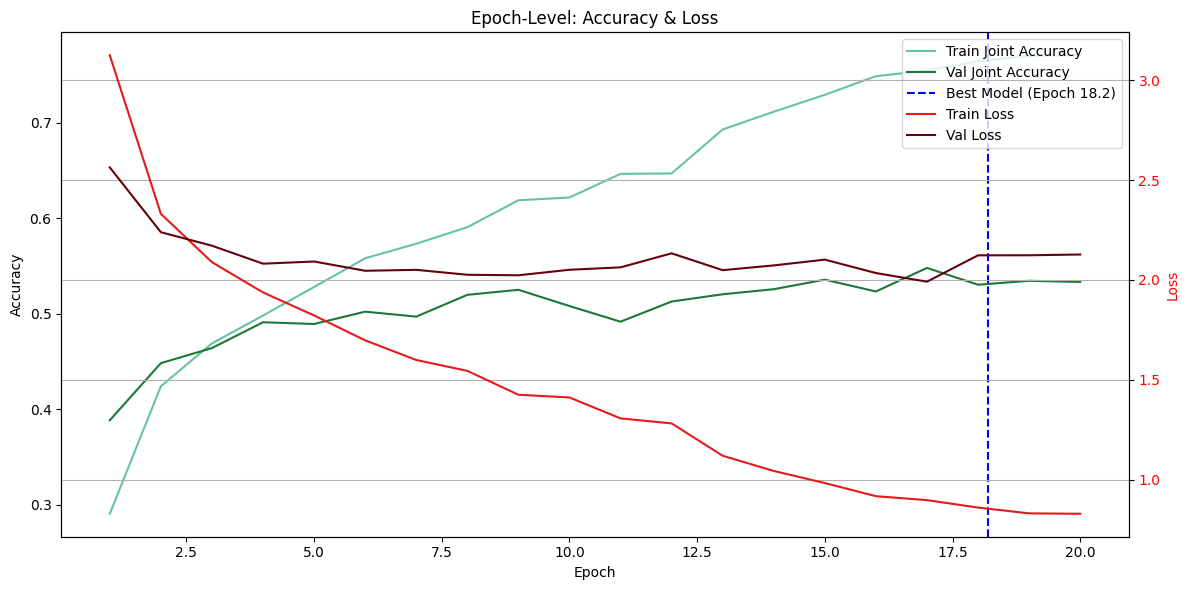

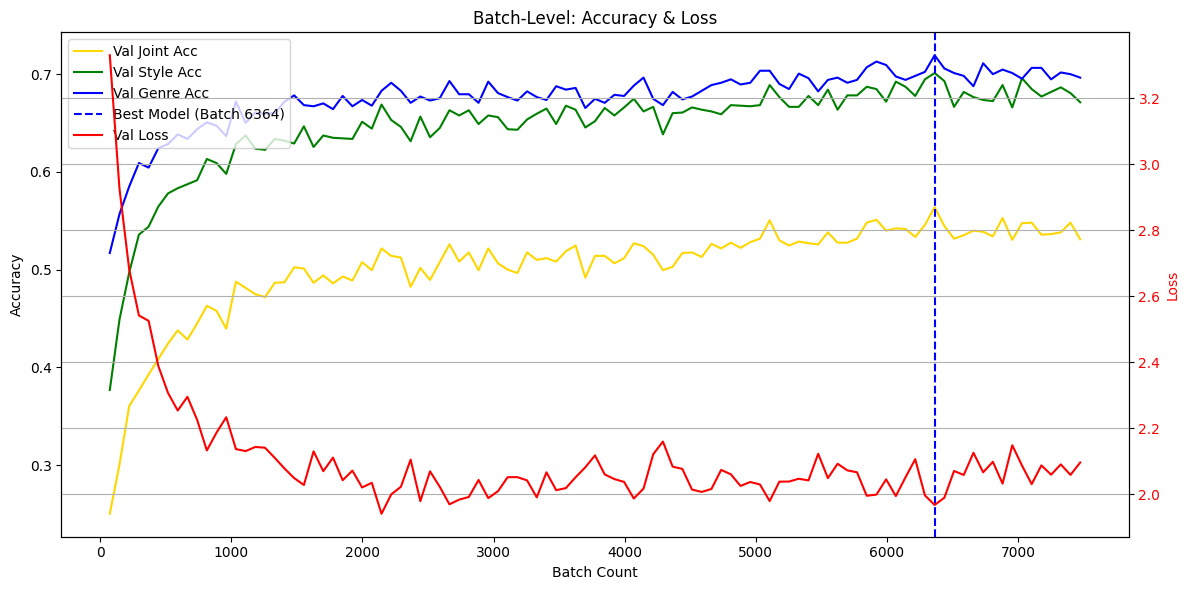

In [3]:
import torch
import matplotlib.pyplot as plt

# Load data
epoch_history_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50_finetune/VAULT_HYPER/epoch_history.pth"
epoch_history = torch.load(epoch_history_path)

batch_history_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50_finetune/VAULT_HYPER/val_batch_history.pth"
batch_history = torch.load(batch_history_path)
val_check_metrics = batch_history["val_check_metrics"]

# Epoch data
epochs = list(range(1, len(epoch_history["train_joint_acc"]) + 1))
best_model_epoch = 18.2

# Fused Epoch-Level Plot (Accuracy + Loss)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Accuracy
ax1.plot(epochs, epoch_history["train_joint_acc"], label='Train Joint Accuracy', color='#66c2a5')
ax1.plot(epochs, epoch_history["val_joint_acc"], label='Val Joint Accuracy', color='#1b7837')
ax1.axvline(best_model_epoch, color='blue', linestyle='--', label='Best Model (Epoch 18.2)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Loss
ax2 = ax1.twinx()
ax2.plot(epochs, epoch_history["train_loss"], label='Train Loss', color='#e41a1c')
ax2.plot(epochs, epoch_history["val_loss"], label='Val Loss', color='#67000d')
ax2.set_ylabel('Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Epoch-Level: Accuracy & Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# Batch-level data
batch_counts = [entry["batch_count"] for entry in val_check_metrics]
joint_accs = [entry["val_joint_acc"] for entry in val_check_metrics]
style_accs = [entry["val_style_acc"] for entry in val_check_metrics]
genre_accs = [entry["val_genre_acc"] for entry in val_check_metrics]
val_losses = [entry["val_loss"] for entry in val_check_metrics]
best_batch_count = 6364

# Batch-Level Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Accuracy
ax1.plot(batch_counts, joint_accs, label='Val Joint Acc', color='gold')
ax1.plot(batch_counts, style_accs, label='Val Style Acc', color='green')
ax1.plot(batch_counts, genre_accs, label='Val Genre Acc', color='blue')
ax1.axvline(best_batch_count, color='blue', linestyle='--', label='Best Model (Batch 6364)')
ax1.set_xlabel('Batch Count')
ax1.set_ylabel('Accuracy', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Loss
ax2 = ax1.twinx()
ax2.plot(batch_counts, val_losses, label='Val Loss', color='red')
ax2.set_ylabel('Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Batch-Level: Accuracy & Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
import json

config_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50_finetune/best_config.json"
with open(config_path, "r") as f:
    best_config = json.load(f)
    
model_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50_finetune/best_resnet50_finetune_multihhead.pth"

# Reinitialize the model.
model = ResNet50FineTuneMultiHead(num_genres, num_styles, dropout_rate=best_config["dropout_rate"]).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

test_loader = DataLoader(test_dataset, batch_size=best_config["batch_size"], shuffle=False, collate_fn=custom_collate_fn)

test_loss = 0.0
test_genre_acc = 0.0
test_style_acc = 0.0
test_joint_acc = 0.0
total_test = 0

all_genre_preds = []
all_genre_trues = []
all_style_preds = []
all_style_trues = []
all_joint_preds = []
all_joint_trues = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", leave=False):
        images = batch["image"].to(device)
        genre_labels = batch["genre"].to(device)
        style_labels = batch["style"].to(device)
        
        # Obtain logits
        genre_logits, style_logits = model(images)
        loss = criterion(genre_logits, genre_labels) + criterion(style_logits, style_labels)
        bsize = images.size(0)
        test_loss += loss.item() * bsize
        
        # Apply softmax to obtain probabilities
        genre_probs = torch.softmax(genre_logits, dim=1)
        style_probs = torch.softmax(style_logits, dim=1)
        
        # Get predictions from probabilities
        genre_preds = torch.argmax(genre_probs, dim=1)
        style_preds = torch.argmax(style_probs, dim=1)
        
        # Compute metrics
        tg, ts, tj = compute_metrics(genre_logits, style_logits, genre_labels, style_labels)
        test_genre_acc += tg * bsize
        test_style_acc += ts * bsize
        test_joint_acc += tj * bsize
        total_test += bsize
        
        # Accumulate predictions and ground truth
        all_genre_preds.extend(genre_preds.cpu().numpy())
        all_genre_trues.extend(genre_labels.cpu().numpy())
        all_style_preds.extend(style_preds.cpu().numpy())
        all_style_trues.extend(style_labels.cpu().numpy())
        joint_preds = list(zip(genre_preds.cpu().numpy(), style_preds.cpu().numpy()))
        joint_trues = list(zip(genre_labels.cpu().numpy(), style_labels.cpu().numpy()))
        all_joint_preds.extend(joint_preds)
        all_joint_trues.extend(joint_trues)

avg_test_loss = test_loss / total_test
avg_test_genre_acc = test_genre_acc / total_test
avg_test_style_acc = test_style_acc / total_test
avg_test_joint_acc = test_joint_acc / total_test

print(f"Best Model Test Loss = {avg_test_loss:.4f}")
print(f"Test Genre Accuracy = {avg_test_genre_acc:.4f}, Test Style Accuracy = {avg_test_style_acc:.4f}, Test Joint Accuracy = {avg_test_joint_acc:.4f}")



Testing:   0%|          | 0/107 [00:00<?, ?it/s]

Best Model Test Loss = 2.0097
Test Genre Accuracy = 0.7058, Test Style Accuracy = 0.6824, Test Joint Accuracy = 0.5377


In [40]:
sample = 0
# Get the probabilities for the sample (assumes genre_probs and style_probs are defined from the test loop)
genre_probs_np = genre_probs[sample].cpu().numpy()
style_probs_np = style_probs[sample].cpu().numpy()

# Format each probability to two decimals.
formatted_genre_probs = [f"{p:.2f}" for p in genre_probs_np]
formatted_style_probs = [f"{p:.2f}" for p in style_probs_np]

# Determine the chosen (predicted) classes.
predicted_genre_index = genre_probs_np.argmax()
predicted_style_index = style_probs_np.argmax()

# Also get the corresponding probability.
predicted_genre_prob = genre_probs_np[predicted_genre_index]
predicted_style_prob = style_probs_np[predicted_style_index]

print("Genre probabilities (sample 6):", formatted_genre_probs)
print("Style probabilities (sample 6):", formatted_style_probs)
print(f"Chosen Genre: {predicted_genre_index} with probability {predicted_genre_prob:.2f}")
print(f"Chosen Style: {predicted_style_index} with probability {predicted_style_prob:.2f}")


Genre probabilities (sample 6): ['0.00', '0.00', '0.01', '0.95', '0.00', '0.00', '0.00', '0.02', '0.00', '0.00', '0.02']
Style probabilities (sample 6): ['0.00', '0.02', '0.07', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.84', '0.05']
Chosen Genre: 3 with probability 0.95
Chosen Style: 9 with probability 0.84



--- Genre Confusion Matrix ---


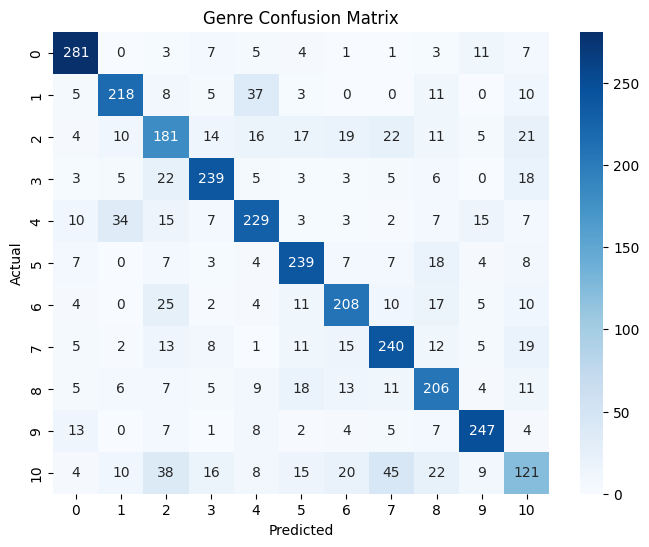


--- Genre Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       323
           1       0.76      0.73      0.75       297
           2       0.56      0.57      0.56       320
           3       0.78      0.77      0.78       309
           4       0.70      0.69      0.70       332
           5       0.73      0.79      0.76       304
           6       0.71      0.70      0.71       296
           7       0.69      0.73      0.71       331
           8       0.64      0.70      0.67       295
           9       0.81      0.83      0.82       298
          10       0.51      0.39      0.44       308

    accuracy                           0.71      3413
   macro avg       0.70      0.71      0.70      3413
weighted avg       0.70      0.71      0.70      3413


--- Style Confusion Matrix ---


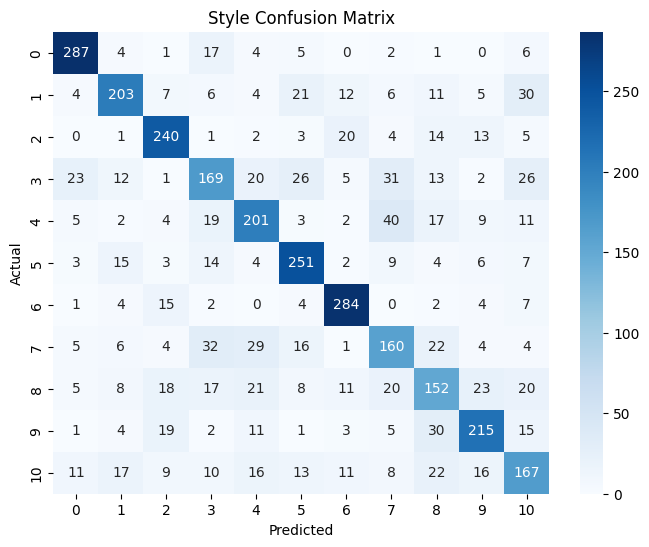


--- Style Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       327
           1       0.74      0.66      0.69       309
           2       0.75      0.79      0.77       303
           3       0.58      0.52      0.55       328
           4       0.64      0.64      0.64       313
           5       0.72      0.79      0.75       318
           6       0.81      0.88      0.84       323
           7       0.56      0.57      0.56       283
           8       0.53      0.50      0.51       303
           9       0.72      0.70      0.71       306
          10       0.56      0.56      0.56       300

    accuracy                           0.68      3413
   macro avg       0.68      0.68      0.68      3413
weighted avg       0.68      0.68      0.68      3413


Unique genres in joint labels: ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


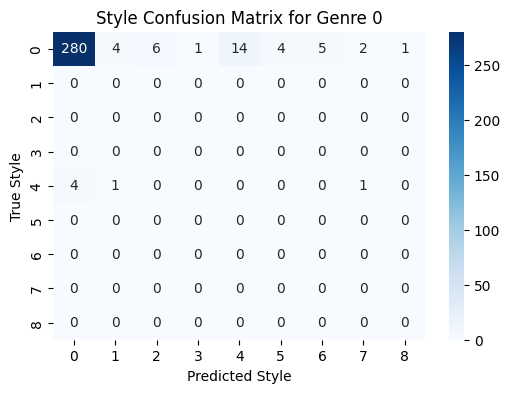

Classification Report for Genre 0:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       317
           1       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.87       323
   macro avg       0.11      0.10      0.10       323
weighted avg       0.97      0.87      0.91       323



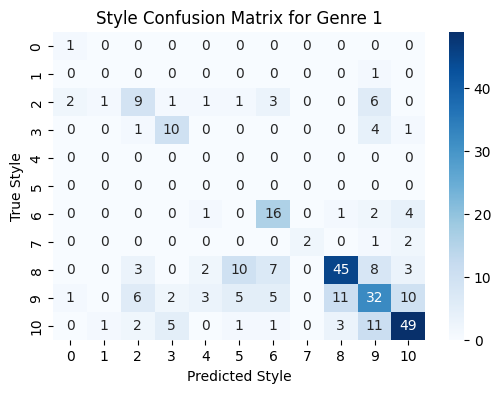

Classification Report for Genre 1:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       0.00      0.00      0.00         1
          10       0.43      0.38      0.40        24
           2       0.56      0.62      0.59        16
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.50      0.67      0.57        24
           6       1.00      0.40      0.57         5
           7       0.75      0.58      0.65        78
           8       0.49      0.43      0.46        75
           9       0.71      0.67      0.69        73

    accuracy                           0.55       297
   macro avg       0.43      0.43      0.39       297
weighted avg       0.62      0.55      0.58       297



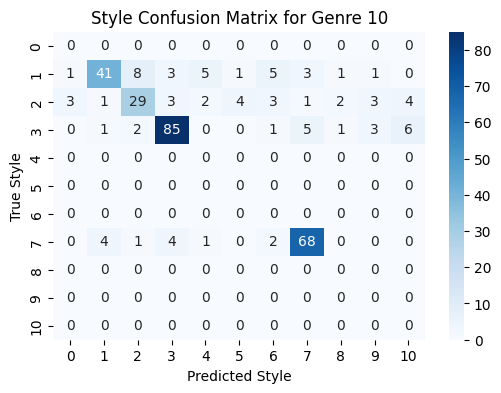

Classification Report for Genre 10:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.87      0.59      0.71        69
          10       0.72      0.53      0.61        55
           2       0.89      0.82      0.85       104
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.88      0.85      0.87        80
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.72       308
   macro avg       0.31      0.25      0.28       308
weighted avg       0.86      0.72      0.78       308



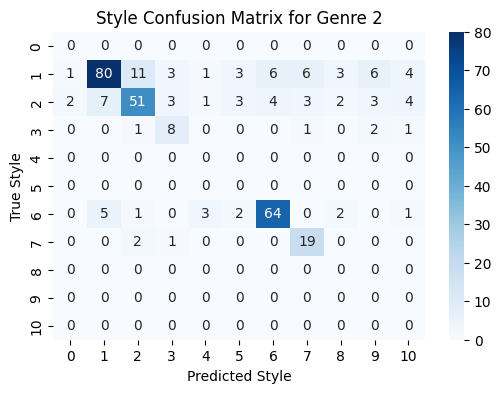

Classification Report for Genre 2:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.87      0.65      0.74       124
          10       0.77      0.61      0.68        83
           2       0.53      0.62      0.57        13
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.86      0.82      0.84        78
           6       0.66      0.86      0.75        22
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.69       320
   macro avg       0.34      0.32      0.33       320
weighted avg       0.81      0.69      0.74       320



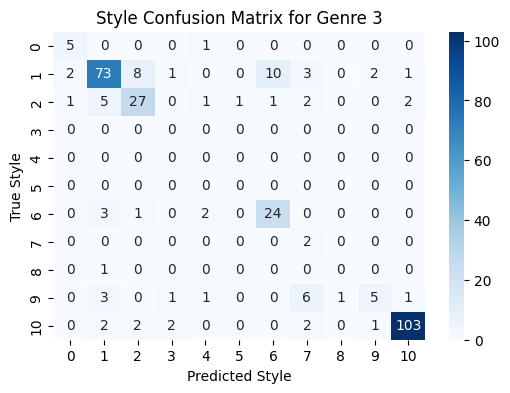

Classification Report for Genre 3:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.84      0.73      0.78       100
          10       0.71      0.68      0.69        40
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.69      0.80      0.74        30
           6       0.13      1.00      0.24         2
           7       0.00      0.00      0.00         1
           8       0.62      0.28      0.38        18
           9       0.96      0.92      0.94       112

    accuracy                           0.77       309
   macro avg       0.42      0.48      0.41       309
weighted avg       0.83      0.77      0.79       309



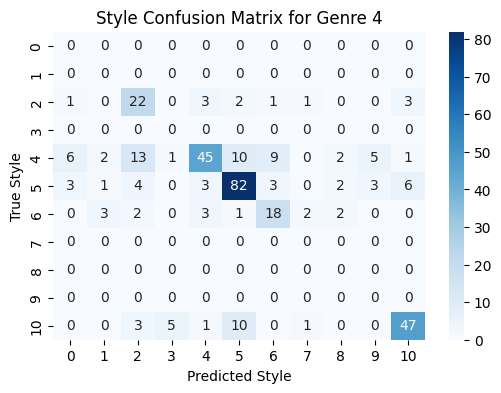

Classification Report for Genre 4:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
          10       0.50      0.67      0.57        33
           2       0.00      0.00      0.00         0
           3       0.82      0.48      0.60        94
           4       0.78      0.77      0.77       107
           5       0.58      0.58      0.58        31
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.82      0.70      0.76        67

    accuracy                           0.64       332
   macro avg       0.32      0.29      0.30       332
weighted avg       0.75      0.64      0.68       332



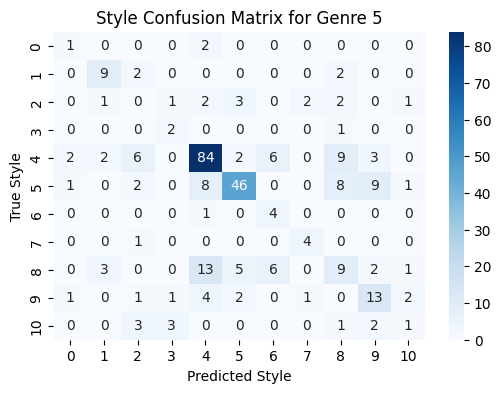

Classification Report for Genre 5:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.60      0.69      0.64        13
          10       0.00      0.00      0.00        12
           2       0.29      0.67      0.40         3
           3       0.74      0.74      0.74       114
           4       0.79      0.61      0.69        75
           5       0.25      0.80      0.38         5
           6       0.57      0.80      0.67         5
           7       0.28      0.23      0.25        39
           8       0.45      0.52      0.48        25
           9       0.17      0.10      0.12        10

    accuracy                           0.57       304
   macro avg       0.39      0.50      0.42       304
weighted avg       0.59      0.57      0.57       304



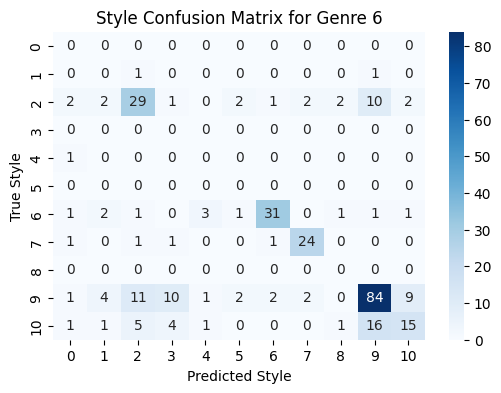

Classification Report for Genre 6:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
          10       0.60      0.55      0.57        53
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.89      0.74      0.81        42
           6       0.86      0.86      0.86        28
           7       0.00      0.00      0.00         0
           8       0.75      0.67      0.71       126
           9       0.56      0.34      0.42        44

    accuracy                           0.62       296
   macro avg       0.33      0.29      0.31       296
weighted avg       0.72      0.62      0.66       296



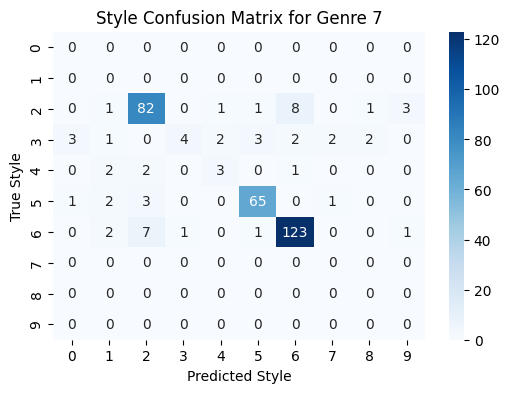

Classification Report for Genre 7:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
           2       0.87      0.85      0.86        97
           3       0.80      0.21      0.33        19
           4       0.50      0.38      0.43         8
           5       0.93      0.90      0.92        72
           6       0.92      0.91      0.91       135
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.84       331
   macro avg       0.40      0.32      0.35       331
weighted avg       0.89      0.84      0.85       331



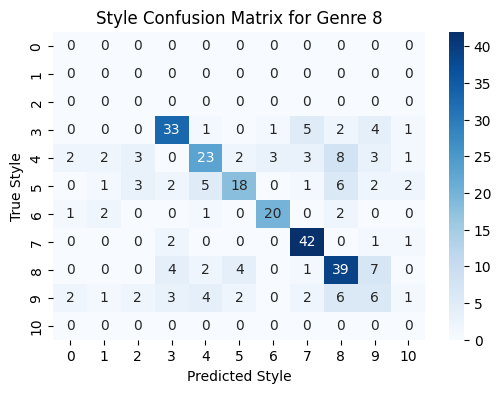

Classification Report for Genre 8:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
           2       0.75      0.70      0.73        47
           3       0.64      0.46      0.53        50
           4       0.69      0.45      0.55        40
           5       0.83      0.77      0.80        26
           6       0.78      0.91      0.84        46
           7       0.62      0.68      0.65        57
           8       0.26      0.21      0.23        29
           9       0.00      0.00      0.00         0

    accuracy                           0.61       295
   macro avg       0.42      0.38      0.39       295
weighted avg       0.66      0.61      0.63       295



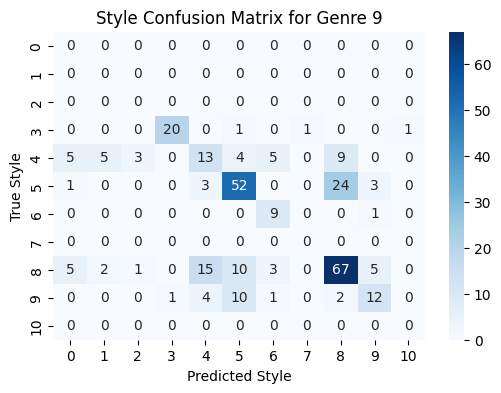

Classification Report for Genre 9:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
           2       0.95      0.87      0.91        23
           3       0.37      0.30      0.33        44
           4       0.68      0.63      0.65        83
           5       0.50      0.90      0.64        10
           6       0.00      0.00      0.00         0
           7       0.66      0.62      0.64       108
           8       0.57      0.40      0.47        30
           9       0.00      0.00      0.00         0

    accuracy                           0.58       298
   macro avg       0.34      0.34      0.33       298
weighted avg       0.63      0.58      0.60       298



In [31]:
def plot_confusion_matrix(cm, name):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

print("\n--- Genre Confusion Matrix ---")
genre_cm = confusion_matrix(all_genre_trues, all_genre_preds)
plot_confusion_matrix(genre_cm, "Genre")
print("\n--- Genre Classification Report ---")
print(classification_report(all_genre_trues, all_genre_preds, zero_division=0))

print("\n--- Style Confusion Matrix ---")
style_cm = confusion_matrix(all_style_trues, all_style_preds)
plot_confusion_matrix(style_cm, "Style")
print("\n--- Style Classification Report ---")
print(classification_report(all_style_trues, all_style_preds, zero_division=0))

all_joint_preds_str = [f"{g}_{s}" for g, s in all_joint_preds]
all_joint_trues_str = [f"{g}_{s}" for g, s in all_joint_trues]

unique_genres = sorted(list({label.split('_')[0] for label in all_joint_trues_str}))
print("\nUnique genres in joint labels:", unique_genres)

for genre in unique_genres:
    indices = [i for i, label in enumerate(all_joint_trues_str) if label.split('_')[0] == genre]
    if len(indices) == 0:
        continue

    true_styles = [all_joint_trues_str[i].split('_')[1] for i in indices]
    pred_styles = [all_joint_preds_str[i].split('_')[1] for i in indices]
    unique_styles = sorted(list(set(true_styles) | set(pred_styles)))
    cm = confusion_matrix(true_styles, pred_styles, labels=unique_styles)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Style Confusion Matrix for Genre {genre}")
    plt.xlabel("Predicted Style")
    plt.ylabel("True Style")
    plt.show()
    
    print(f"Classification Report for Genre {genre}:")
    print(classification_report(true_styles, pred_styles, zero_division=0))
